# SVR

In [76]:
# Importing the neccesary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from scipy.stats import zscore
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor

In [77]:
# Defining the data imputation function to handle missing data
def missing_data_imputation_for_regression(df):

    # dropping PCR  of the Classification task
    df.drop('pCR (outcome)',axis=1, inplace=True)

    # Replacing missing values
    df=df.replace(999, np.nan)
    imputer = SimpleImputer(strategy='median')
    df_imputed=imputer.fit_transform(df)
    df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

    return df_imputed

In [78]:
def handle_outliers(X, Q1_percent = 0.25, Q3_percent = 0.75, threshold=1.5):
    """
    Handle outliers in a DataFrame using the IQR method.

    :param df: Pandas DataFrame containing the data.
    :param threshold: The multiplier for IQR to determine the cut-off. Default is 1.5.
    :return: DataFrame with outliers handled.
    """
    outlier_indices = []
    cat_cols = ["ER", "PgR", "HER2", "TrippleNegative", "ChemoGrade", "Proliferation", "HistologyType", "LNStatus", "TumourStage"]
    cont_cols = [col for col in X.columns if col not in cat_cols]
    X_cleaned = X.copy()
    # Iterate over each column
    for col in cont_cols:
        if X_cleaned[col].dtype != 'object':  # Apply only to numerical columns
            Q1 = X_cleaned[col].quantile(Q1_percent)
            Q3 = X_cleaned[col].quantile(Q3_percent)
            IQR = Q3 - Q1

             # Define the limits for outliers
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR

            # Impute the outliers
            X_cleaned[col] = X_cleaned[col].mask(X_cleaned[col] < lower_bound, lower_bound)
            X_cleaned[col] = X_cleaned[col].mask(X_cleaned[col] > upper_bound, upper_bound)

    return X_cleaned

In [79]:
# Dimensionality Reduction function to compute the PCA and ISOMAP Reduced features
def Dimensionality_reduction(X_train, X_test, n = 5, var = 0.95):
    # Use ISOMAP to reduce the number of features to n (nonlinear method)
    isomap = Isomap(n_components=n)
    X_train_isomap = isomap.fit_transform(X_train)
    X_test_isomap = isomap.transform(X_test)

    # Apply PCA to reduce the dimensionality of the features (linear method)
    pca = PCA(n_components=var) # Keep certain percentage of the variance
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Use Reconstruction error to evaluate the performance of both algorithms
    re_isomap = isomap.reconstruction_error()
    re_pca = mean_squared_error(X_train, pca.inverse_transform(X_train_pca))
    # Compute the PVE for each principal component
    pve = pca.explained_variance_ratio_.sum()

    # Print the results
    print("The Reconstruction error for ISOMAP: {:.2f}".format(re_isomap))
    print("The Reconstruction error for PCA: {:.2f}".format(re_pca))
    print("The Presentage value error for PCA : {:.2f}".format(pve))


    return X_train_isomap, X_test_isomap, X_train_pca, X_test_pca, pca

In [80]:
# Clean The data

# Load the data
df=pd.read_excel('TrainDataset2023.xls')
df=df.drop('ID',axis=1)
#df['HistologyType'] = df['HistologyType'].map({1: 0, 2: 1})

# Imputation of missing data
df_imputed = missing_data_imputation_for_regression(df)
y = df_imputed["RelapseFreeSurvival (outcome)"]
X = df_imputed.drop("RelapseFreeSurvival (outcome)", axis=1)

# cleaning of features
X_cleaned = handle_outliers(X, threshold=1.2)


# Standardization of features
#scaler = StandardScaler()
#X_cleaned = scaler.fit_transform(X_cleaned)
X_cleaned = pd.DataFrame(X_cleaned, columns= X.columns)

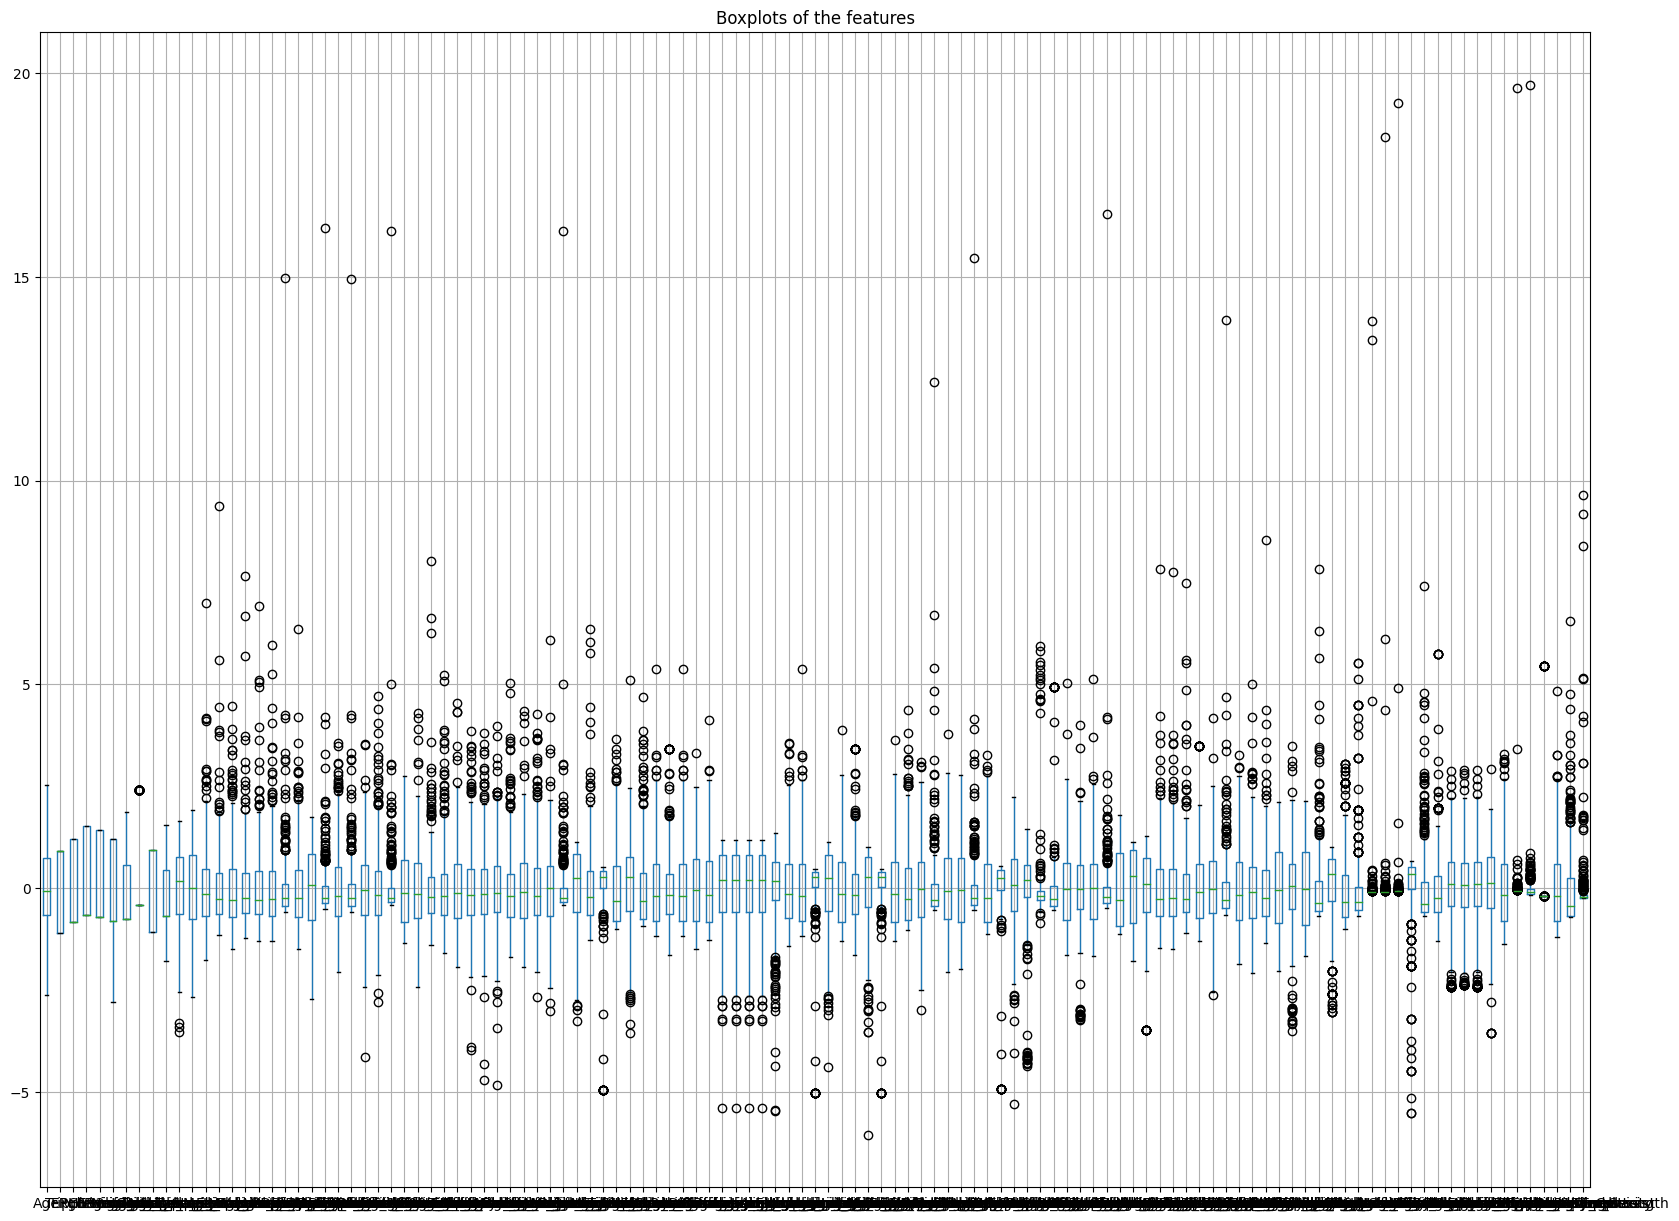

In [81]:
# 3- Visualize the data before outliers handling
scaler = StandardScaler()
X_visual = scaler.fit_transform(X)
X_visual = pd.DataFrame(X_visual, columns = X.columns)
# Prepare the plot
plt.figure(figsize=(20,15))
X_visual.boxplot()
plt.title("Boxplots of the features")
plt.show()

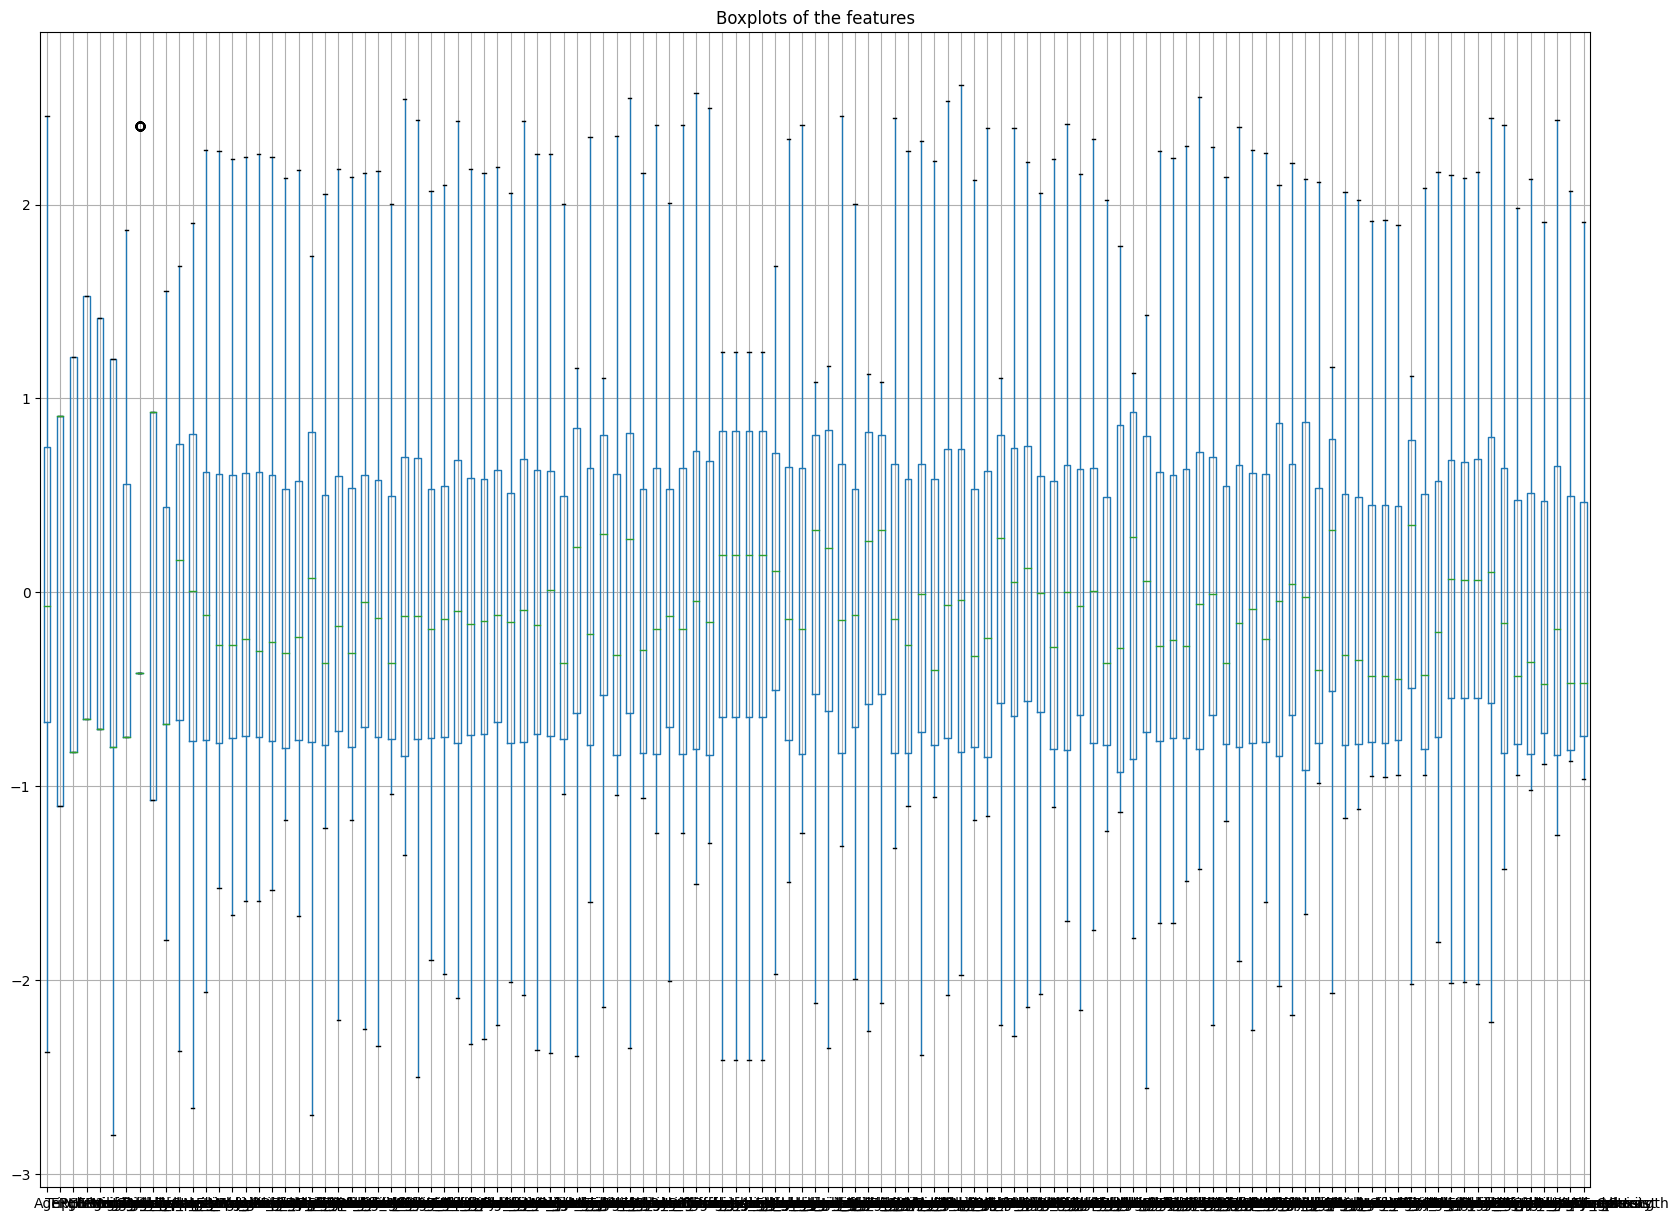

In [82]:
#  Features visualization after outliers handling
X_fil_df = X_cleaned.copy()
# normalization for visualization purpose of how we treated the outliers problems
scaler = StandardScaler()
X_visual = scaler.fit_transform(X_cleaned)
X_visual = pd.DataFrame(X_visual, columns = X_fil_df.columns)
# Prepare the plot
plt.figure(figsize=(20,15))
X_visual.boxplot()
plt.title("Boxplots of the features")
plt.show()

In [ ]:
#  Feature selection methods

# Method 1: Feature selection based on RFE(Recursive feature elimination and RandomForestRegressor)(embedded method)
cat_cols = ["ER", "PgR", "HER2", "TrippleNegative", "ChemoGrade", "Proliferation", "HistologyType", "LNStatus", "TumourStage"]
cont_cols = [col for col in X.columns if col not in cat_cols]
# Prepare the data for training
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size = 0.2, random_state=20)

# build the regressor

rf_regressor = RandomForestRegressor(
    n_estimators=100,  # Number of trees in the forest
    max_depth=None,    # Maximum number of levels in each decision tree
    min_samples_split=2,   # Minimum number of data points placed in a node before the node is split
    min_samples_leaf=1,    # Minimum number of data points allowed in a leaf node
    bootstrap=True,        # Method for sampling data points (with or without replacement)
    random_state=42,        # Seed used by the random number generator
    n_jobs=-1,
    verbose = 3
)

# Initialize RFE with the random forest regressor as the estimator
rfe = RFE(estimator=rf_regressor, n_features_to_select=20, step=1)  # Selecting top 15 features

# Fit RFE
rfe.fit(X_train, y_train)

# Print the ranking of the features
print('Feature Ranking:', rfe.ranking_)


In [83]:
# selected features based on RFE
selected_features = X_cleaned.columns[rfe.support_]
print(selected_features)

Index(['Age', 'original_shape_Elongation', 'original_shape_Flatness',
       'original_shape_MinorAxisLength', 'original_shape_Sphericity',
       'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_Range', 'original_firstorder_Skewness',
       'original_firstorder_Variance', 'original_glcm_Imc1',
       'original_gldm_DependenceVariance',
       'original_gldm_SmallDependenceLowGrayLevelEmphasis',
       'original_glrlm_LongRunHighGrayLevelEmphasis',
       'original_glrlm_ShortRunHighGrayLevelEmphasis',
       'original_glszm_HighGrayLevelZoneEmphasis',
       'original_glszm_SmallAreaHighGrayLevelEmphasis',
       'original_glszm_ZoneEntropy', 'original_glszm_ZonePercentage'],
      dtype='object')


In [84]:
#Method 2: feature selection method using correlation + ANOVA tests
# Separate features by type
cat_cols = ["ER", "PgR", "HER2", "TrippleNegative", "ChemoGrade", "Proliferation", "HistologyType", "LNStatus", "TumourStage"]
cont_cols = [col for col in X.columns if col not in cat_cols]

target = "RelapseFreeSurvival (outcome)"
X_cont = X_cleaned.loc[:,cont_cols]
X_cat = X_cleaned.loc[:,cat_cols]

threshold_1 = 0.09
# Correlation for continuous features
correlation_matrix = X_cont.corrwith(y).abs()
high_corr_cont_features = correlation_matrix[correlation_matrix > threshold_1].index.tolist() # Threshold is subjective



# ANOVA for categorical features

selector = SelectKBest(score_func=f_regression, k='all')  # 'k' can be set to select the top 'k' features
selector.fit(X_cat, y)

# Get the p-values for the features
p_values = selector.pvalues_

# Print the p-values
print(f"The p-values of the null hypothesis : \n {p_values}")

# Get the p-values for the features and convert to a Series for easier handling
p_values = pd.Series(selector.pvalues_, index=X_cat.columns)

# Select features with p_values less than the threshold
threshold_2 = 0.1
selected_cat_features = p_values[p_values < threshold_2].index.tolist()

# Print the selected features
print('\nUsing ANOVA feature selection :')
print(f"Selected categorical features  with p-value < {threshold_2}: {selected_cat_features}")

# Create a new DataFrame with the selected features only
high_corr_cat_features = selected_cat_features
# Combined selected features
selected_features = high_corr_cont_features + high_corr_cat_features
print(f"\nThe selected features are : \n {selected_features}")

The p-values of the null hypothesis : 
 [0.77402838 0.3417521  0.12075624 0.48126597 0.03266993 0.2508831
 0.72340406 0.99349495 0.00932342]

Using ANOVA feature selection :
Selected categorical features  with p-value < 0.1: ['ChemoGrade', 'TumourStage']

The selected features are : 
 ['original_shape_LeastAxisLength', 'original_shape_MajorAxisLength', 'original_shape_Maximum2DDiameterColumn', 'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum2DDiameterSlice', 'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume', 'original_shape_MinorAxisLength', 'original_shape_Sphericity', 'original_shape_SurfaceArea', 'original_shape_VoxelVolume', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 

In [85]:
 # Print the names of the selected features
print(selected_features)
print(len(selected_features))

['original_shape_LeastAxisLength', 'original_shape_MajorAxisLength', 'original_shape_Maximum2DDiameterColumn', 'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum2DDiameterSlice', 'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume', 'original_shape_MinorAxisLength', 'original_shape_Sphericity', 'original_shape_SurfaceArea', 'original_shape_VoxelVolume', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_TotalEnergy', 'original_firstorder_Variance', 'original_gldm_GrayLevelNonUniformity', 'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_RunLengthNonUniformity', 'original_glszm_SizeZoneNonUniformityNormalized', 'original_glszm_SmallAreaEmphasis', 'original_g

In [86]:
#  Apply the selected features on the data
X_filtered = X_cleaned.loc[:, selected_features]
X_filtered.head()

original_shape_LeastAxisLength  original_shape_MajorAxisLength  \
0                       23.781937                       32.844370   
1                       20.715461                       43.504095   
2                       21.659822                       36.435505   
3                       26.590504                       53.050724   
4                       20.456571                       27.265716   

   original_shape_Maximum2DDiameterColumn  \
0                               37.696154   
1                               51.971146   
2                               32.984845   
3                               66.910388   
4                               33.241540   

   original_shape_Maximum2DDiameterRow  original_shape_Maximum2DDiameterSlice  \
0                            38.626416                              34.713110   
1                            41.761226                              36.400549   
2                            40.447497                              42.379240   
3                            44.944410                              66.760767   
4                            30.594117                              31.384710   

   original_shape_Maximum3DDiameter  original_shape_MeshVolume  \
0                         39.572718               14209.458330   
1                         53.310412               14202.708330   
2                         44.384682               10858.375000   
3                         69.000000               26748.208330   
4                         35.042831                8846.541667   

   original_shape_MinorAxisLength  original_shape_Sphericity  \
0                       26.732440                   0.771675   
1                       28.978871                   0.603481   
2                       23.503921                   0.608183   
3                       40.893735                   0.474509   
4                       23.476732                   0.756228   

   original_shape_SurfaceArea  original_shape_VoxelVolume  \
0                 3676.500012                     14263.0   
1                 4699.678466                     14254.0   
2                 3899.055524                     10960.0   
3                 9115.275207                     26899.0   
4                 2735.354881                      8894.0   

   original_firstorder_90Percentile  original_firstorder_Energy  \
0                          1.140968                  2897.68930   
1                          2.322627                 41105.32510   
2                          1.961740                 19774.94893   
3                          2.164869                 72854.17151   
4                          1.832410                 15697.30914   

   original_firstorder_InterquartileRange  original_firstorder_Kurtosis  \
0                                0.406537                      3.878843   
1                                0.730463                      3.878843   
2                                0.509910                      3.878843   
3                                0.740609                      3.421056   
4                                0.787978                      3.107181   

   original_firstorder_Maximum  original_firstorder_MeanAbsoluteDeviation  \
0                     2.114799                                   0.278008   
1                     3.857952                                   0.499454   
2                     3.841710                                   0.400199   
3                     3.030400                                   0.442713   
4                     2.315364                                   0.447799   

   original_firstorder_Range  original_firstorder_RobustMeanAbsoluteDeviation  \
0                   3.366632                                         0.174026   
1                   4.964442                                         0.318599   
2                   4.867321                                         0.231278   
3                   3.881506            

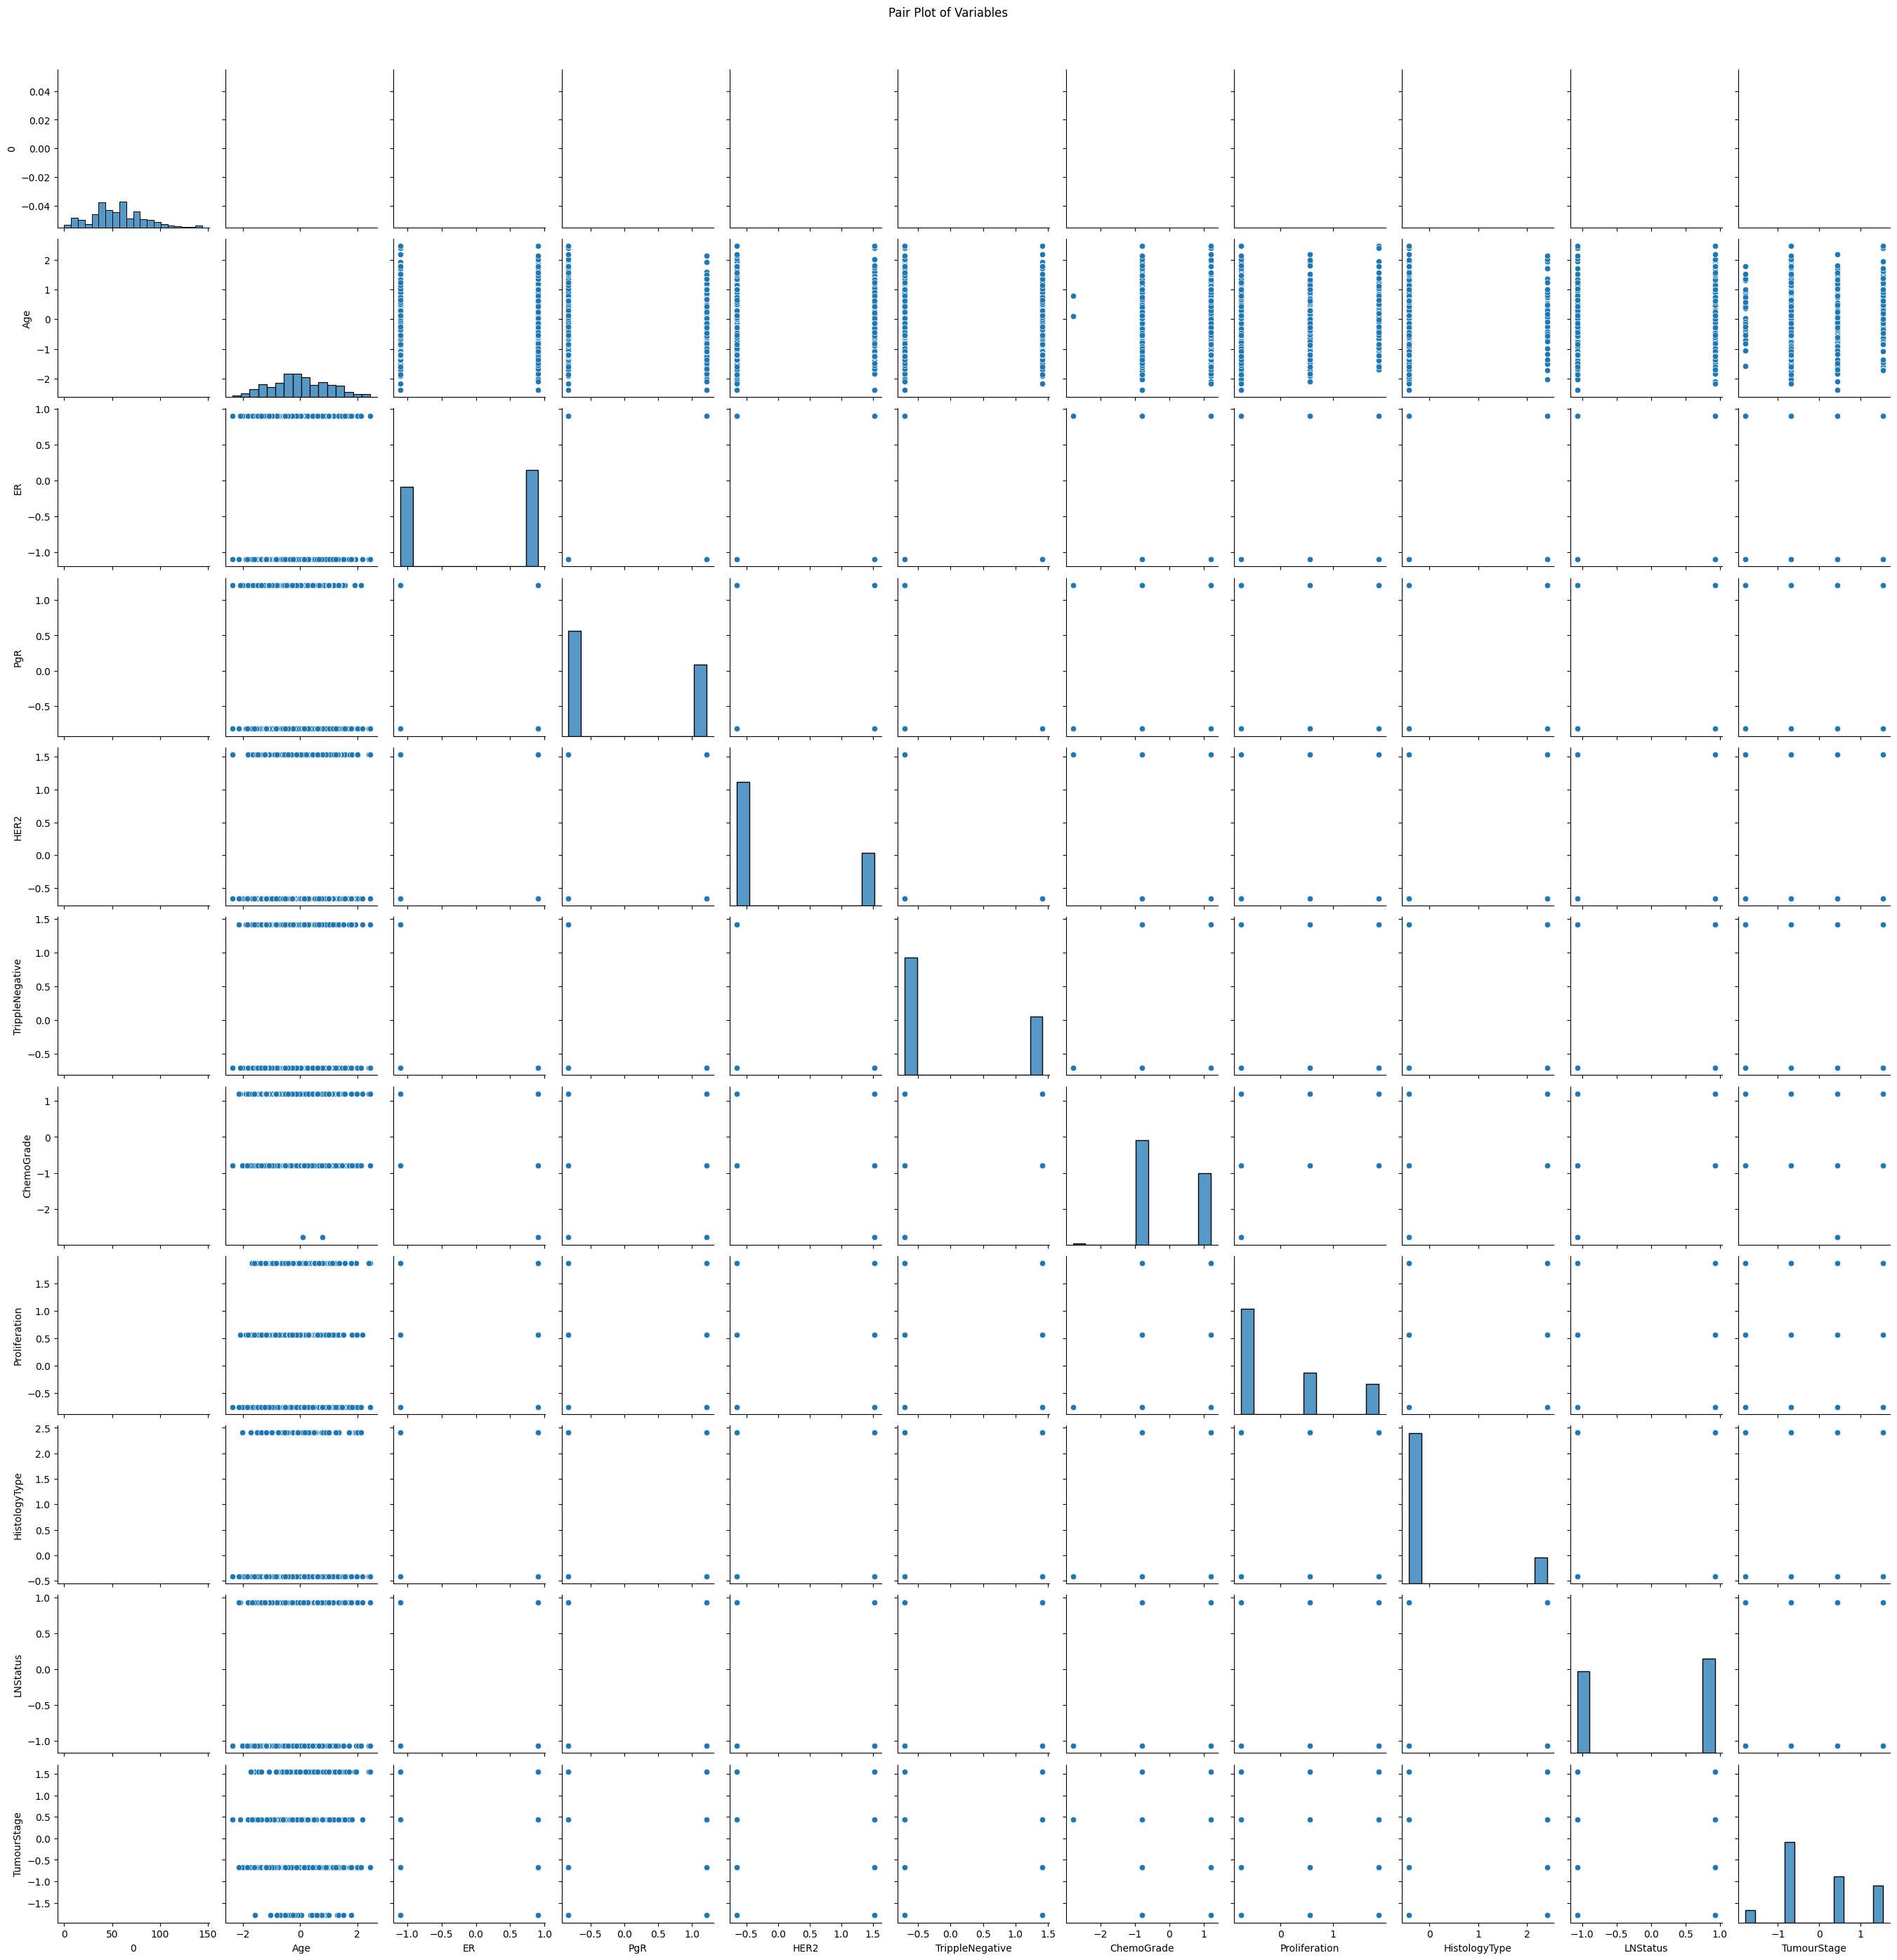

In [87]:
#Visualization samples of 10 selected features to show their correlation with the output
X_visual = X_visual.iloc[:,:10]
df_visual = pd.concat([y, X_visual])
sns.pairplot(df_visual)
plt.suptitle('Pair Plot of Variables', y=1.02)
plt.show()

In [88]:
# splitting the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size = 0.2, random_state=20)
# Normalize the total features (training + testing)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# 11- (optional) Perform Dimensionality Reduction on the data
_, _, X_train, X_test, pca  = Dimensionality_reduction(X_train,X_test, n= 15,var =0.95)
print(X_train.shape)

In [ ]:
# (optional) visualization of features correlation after PCA
X_train_pca_vis = X_train.copy()
X_train_pca_vis = pd.DataFrame(X_train_pca_vis)
df_pca_visual = pd.concat([y, X_train_pca_vis])
sns.pairplot(df_pca_visual)
plt.suptitle('Pair Plot of Variables', y=1.02)
plt.show()

In [89]:
# Defining the function used for training both the 'Multilayerperceptron (mlp) and Support Vector Regressor (SVR)'
def model_training(X_train,y_train, training = 'mlp'):
    # Define a base model with default parameters

    if training == 'mlp':
        base_model = MLPRegressor(max_iter=100000, tol=0.000001, verbose = True)

        # Define a parameter grid for tuning the hyperparameters
        param_grid = {
        "hidden_layer_sizes": [(8,5),
                               (15,10),
                               (10,5,3),
                               (30,20,10),
                              ],
        "activation": ["relu", 'tanh'],
        "solver": ["adam"],
        "learning_rate": ["constant", "adaptive"],
        "alpha": [0.0001, 0.001, 0.01, 0.1]
        }

        # Create a grid search object
        grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1, verbose = 3)


        # Fit the grid search on the training data
        grid_search.fit(X_train, y_train)

        # Print the best parameters and score
        print(f"The best parameters are: {grid_search.best_params_}")
        print(f"The best MSE score is: {-grid_search.best_score_}")

        # Select the best model
        best_model = grid_search.best_estimator_
    if training == 'svr':
        base_model = SVR()
        param_grid = {
                      "kernel": ["linear", "poly", "rbf"],
                      "C": [0.1, 1, 10, 100],
                      "degree": [2, 3, 4],
                      "gamma": ["scale", "auto"],
                      "epsilon": [0.01, 0.1, 0.5]
                     }
        grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring= "r2", n_jobs=-1, verbose=3)
        grid_search.fit(X_train, y_train)
        print(f"The best parameters are: {grid_search.best_params_}")
        print(f"The best score is: {-grid_search.best_score_}")
        # Select the best model
        best_model = grid_search.best_estimator_


    return best_model

In [ ]:
#X_train = X_train_norm
#X_test = X_test_norm
# 13- Training the data on multi-layer perceptron neural network
model = model_training(X_train,y_train, training = 'mlp')

# Predict on the training data
y_pred_train = model.predict(X_train)
# different metrics on the training data
mae_tr = mean_absolute_error(y_train, y_pred_train)
mse_tr = mean_squared_error(y_train, y_pred_train)
r2_tr = r2_score(y_train, y_pred_train)

# different metrics on the testing data
y_pred_test = model.predict(X_test)
mae_ts = mean_absolute_error(y_test, y_pred_test)
mse_ts = mean_squared_error(y_test, y_pred_test)
r2_ts = r2_score(y_test, y_pred_test)

print(f"Mean absolute error on training data: {mae_tr:.2f}")
print(f"R-squared score on training data: {r2_tr:.2f}")
print("----------------------------------------\n")
print(f"Mean absolute error on testing data: {mae_ts:.2f}")
print(f"R-squared score on testing data: {r2_ts:.2f}")

In [ ]:
#X_train = X_train_norm
#X_test = X_test_norm
# Training the data on multi-layer perceptron neural network
model = model_training(X_train,y_train, training = 'mlp')

# Predict on the training data
y_pred_train = model.predict(X_train)
# different metrics on the training data
mae_tr = mean_absolute_error(y_train, y_pred_train)
mse_tr = mean_squared_error(y_train, y_pred_train)
r2_tr = r2_score(y_train, y_pred_train)

# different metrics on the testing data
y_pred_test = model.predict(X_test)
mae_ts = mean_absolute_error(y_test, y_pred_test)
mse_ts = mean_squared_error(y_test, y_pred_test)
r2_ts = r2_score(y_test, y_pred_test)

print(f"Mean absolute error on training data: {mae_tr:.2f}")

print(f"R-squared score on training data: {r2_tr:.2f}")
print("----------------------------------------\n")
print(f"Mean absolute error on testing data: {mae_ts:.2f}")

print(f"R-squared score on testing data: {r2_ts:.2f}")

In [91]:
#X_train = X_train_norm
#X_test = X_test_norm
# Training of data on support vector regressor
model = model_training(X_train, y_train, training = 'svr')

# Predict on the training data
y_pred_train = model.predict(X_train)
# different metrics on the training data
mae_tr = mean_absolute_error(y_train, y_pred_train)
mse_tr = mean_squared_error(y_train, y_pred_train)
r2_tr = r2_score(y_train, y_pred_train)

# different metrics on the testing data
y_pred_test = model.predict(X_test)
mae_ts = mean_absolute_error(y_test, y_pred_test)
mse_ts = mean_squared_error(y_test, y_pred_test)
r2_ts = r2_score(y_test, y_pred_test)

print(f"Mean absolute error on training data: {mae_tr:.2f}")

print(f"R-squared score on training data: {r2_tr:.2f}")
print("----------------------------------------\n")
print(f"Mean absolute error on testing data: {mae_ts:.2f}")

print(f"R-squared score on testing data: {r2_ts:.2f}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
The best parameters are: {'C': 10, 'degree': 2, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
The best score is: -0.006915603838824747
Mean absolute error on training data: 18.43
R-squared score on training data: 0.20
----------------------------------------

Mean absolute error on testing data: 18.84
R-squared score on testing data: 0.08


In [92]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score

# 8- Apply K-fold cross-validation and 5. Evaluate using the mean absolute error (MSE) loss function
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=275)
cv_scores = cross_val_score(model, X_filtered, y, cv=kfold, scoring='r2')
print(f"Cross-validated R-squared scores: {cv_scores}")
print(f"Mean CV R-squared: {np.mean(cv_scores)}")
cv_results = cross_val_score(model, X_filtered, y, cv=kfold, scoring='neg_mean_absolute_error')
print(f"Cross-validated MAEs: {cv_results}")
print(f"Average MAE of {k}-fold CV = {-cv_results.mean()}")

Cross-validated R-squared scores: [ 0.00651504  0.02979949 -0.00241244 -0.02521313 -0.00151435]
Mean CV R-squared: 0.0014349232512974152
Cross-validated MAEs: [-21.83532913 -20.50796696 -20.54568898 -20.39988964 -22.74068053]
Average MAE of 5-fold CV = 21.205911048752426


In [93]:
# Testing Data reading
df_test=pd.read_excel('TestDatasetExample.xls')
df_test=df_test.drop('ID',axis=1)


In [94]:
#Imputing missing values in testing data
df_test['HistologyType'] =df_test.loc[:,'HistologyType'].replace(999, np.nan)
columns = df_test.columns
imputer = SimpleImputer(strategy='median')
df_test=imputer.fit_transform(df_test)
df_test = pd.DataFrame(df_test, columns=columns)
df_test['HistologyType'] = df_test['HistologyType'].map({1: 0, 2: 1})
df_test['HistologyType'].value_counts()

0    3
Name: HistologyType, dtype: int64

In [95]:
# testing data normalization using "scaler" object that has been used to fit with training data
X_TestEx = df_test.loc[:,selected_features]
X_TestEx = scaler.transform(X_TestEx)
# (Optional) do pca transform if you only have done dimensionality reduction/ if not, comment out this line
#X_TestEx = pca.transform(X_TestEx)
print(X_TestEx.shape)

(3, 32)


In [96]:
#  Predict the expected output based on the testing example normalized and cleaned input
y_pred_testex = model.predict(X_TestEx)
print(y_pred_testex)

[49.30322905 49.97801102 48.6163066 ]


# Random Forest

In [ ]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold

import joblib

In [ ]:
# Set option to display all columns
pd.set_option('display.max_columns', None)

# Reading the Data
df=pd.read_excel('TrainDataset2023.xls')

In [ ]:
# drop 'ID and pCR outcome'
df.drop(['ID', 'pCR (outcome)'], axis=1, inplace=True)

df.head()

RelapseFreeSurvival (outcome)   Age  ER  PgR  HER2  TrippleNegative  \
0                          144.0  41.0   0    0     0                1   
1                          142.0  39.0   1    1     0                0   
2                          135.0  31.0   0    0     0                1   
3                           12.0  35.0   0    0     0                1   
4                          109.0  61.0   1    0     0                0   

   ChemoGrade  Proliferation  HistologyType  LNStatus  TumourStage  \
0           3              3              1         1            2   
1           3              3              1         1            2   
2           2              1              1         0            2   
3           3              3              1         1            3   
4           2              1              1         0            2   

   original_shape_Elongation  original_shape_Flatness  \
0                   0.813912                 0.724080   
1                   0.666118                 0.476173   
2                   0.645083                 0.594470   
3                   0.770842                 0.501228   
4                   0.861035                 0.750267   

   original_shape_LeastAxisLength  original_shape_MajorAxisLength  \
0                       23.781937                       32.844370   
1                       20.715461                       43.504095   
2                       21.659822                       36.435505   
3                       26.590504                       53.050724   
4                       20.456571                       27.265716   

   original_shape_Maximum2DDiameterColumn  \
0                               37.696154   
1                               51.971146   
2                               32.984845   
3                               66.910388   
4                               33.241540   

   original_shape_Maximum2DDiameterRow  original_shape_Maximum2DDiameterSlice  \
0                            38.626416                              34.713110   
1                            41.761226                              36.400549   
2                            40.447497                              42.379240   
3                            44.944410                              66.760767   
4                            30.594117                              31.384710   

   original_shape_Maximum3DDiameter  original_shape_MeshVolume  \
0                         39.572718               14209.458330   
1                         53.310412               14202.708330   
2                         44.384682               10858.375000   
3                         69.000000               26748.208330   
4                         35.042831                8846.541667   

   original_shape_MinorAxisLength  original_shape_Sphericity  \
0                       26.732440                   0.771675   
1                       28.978871                   0.603481   
2                       23.503921                   0.608183   
3                       40.893735                   0.474509   
4                       23.476732                   0.756228   

   original_shape_SurfaceArea  original_shape_SurfaceVolumeRatio  \
0                 3676.500012                           0.258736   
1                 4699.678466                           0.330900   
2                 3899.055524                           0.359083   
3                 9115.275207                           0.340781   
4                 2735.354881                           0.309200   

   original_shape_VoxelVolume  original_firstorder_10Percentile  \
0                       14263                         -0.163500   
1                       14254                          0.665558   
2                       10960                          0.638035   
3                       26899                          0.759496   
4                        8894                          0.434385   

   original_firstorder_90Pe

In [ ]:
# Verify data frame contains missing values
missing_values = df.isnull().sum()

# Filter to show only columns with missing values
missing_values[missing_values > 0]

Series([], dtype: int64)

In [ ]:
# Split data into train and test set

# df['HistologyType'] = df['HistologyType'].map({1: 0, 2: 1})

# Remove rows with missing values
df_no_missing = df.dropna()

# Randomly select 20 data points for testing, ensuring no missing values
test_df = df_no_missing.sample(n=20, random_state=42)

# Get the rest of the data for training
train_df = df.drop(test_df.index)

In [ ]:
# Verify successful split
print(test_df.shape)
print(train_df.shape)

(20, 118)
(380, 118)


In [ ]:
# Verify only train df has missing values and test df doesn't.
train_missing_values = train_df.isnull().sum()
print(train_missing_values[train_missing_values > 0])
print('----------------------------------------------')
test_missing_values = test_df.isnull().sum()
print(test_missing_values[test_missing_values > 0])

Series([], dtype: int64)
----------------------------------------------
Series([], dtype: int64)


In [ ]:
X_train = train_df.iloc[:, 1:]
X_test = test_df.iloc[:, 1:]
print(X_train.shape)
print(X_test.shape)

y_train = train_df.iloc[:, :1]
y_test = test_df.iloc[:, :1]
print(y_train.shape)
print(y_test.shape)

(380, 117)
(20, 117)
(380, 1)
(20, 1)


In [ ]:
# Get summary statistics
summary_statistics = X_train.describe()
summary_statistics

Age         ER         PgR        HER2  TrippleNegative  \
count  380.000000  380.00000  380.000000  380.000000       380.000000   
mean    51.974856    0.55000    3.031579    2.926316         2.963158   
std     10.971137    0.49815   51.229259   51.234366        51.232603   
min     23.000000    0.00000    0.000000    0.000000         0.000000   
25%     44.524983    0.00000    0.000000    0.000000         0.000000   
50%     51.242984    1.00000    0.000000    0.000000         0.000000   
75%     60.075000    1.00000    1.000000    1.000000         1.000000   
max     79.603012    1.00000  999.000000  999.000000       999.000000   

       ChemoGrade  Proliferation  HistologyType    LNStatus  TumourStage  \
count  380.000000     380.000000     380.000000  380.000000   380.000000   
mean    10.265789       6.826316       9.031579    3.163158     2.597368   
std     88.317880      72.269259      88.427446   51.222570     0.888801   
min      1.000000       1.000000       1.000000    0.000000     1.000000   
25%      2.000000       1.000000       1.000000    0.000000     2.000000   
50%      2.000000       1.000000       1.000000    1.000000     2.000000   
75%      3.000000       2.000000       1.000000    1.000000     3.000000   
max    999.000000     999.000000     999.000000  999.000000     4.000000   

       original_shape_Elongation  original_shape_Flatness  \
count                 380.000000               380.000000   
mean                    0.717842                 0.551076   
std                     0.164338                 0.169507   
min                     0.139299                 0.099076   
25%                     0.615401                 0.425951   
50%                     0.743416                 0.550761   
75%                     0.846433                 0.689610   
max                     0.985424                 0.872753   

       original_shape_LeastAxisLength  original_shape_MajorAxisLength  \
count                      380.000000                      380.000000   
mean                        23.232979                       47.315578   
std                         10.101409                       30.268633   
min                          5.488466                       12.466885   
25%                         16.345309                       28.402586   
50%                         21.683195                       39.382335   
75%                         27.936808                       58.117748   
max                         92.516207                      326.866827   

       original_shape_Maximum2DDiameterColumn  \
count                              380.000000   
mean                                48.172905   
std                                 24.309518   
min                                 12.165525   
25%                                 31.144823   
50%                                 41.430186   
75%                                 59.665736   
max                                155.756220   

       original_shape_Maximum2DDiameterRow  \
count                           380.000000   
mean                             44.943140   
std                              26.194644   
min                              13.038405   
25%                              28.792360   
50%                              38.522581   
75%                              54.767837   
max                             241.530536   

       original_shape_Maximum2DDiameterSlice  \
count                             380.000000   
mean                               47.826437   
std                                27.656254   
min                                12.369317   
25%                                30.149627   
50%                                39.736472   
75%                                59.469219   
max                               237.033753   

       original_shape_Maximum3DDiameter  original_shape_MeshVolume  \
count                        380.000000                 380.000000   
mean                          56.

In [ ]:
# Select the first 10 columns for histograms
categorical_vars = X_train.iloc[:, :10].columns

# Plot histograms
plt.figure(figsize=(20, 10))

for i, var in enumerate(categorical_vars, 1):
    plt.subplot(3, 4, i)
    sns.countplot(x=var, data=X_train)
    plt.title(f'Histogram of {var}')
    plt.xlabel(var)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

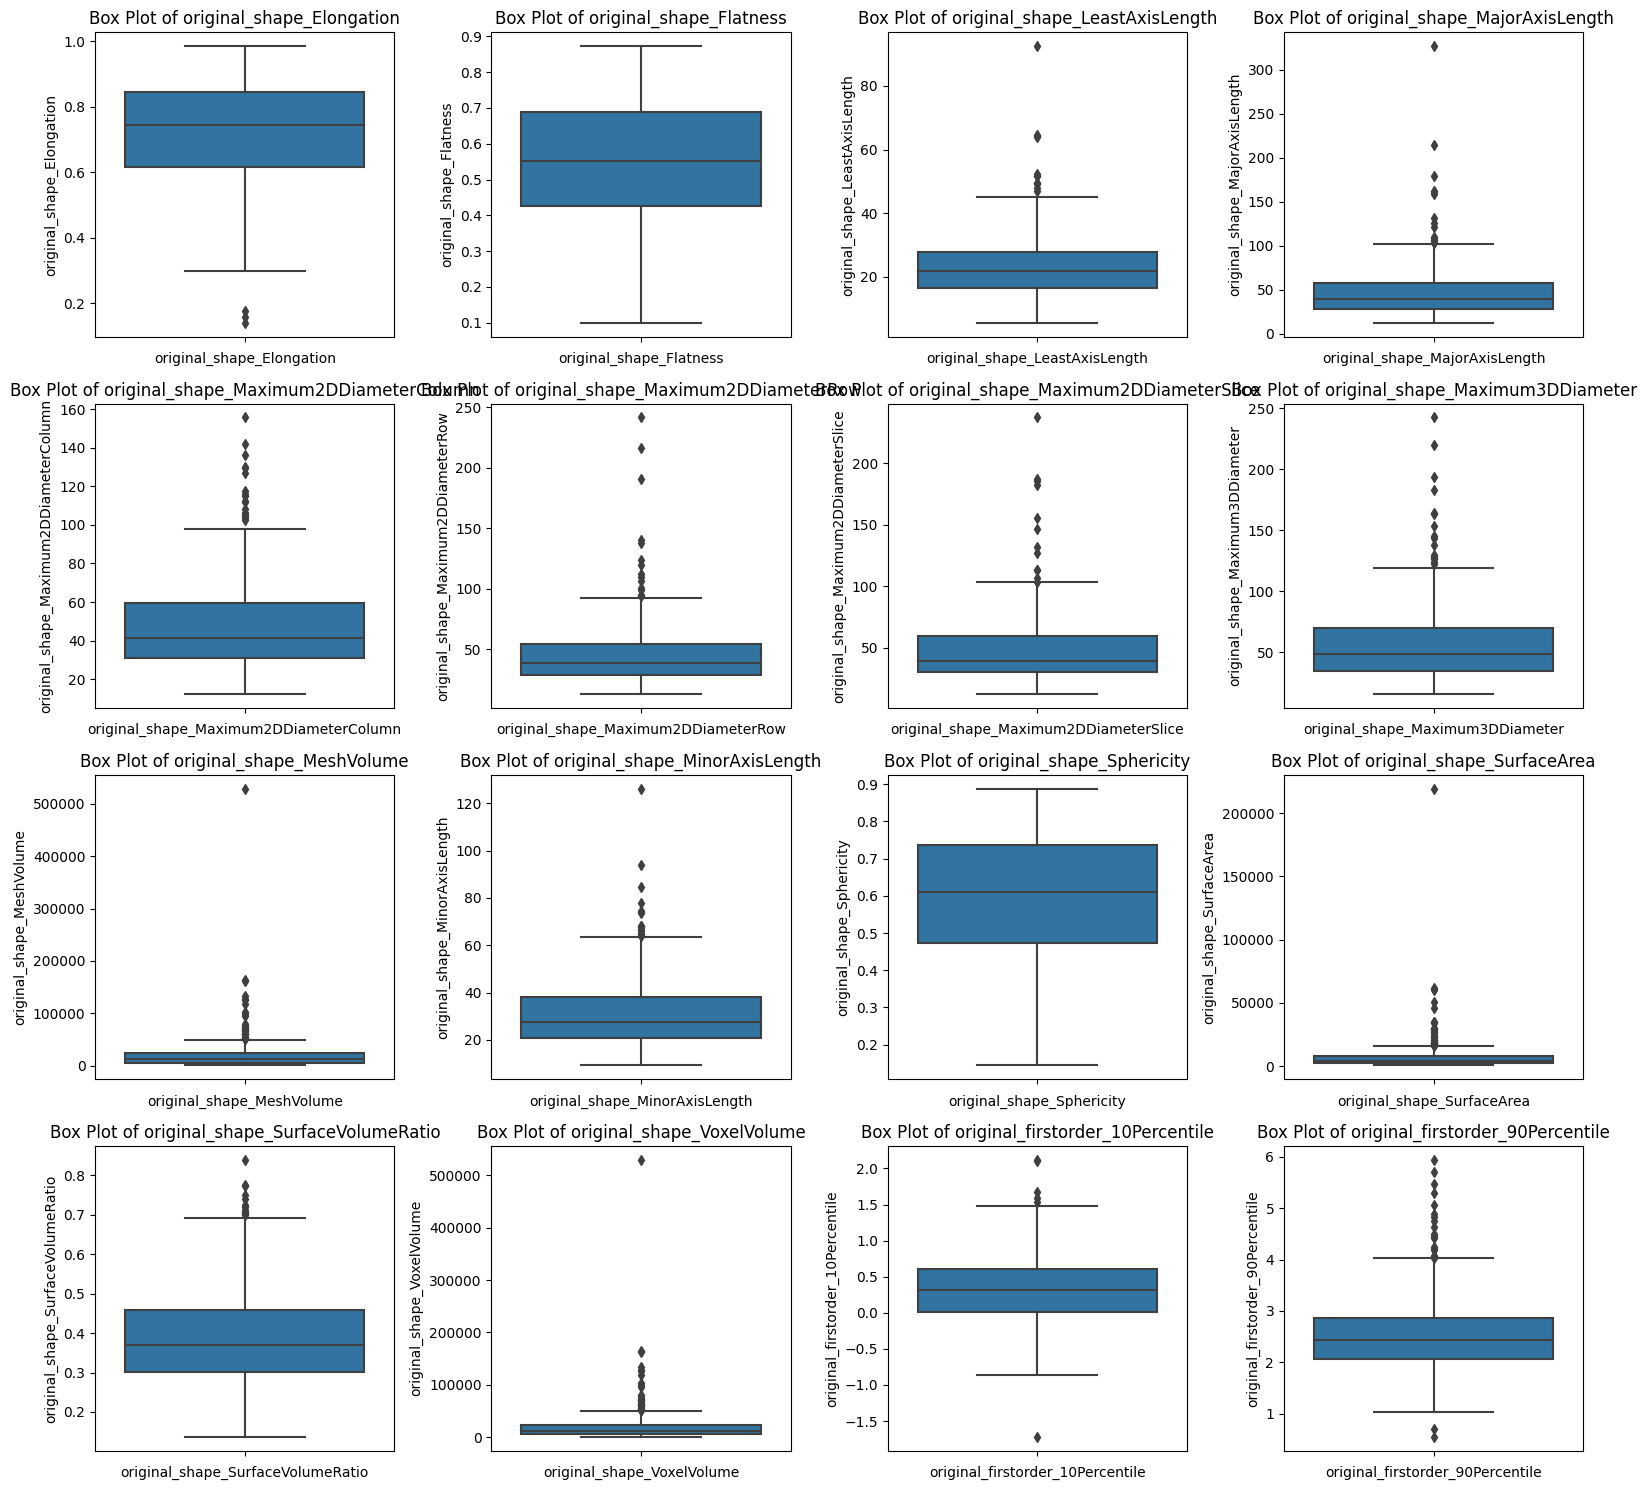

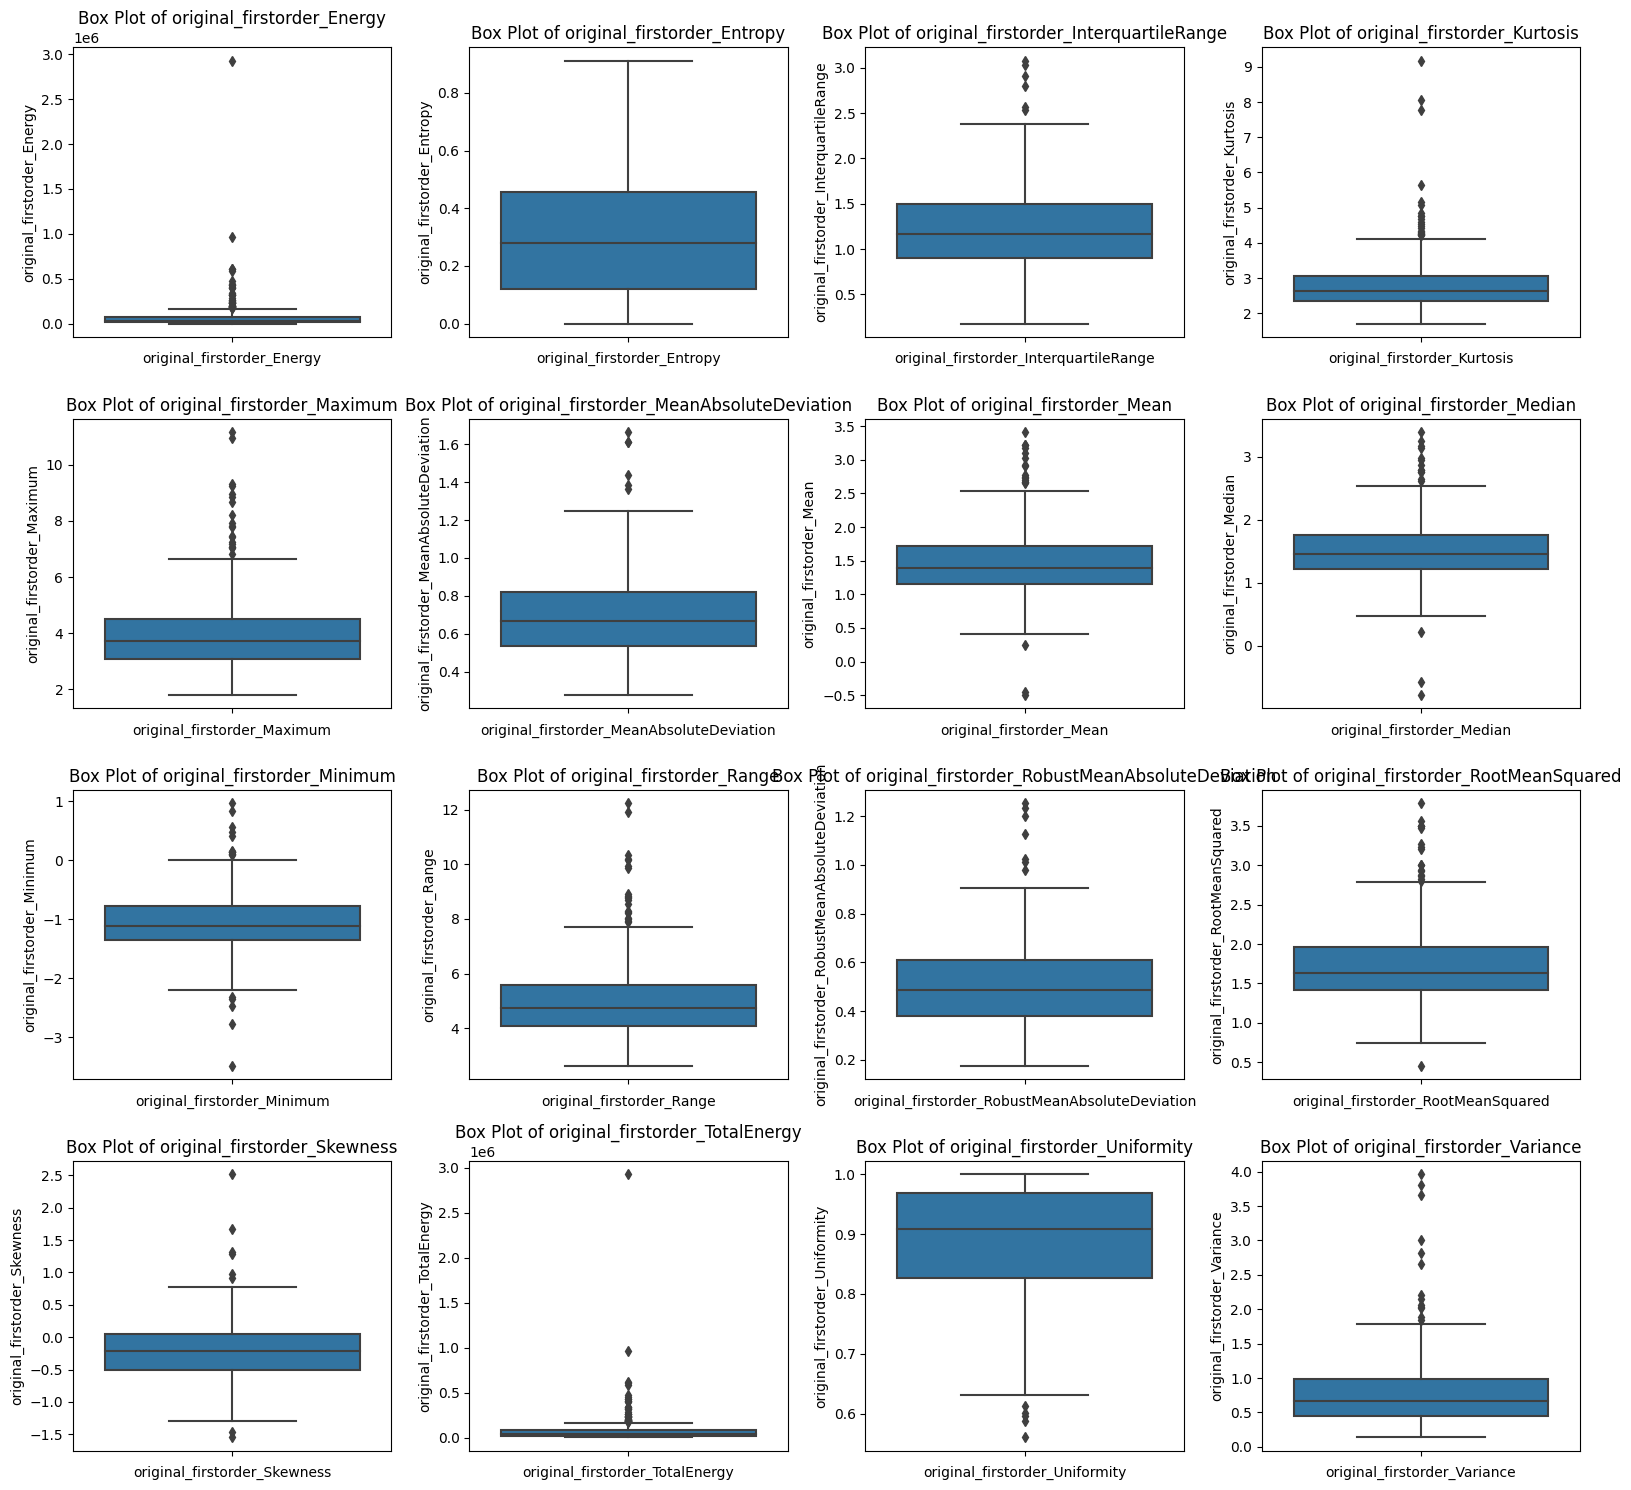

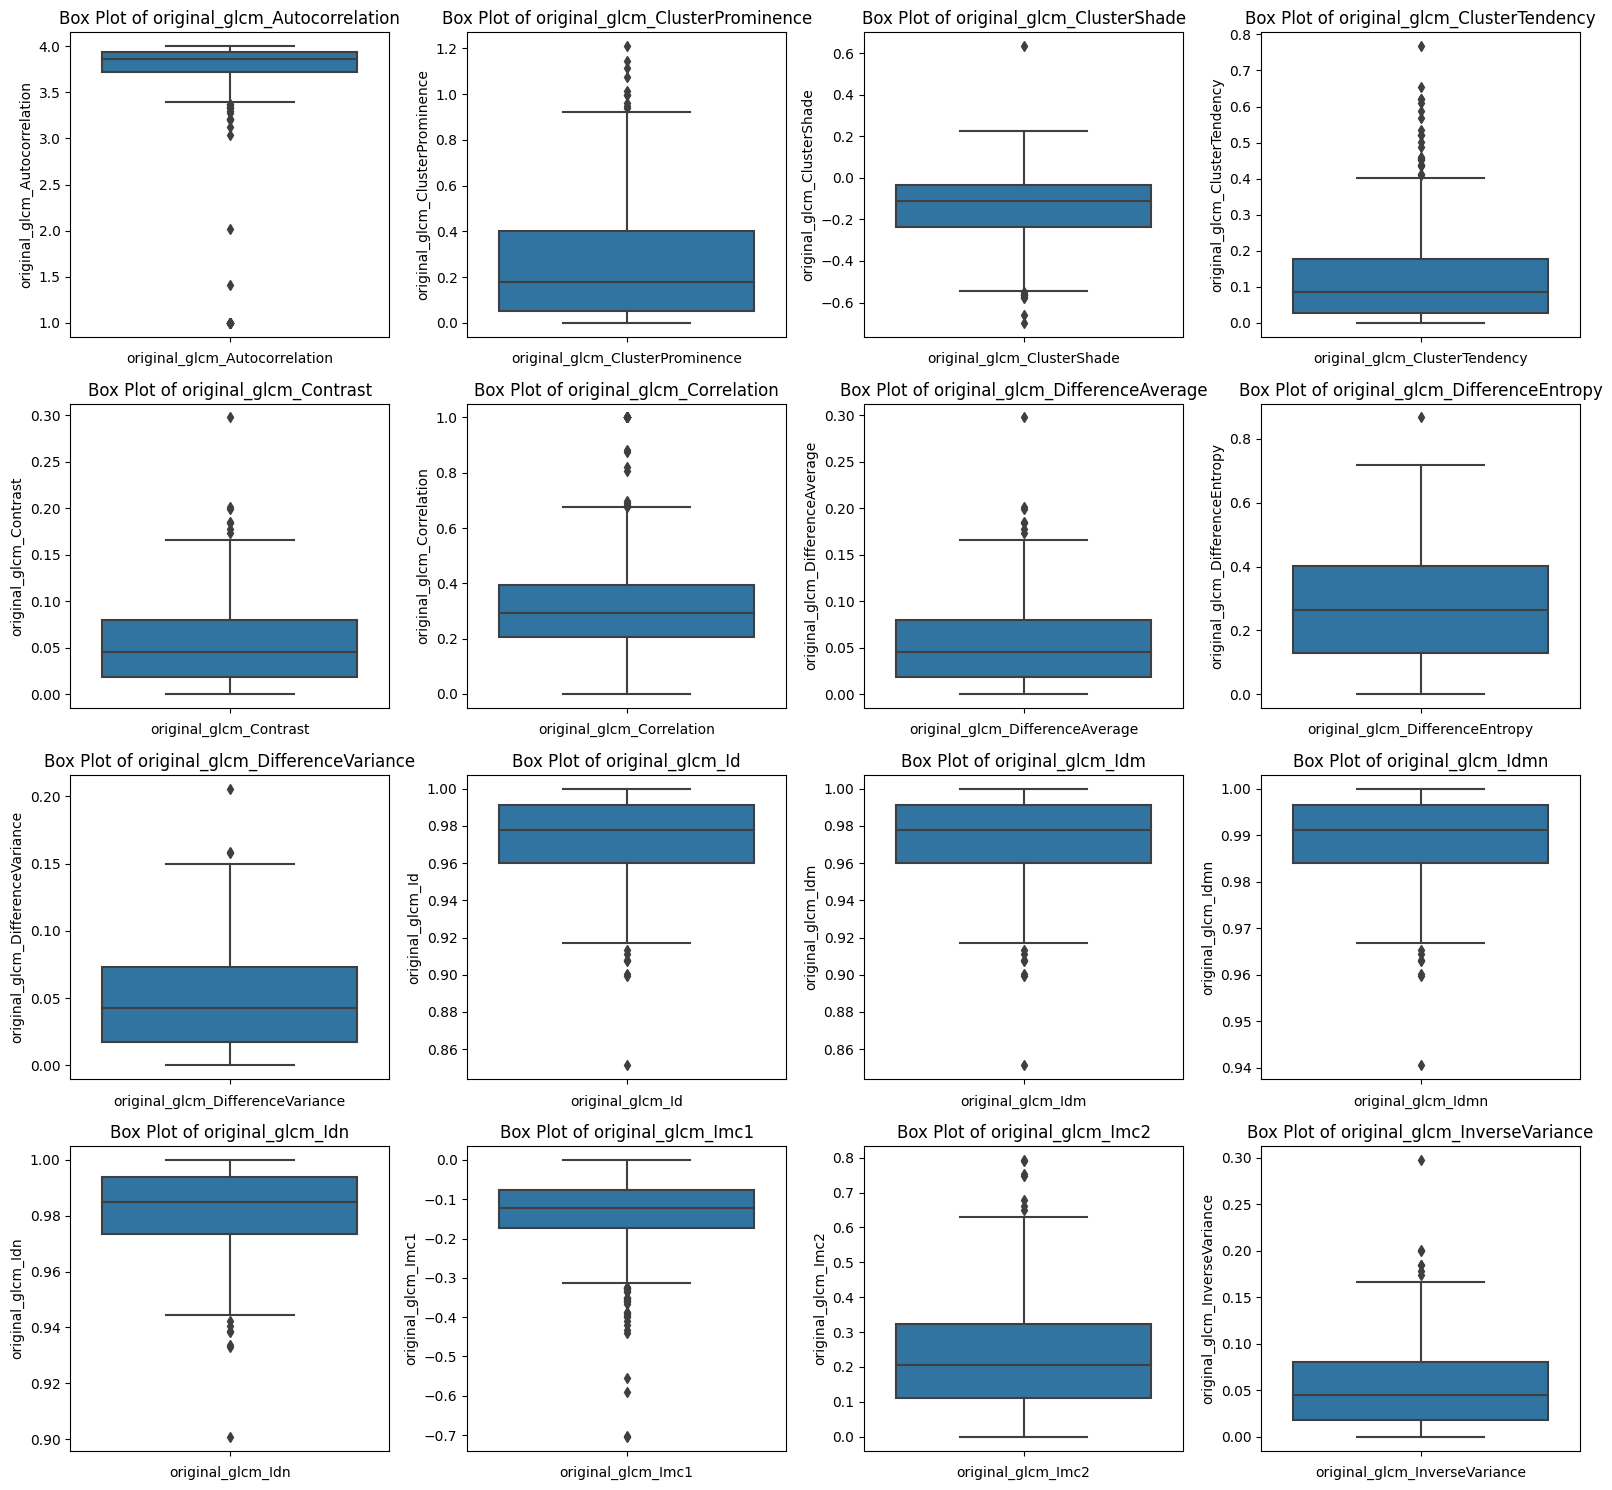

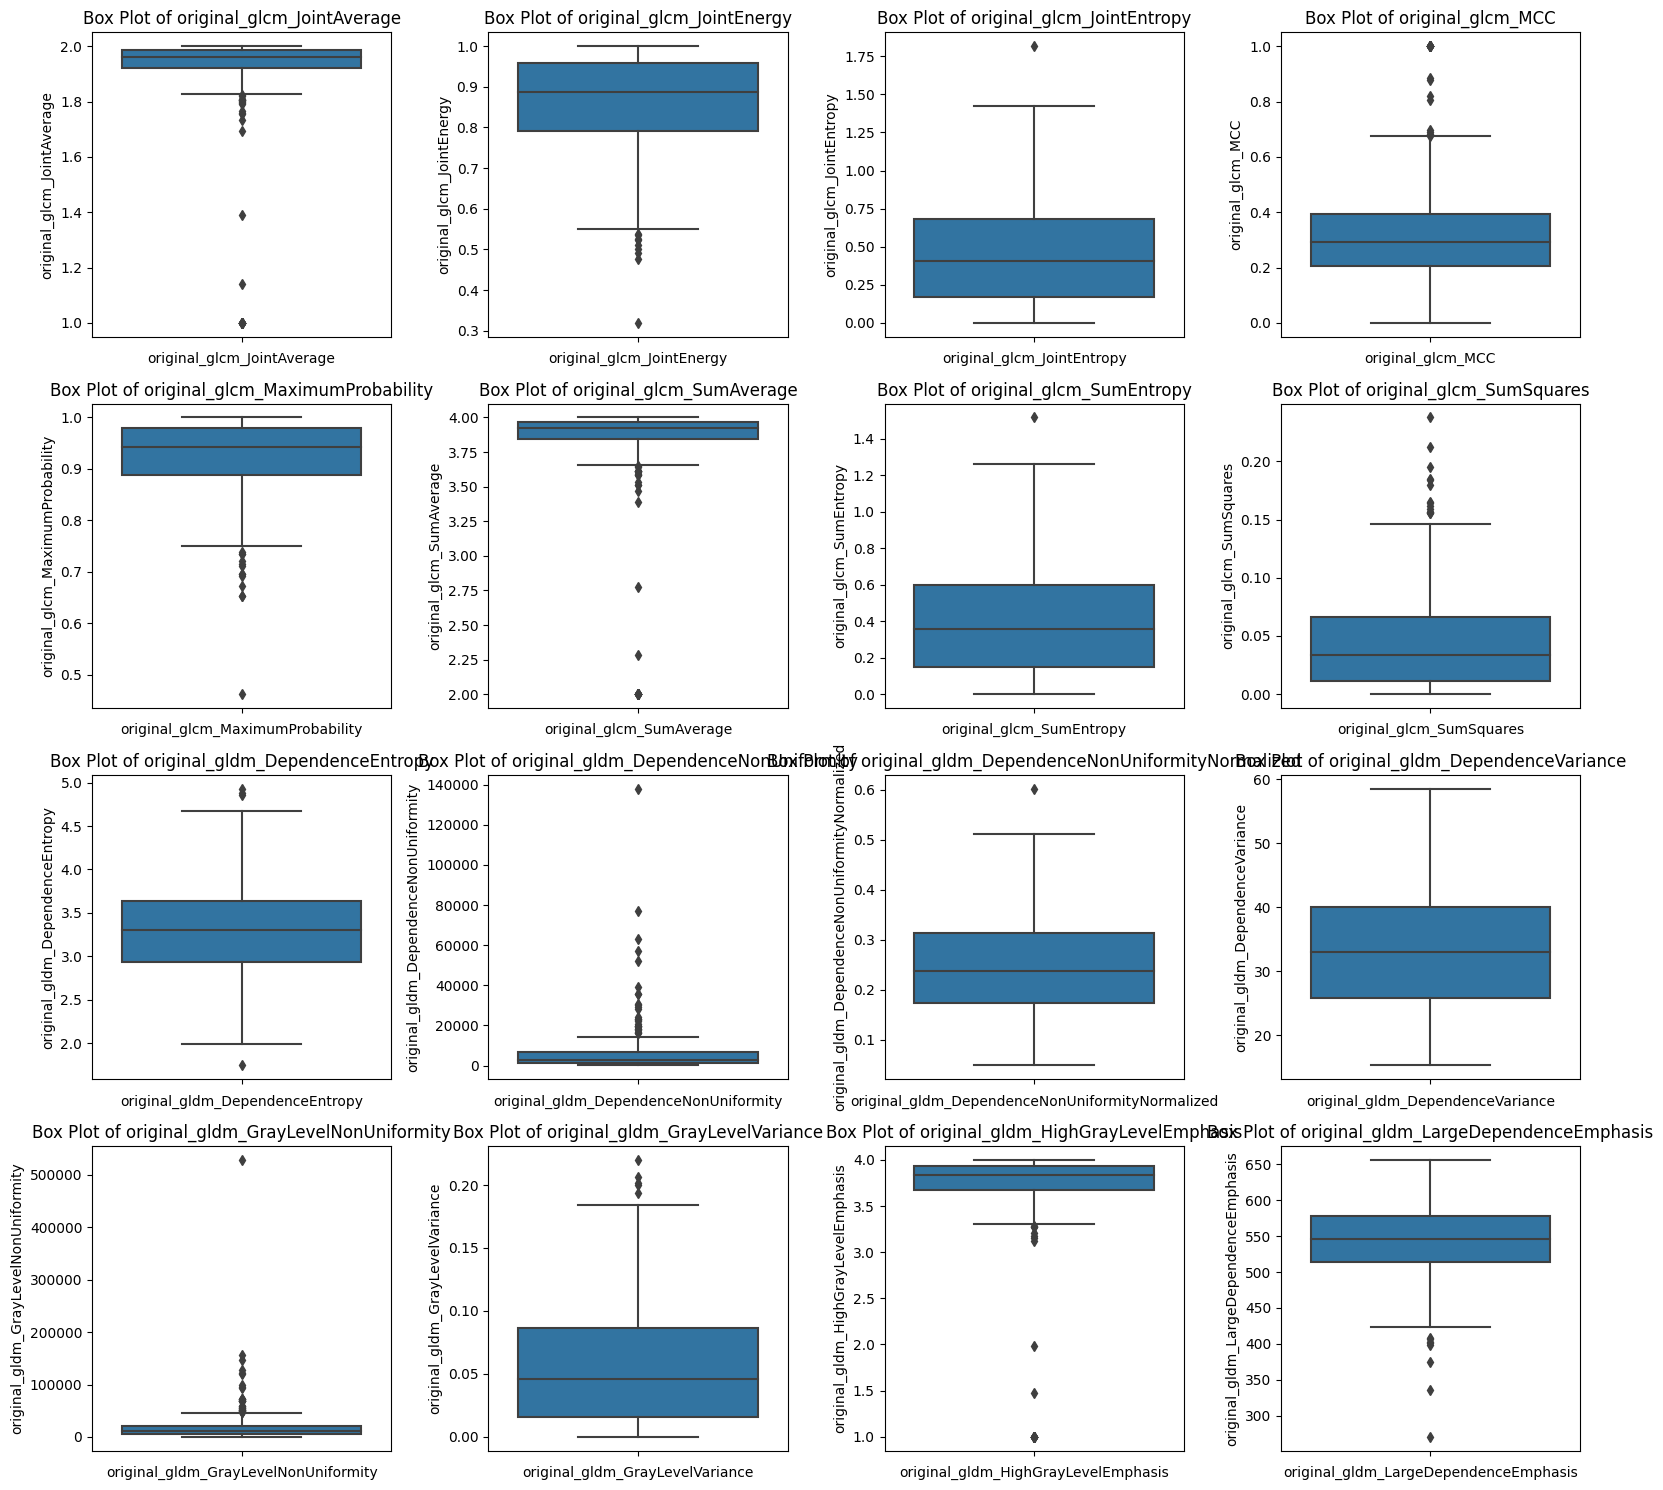

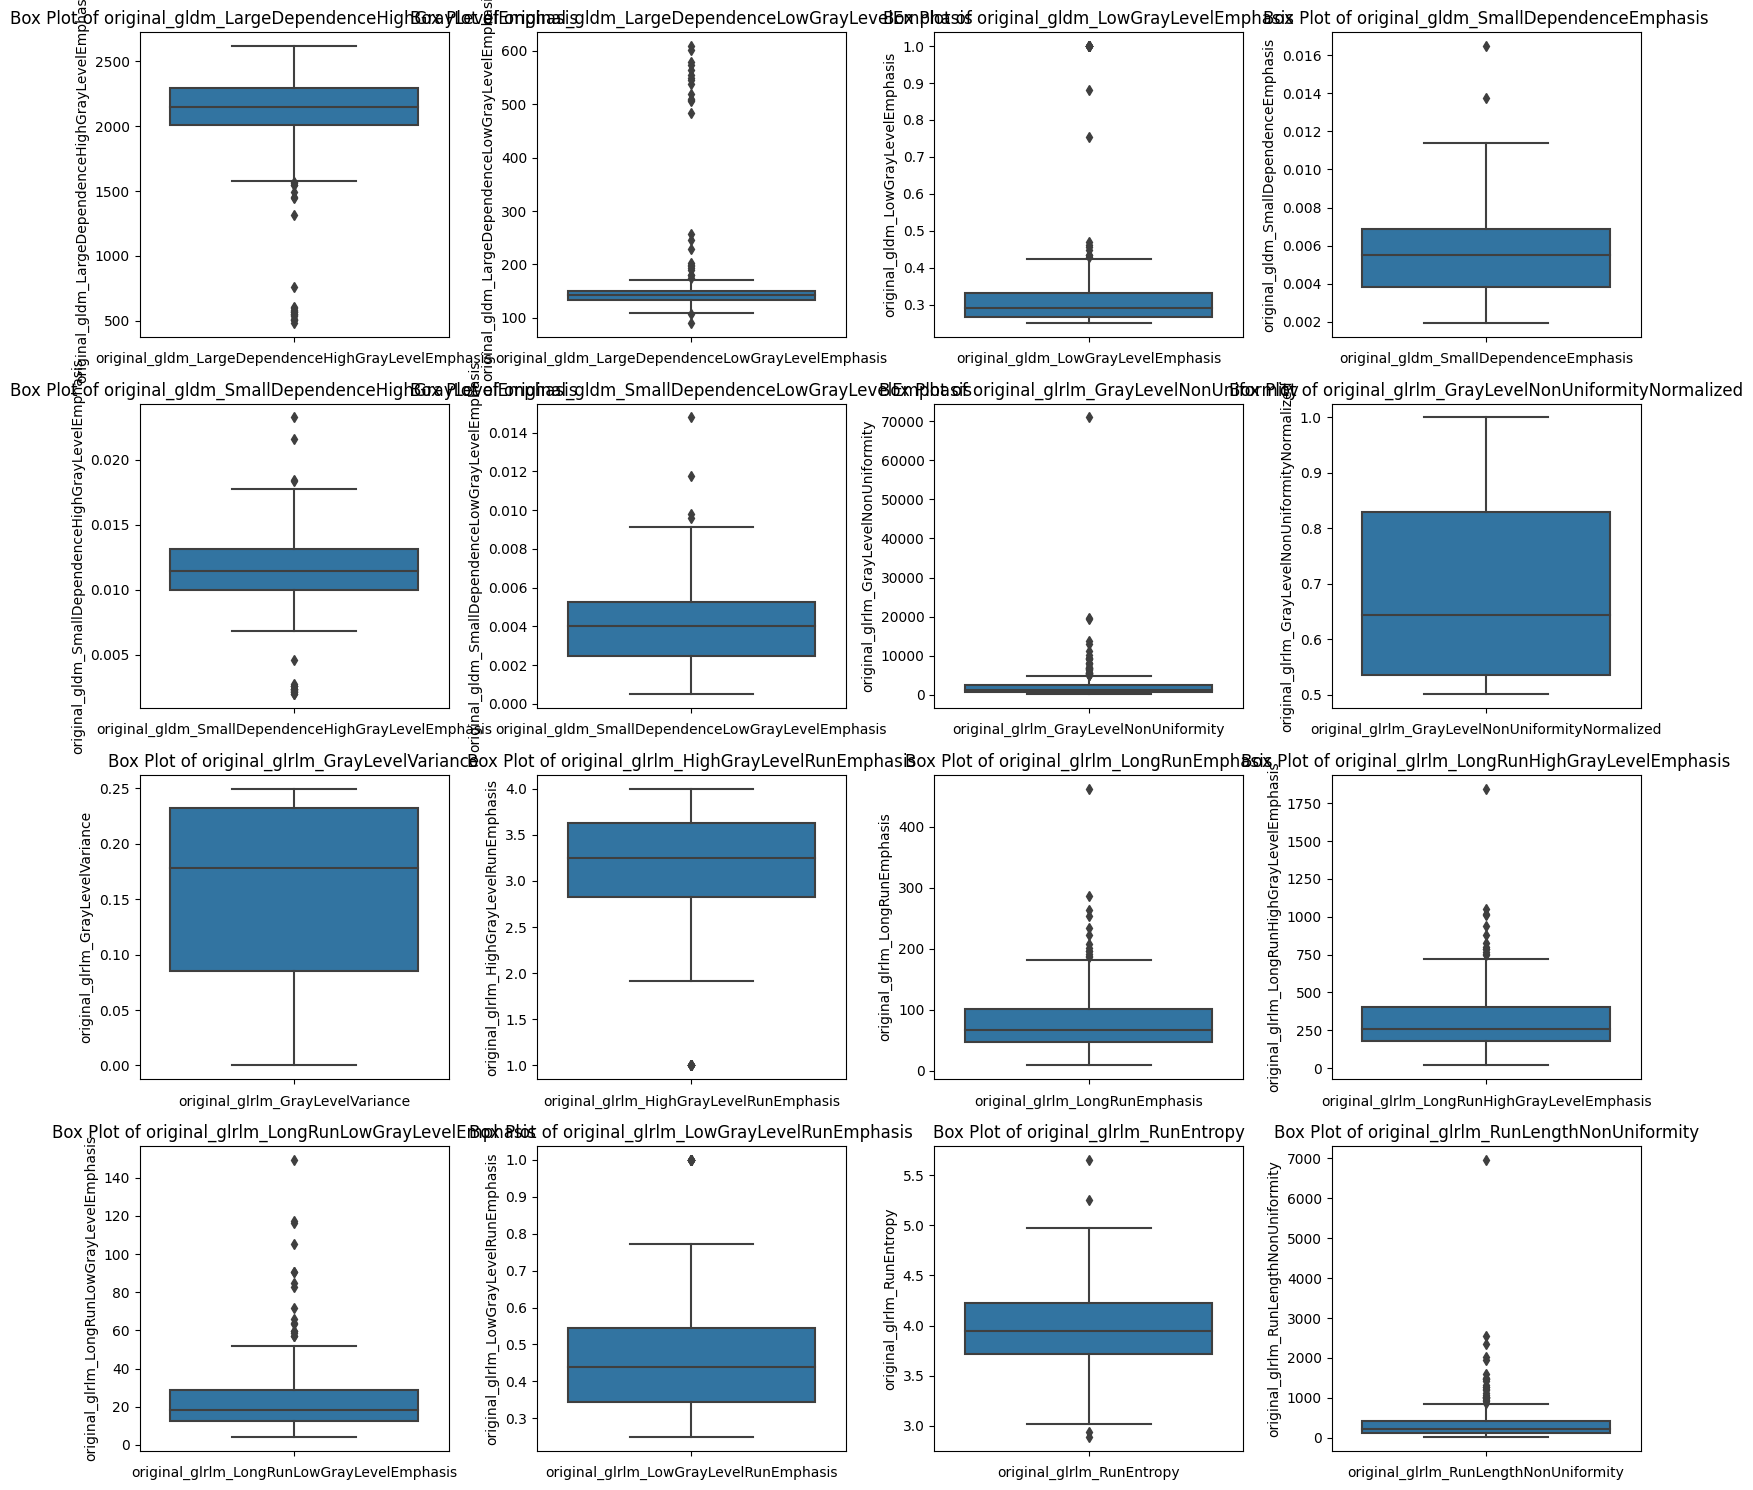

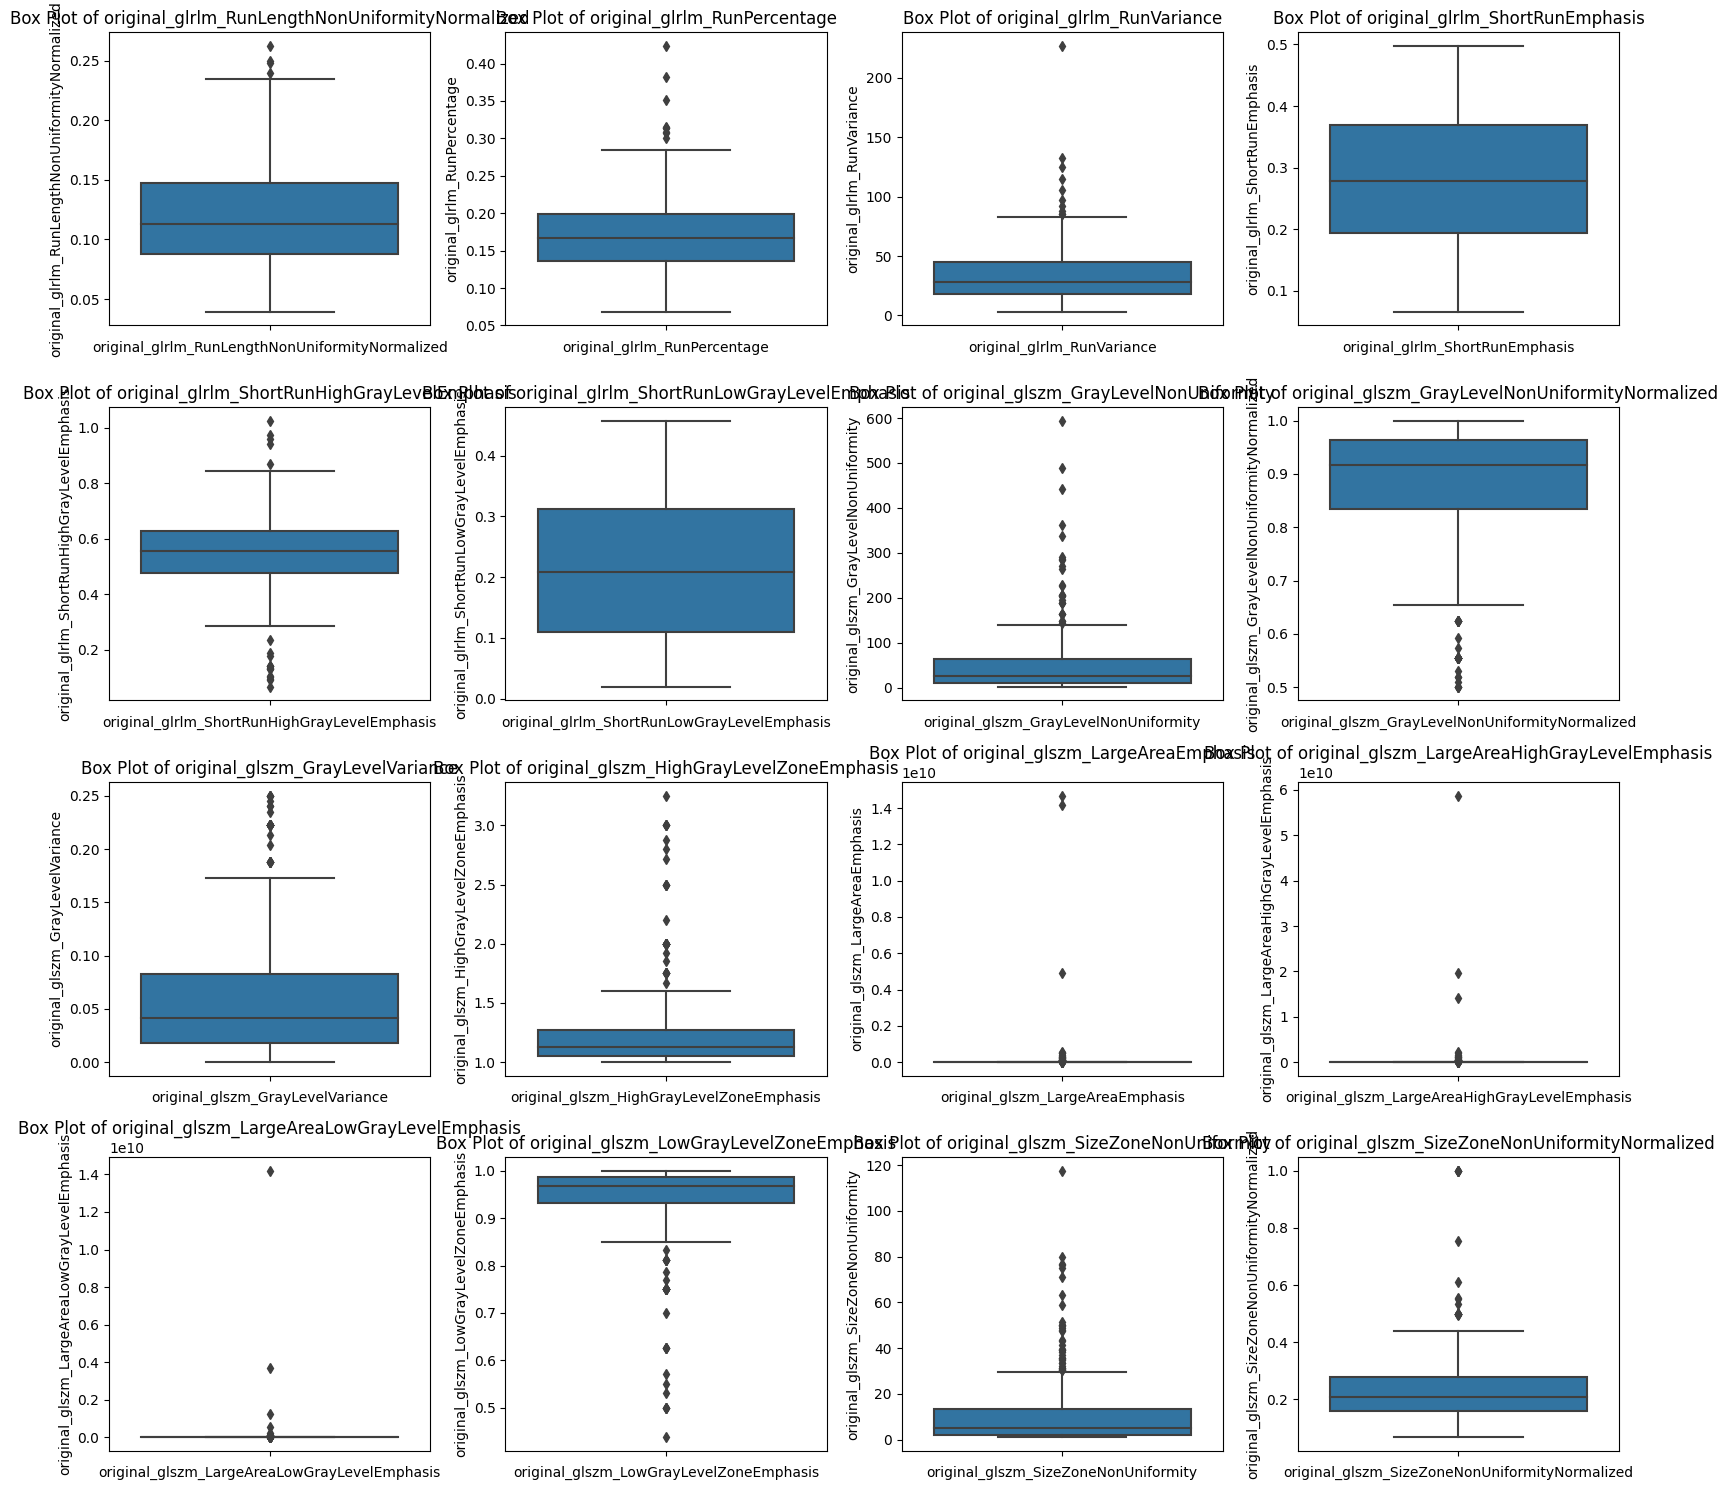

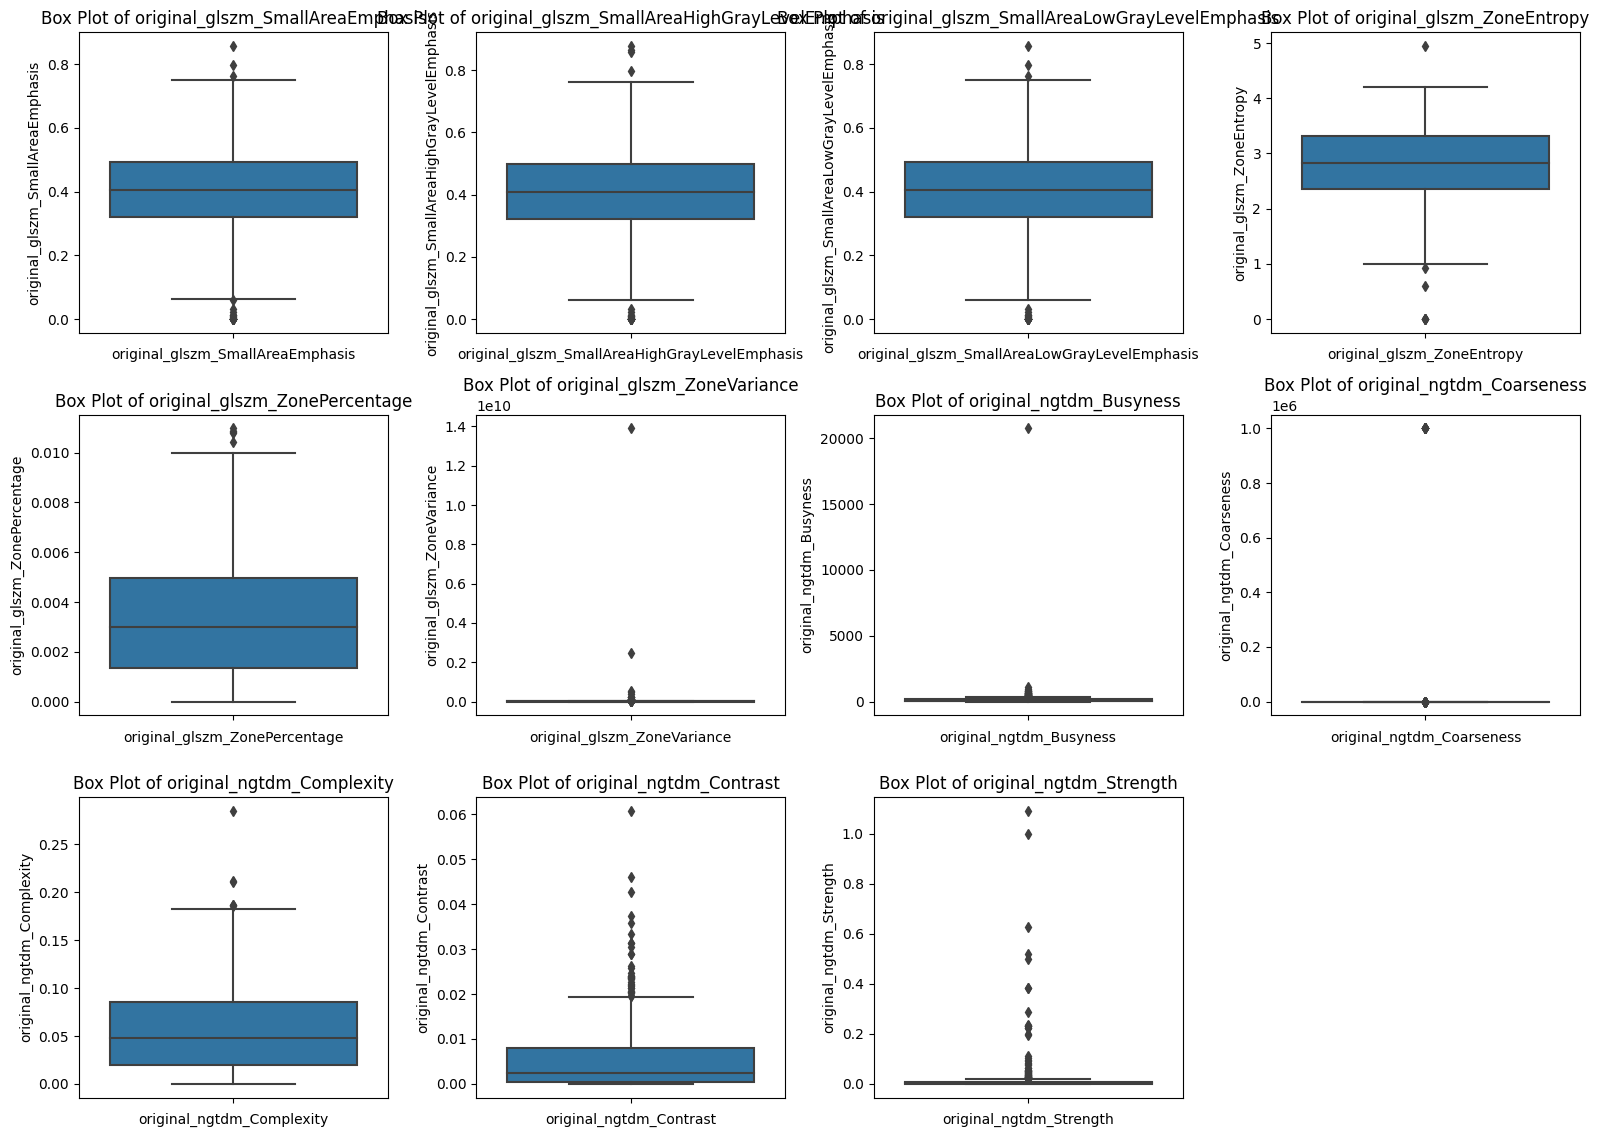

In [ ]:
# Select continuous variables
continuous_vars = X_train.iloc[:, 10:].columns

# Number of plots per figure
plots_per_figure = 16

# Calculate the number of required figures
num_figures = math.ceil(len(continuous_vars) / plots_per_figure)

for fig_index in range(num_figures):
    plt.figure(figsize=(16, 15))
    start_index = fig_index * plots_per_figure
    end_index = min(start_index + plots_per_figure, len(continuous_vars))

    for i, var in enumerate(continuous_vars[start_index:end_index], 1):
        plt.subplot(4, 4, i)
        sns.boxplot(y=var, data=X_train)
        plt.title(f'Box Plot of {var}')
        plt.xlabel(var)

    plt.tight_layout()
    plt.show()

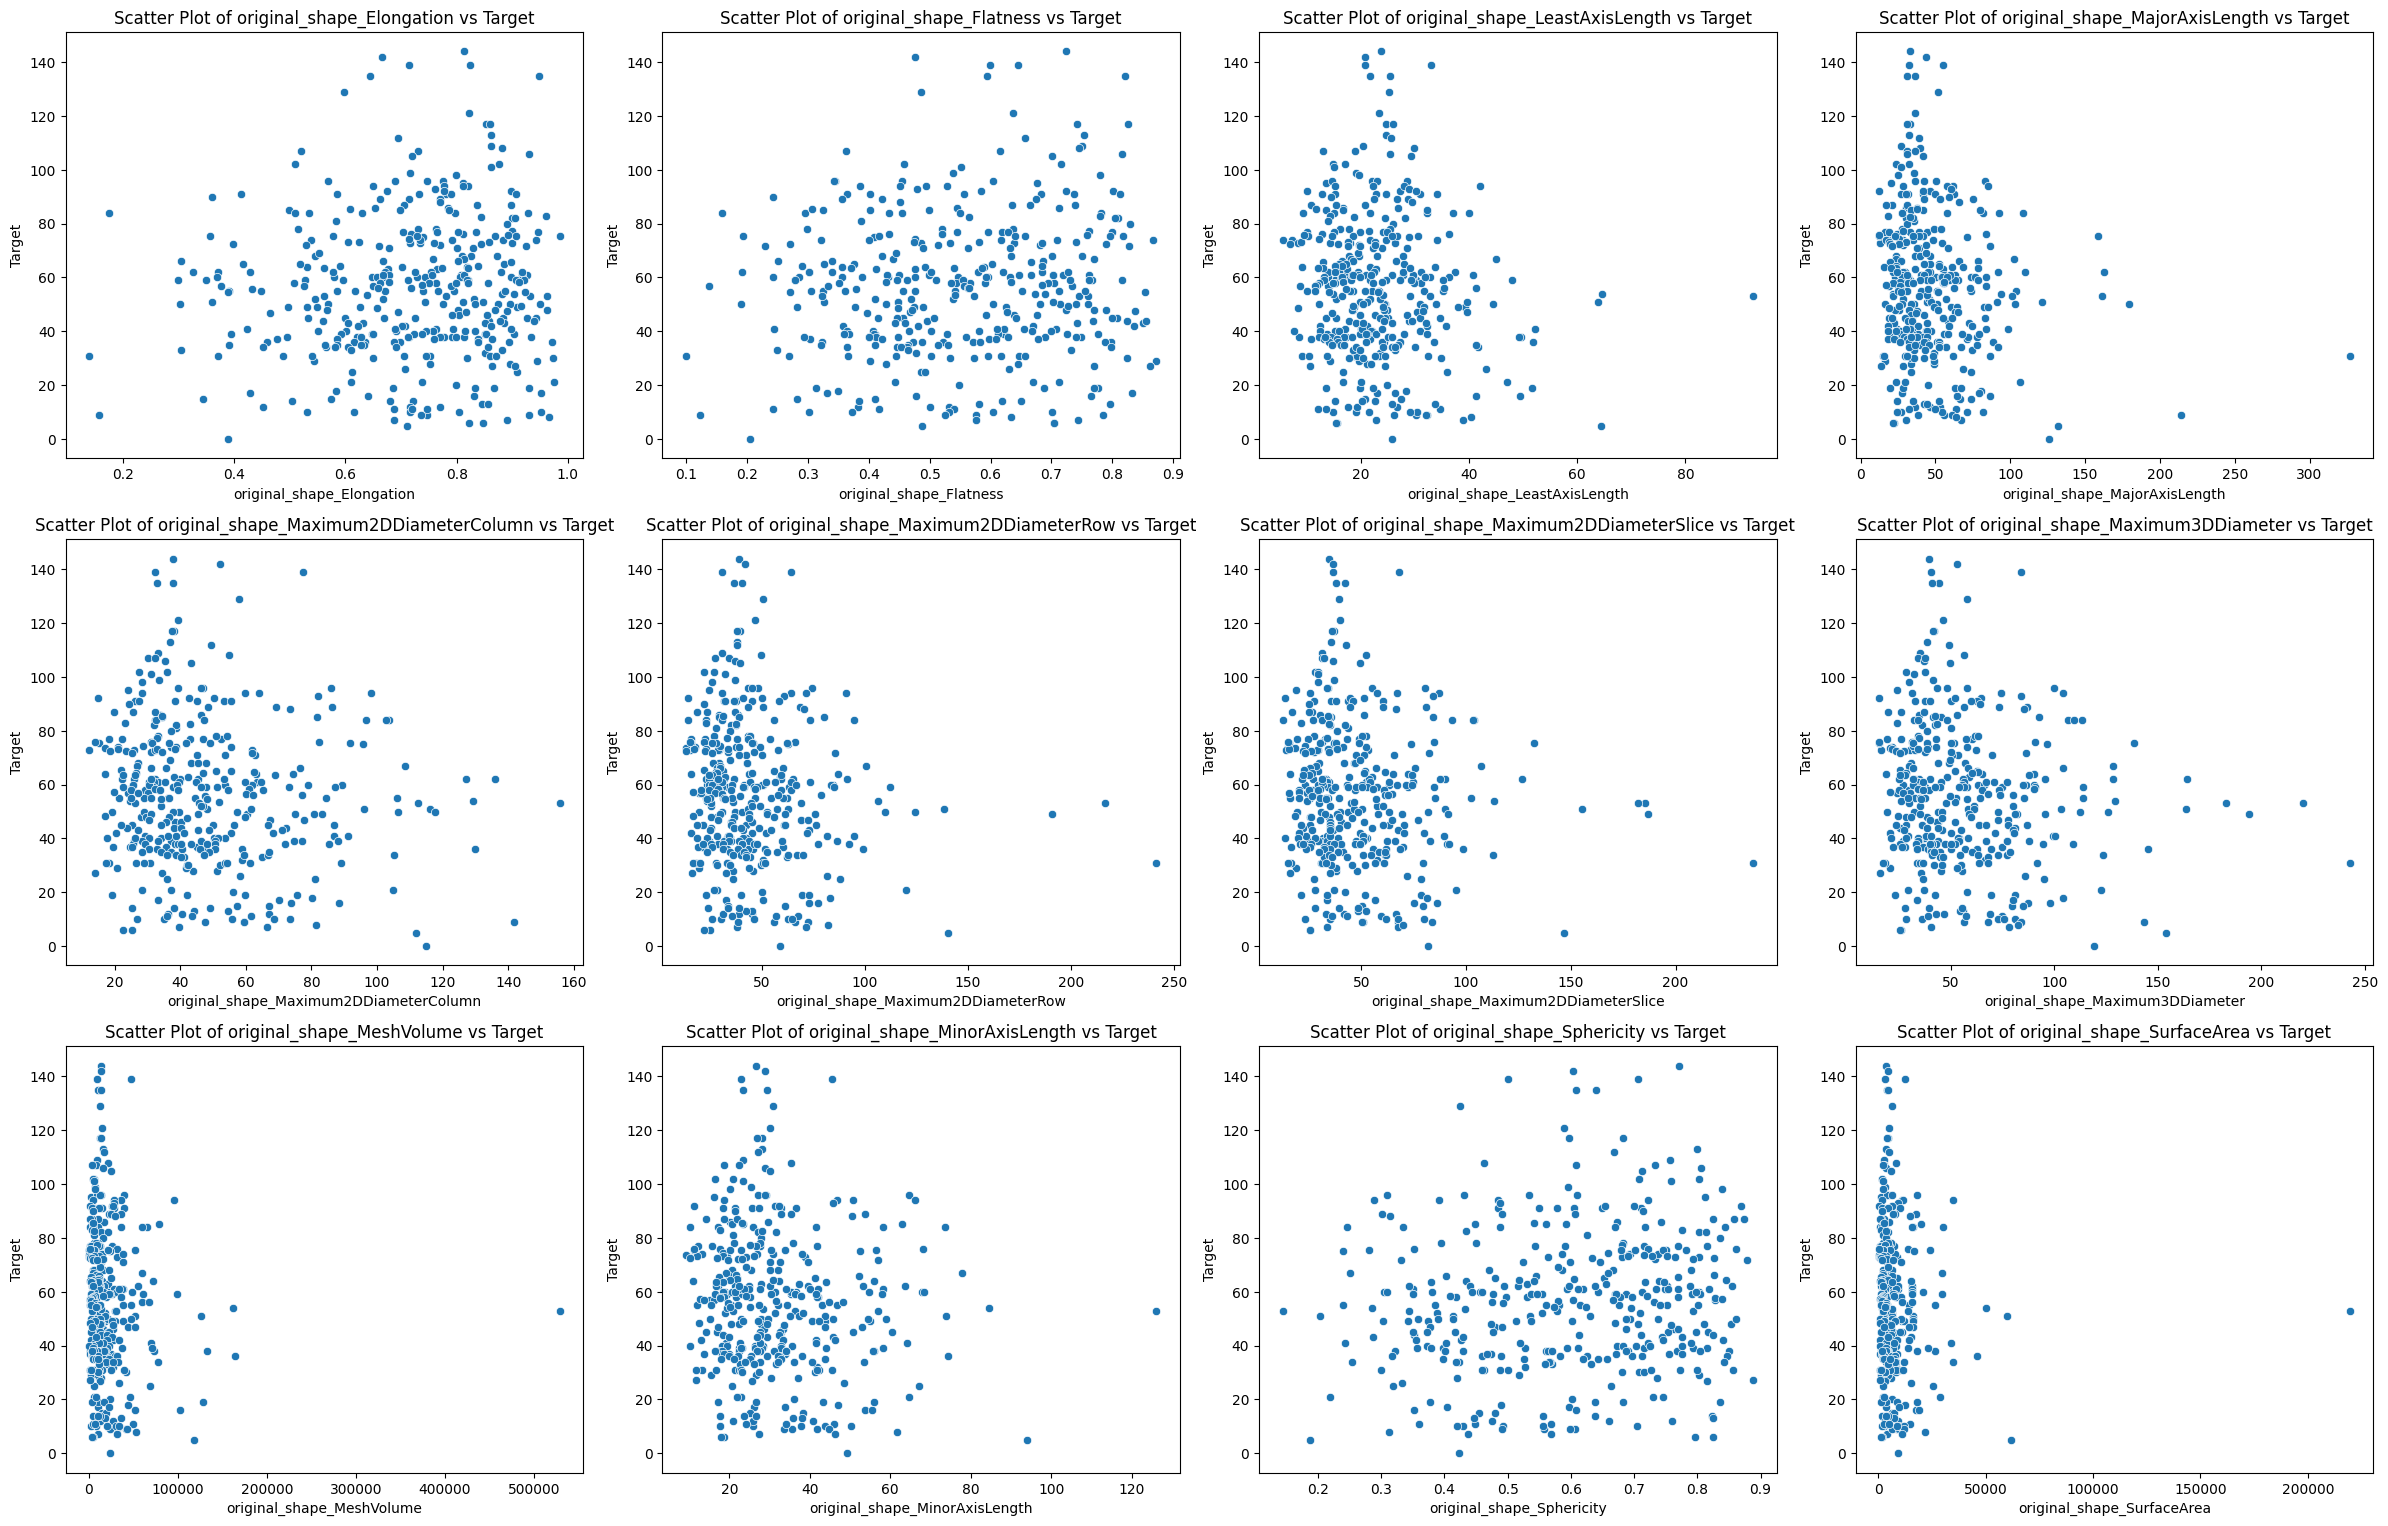

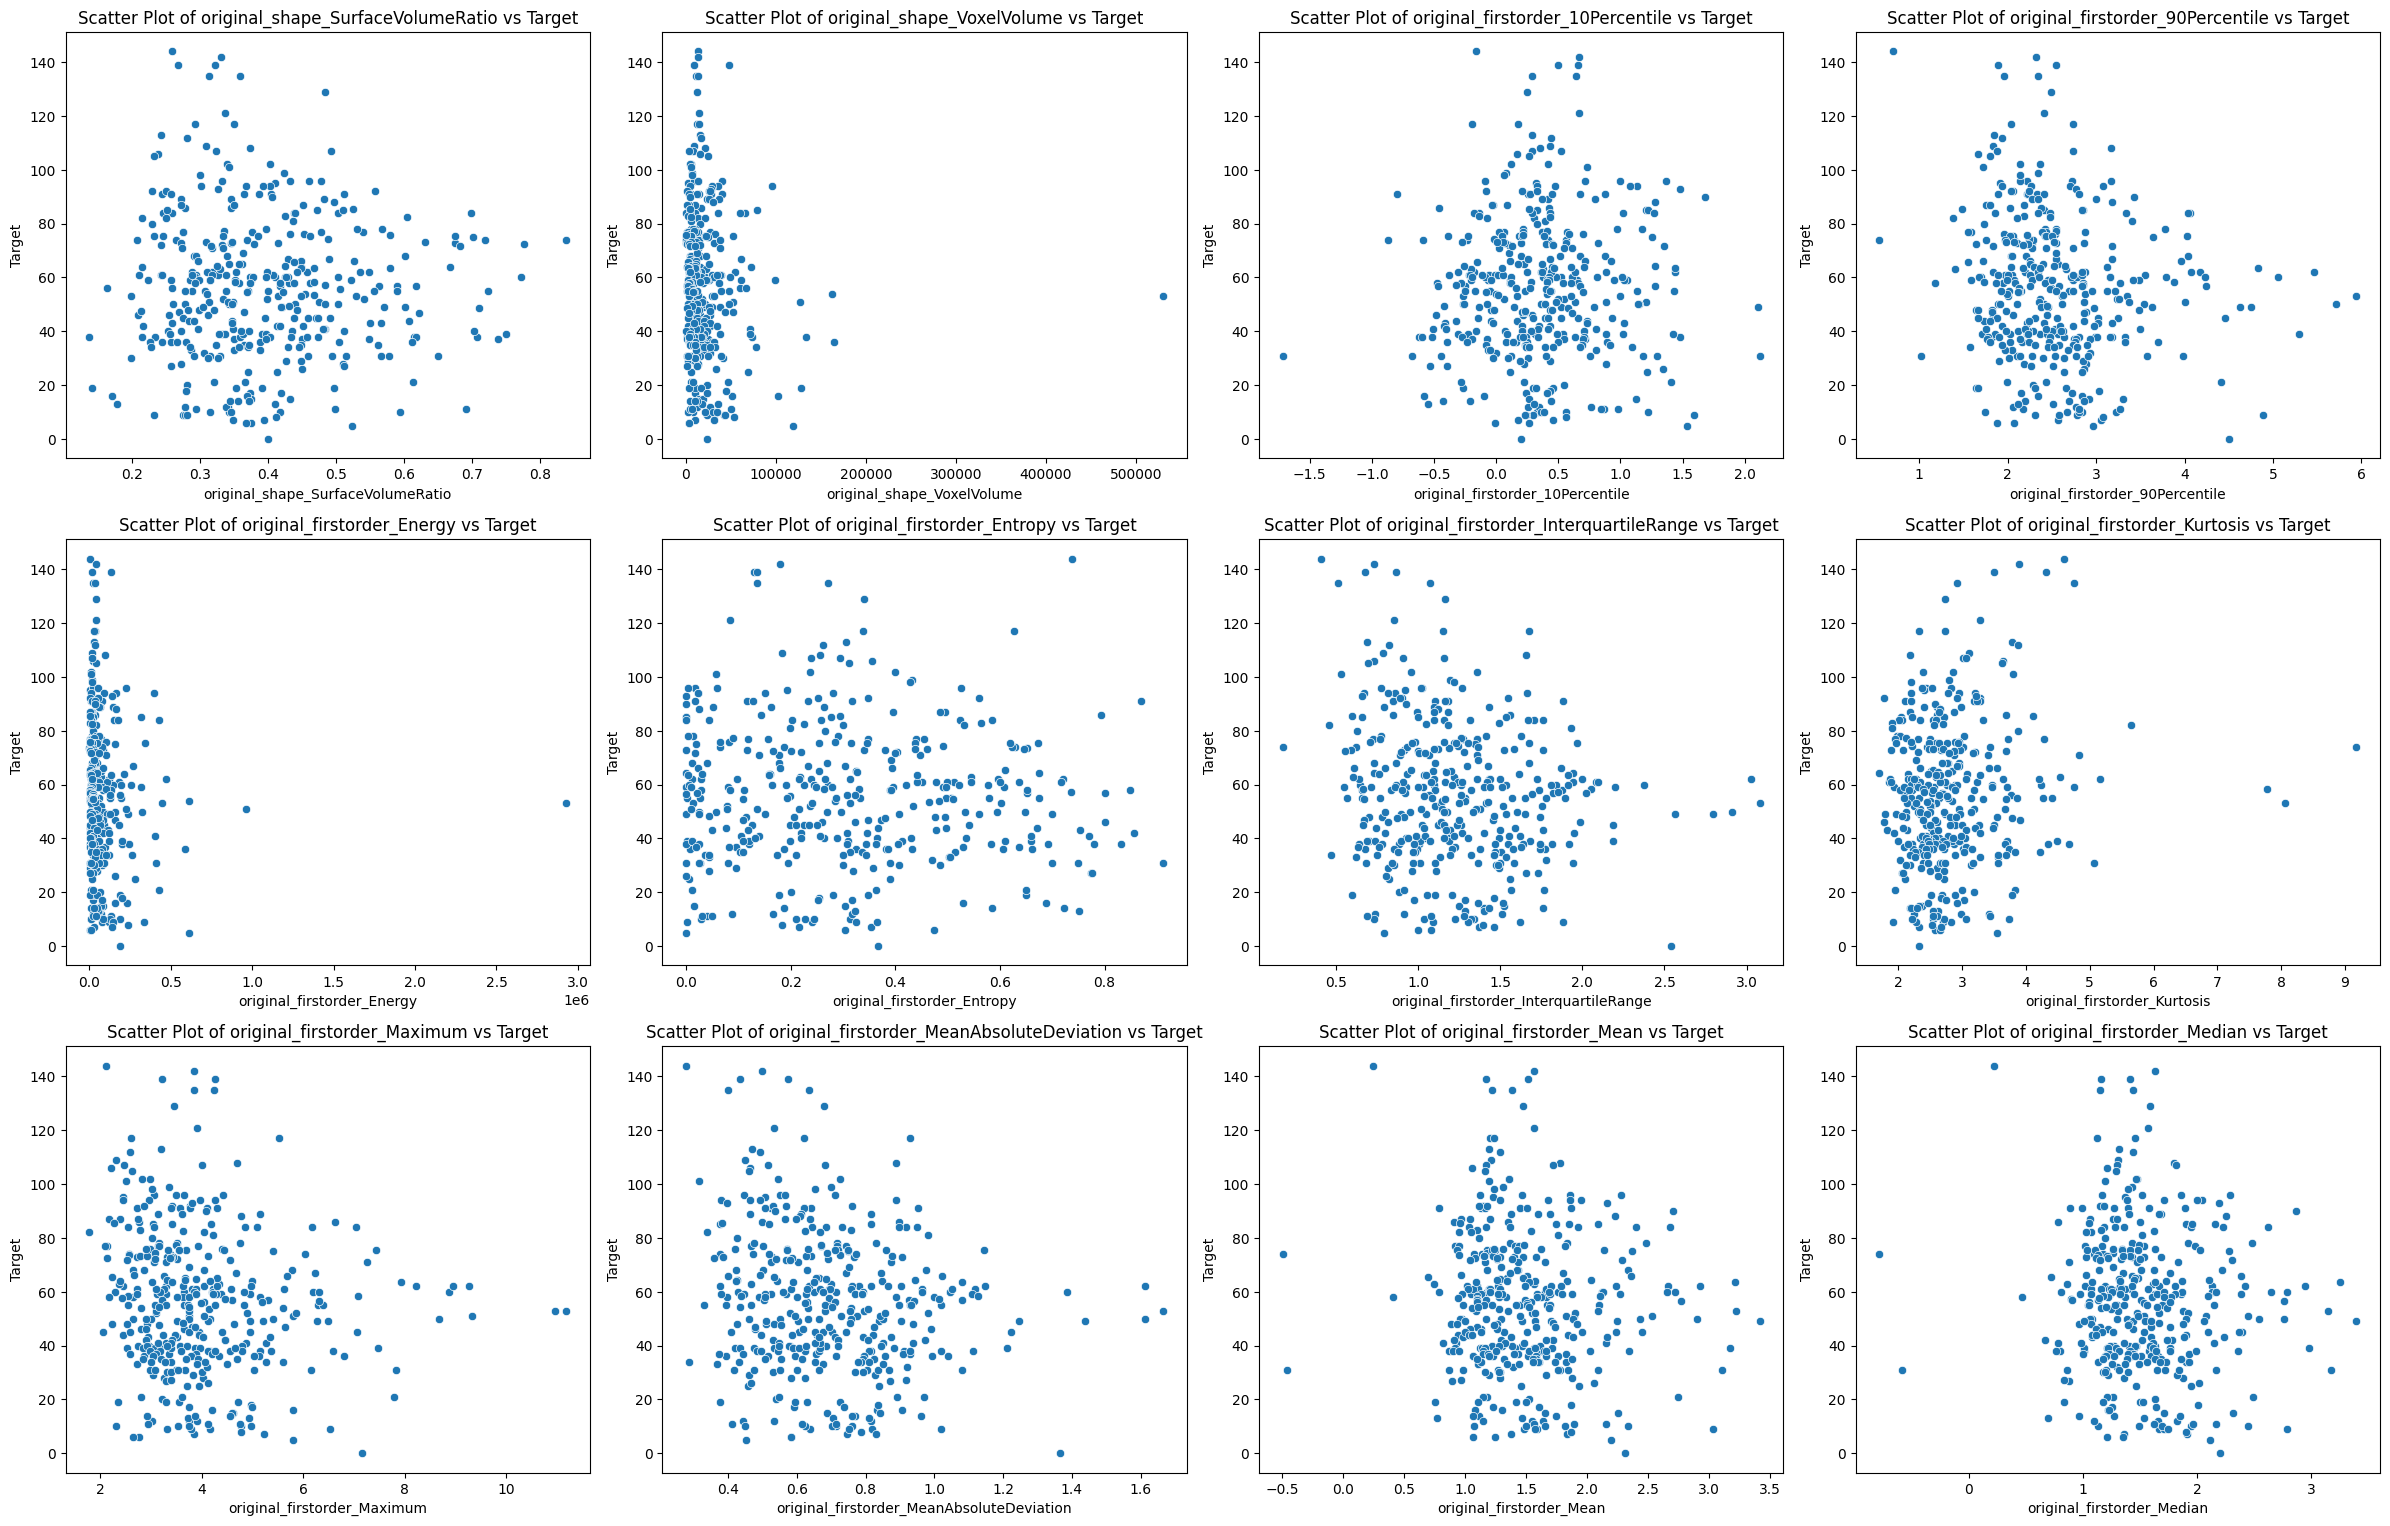

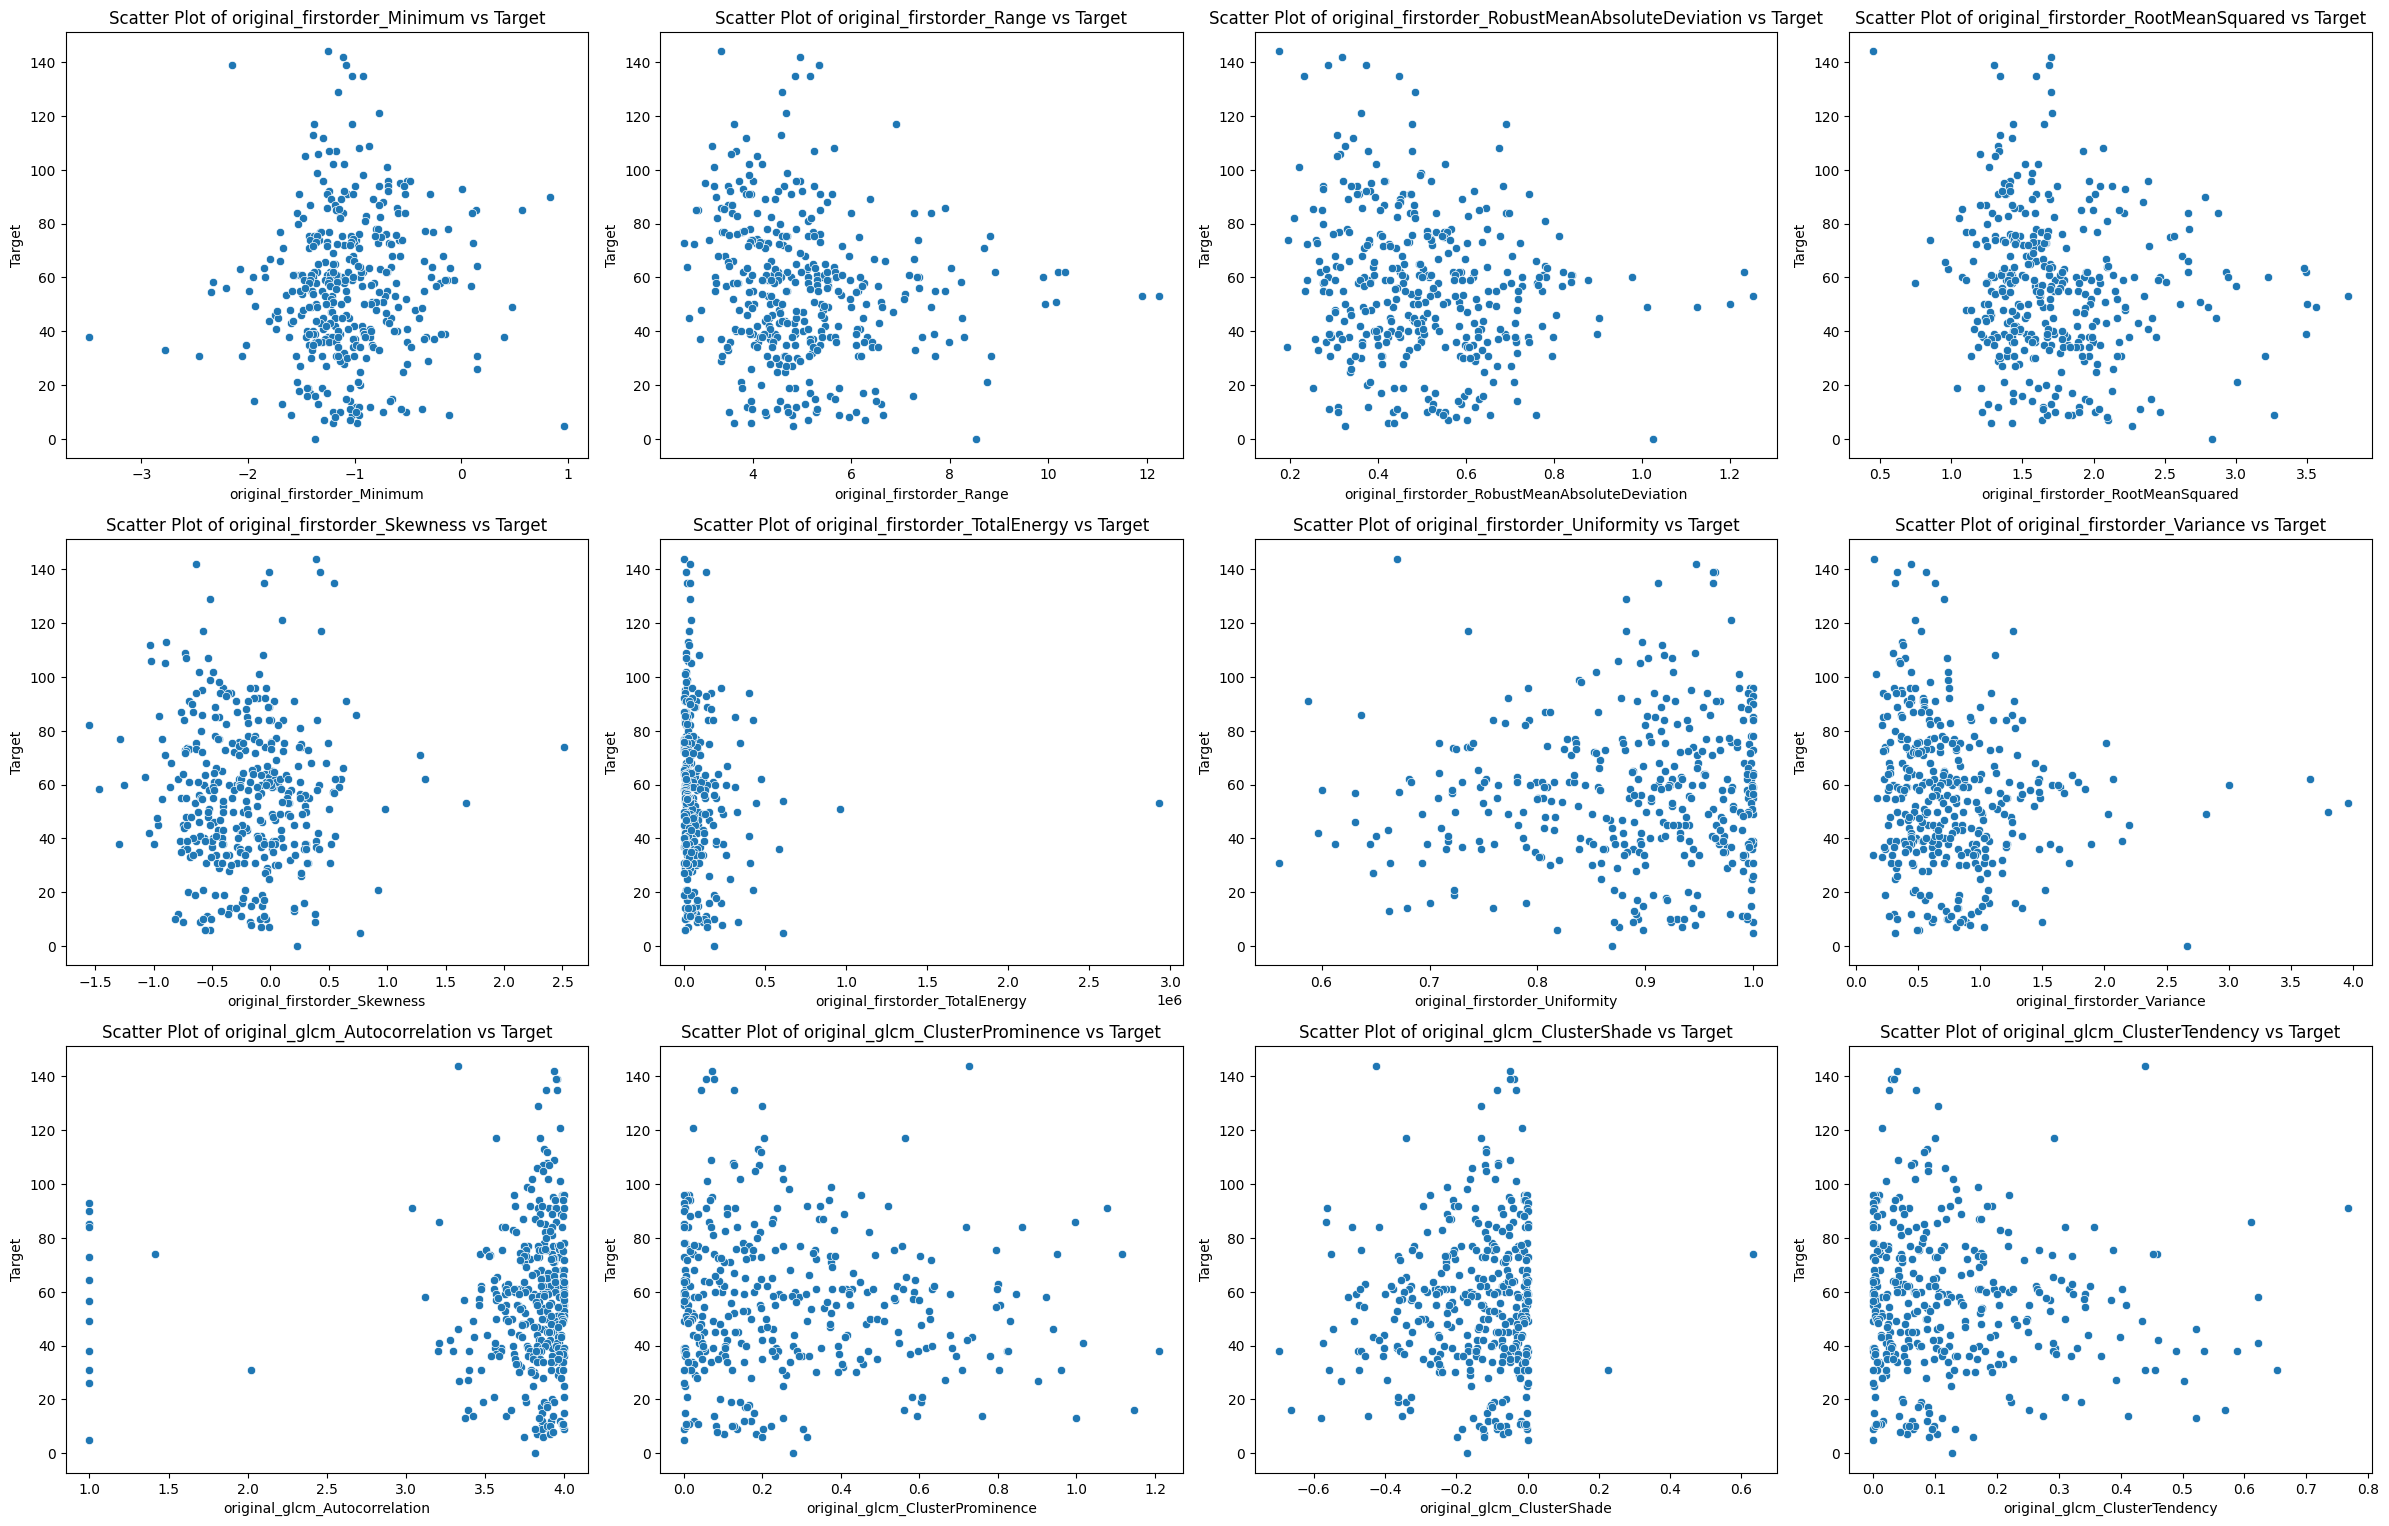

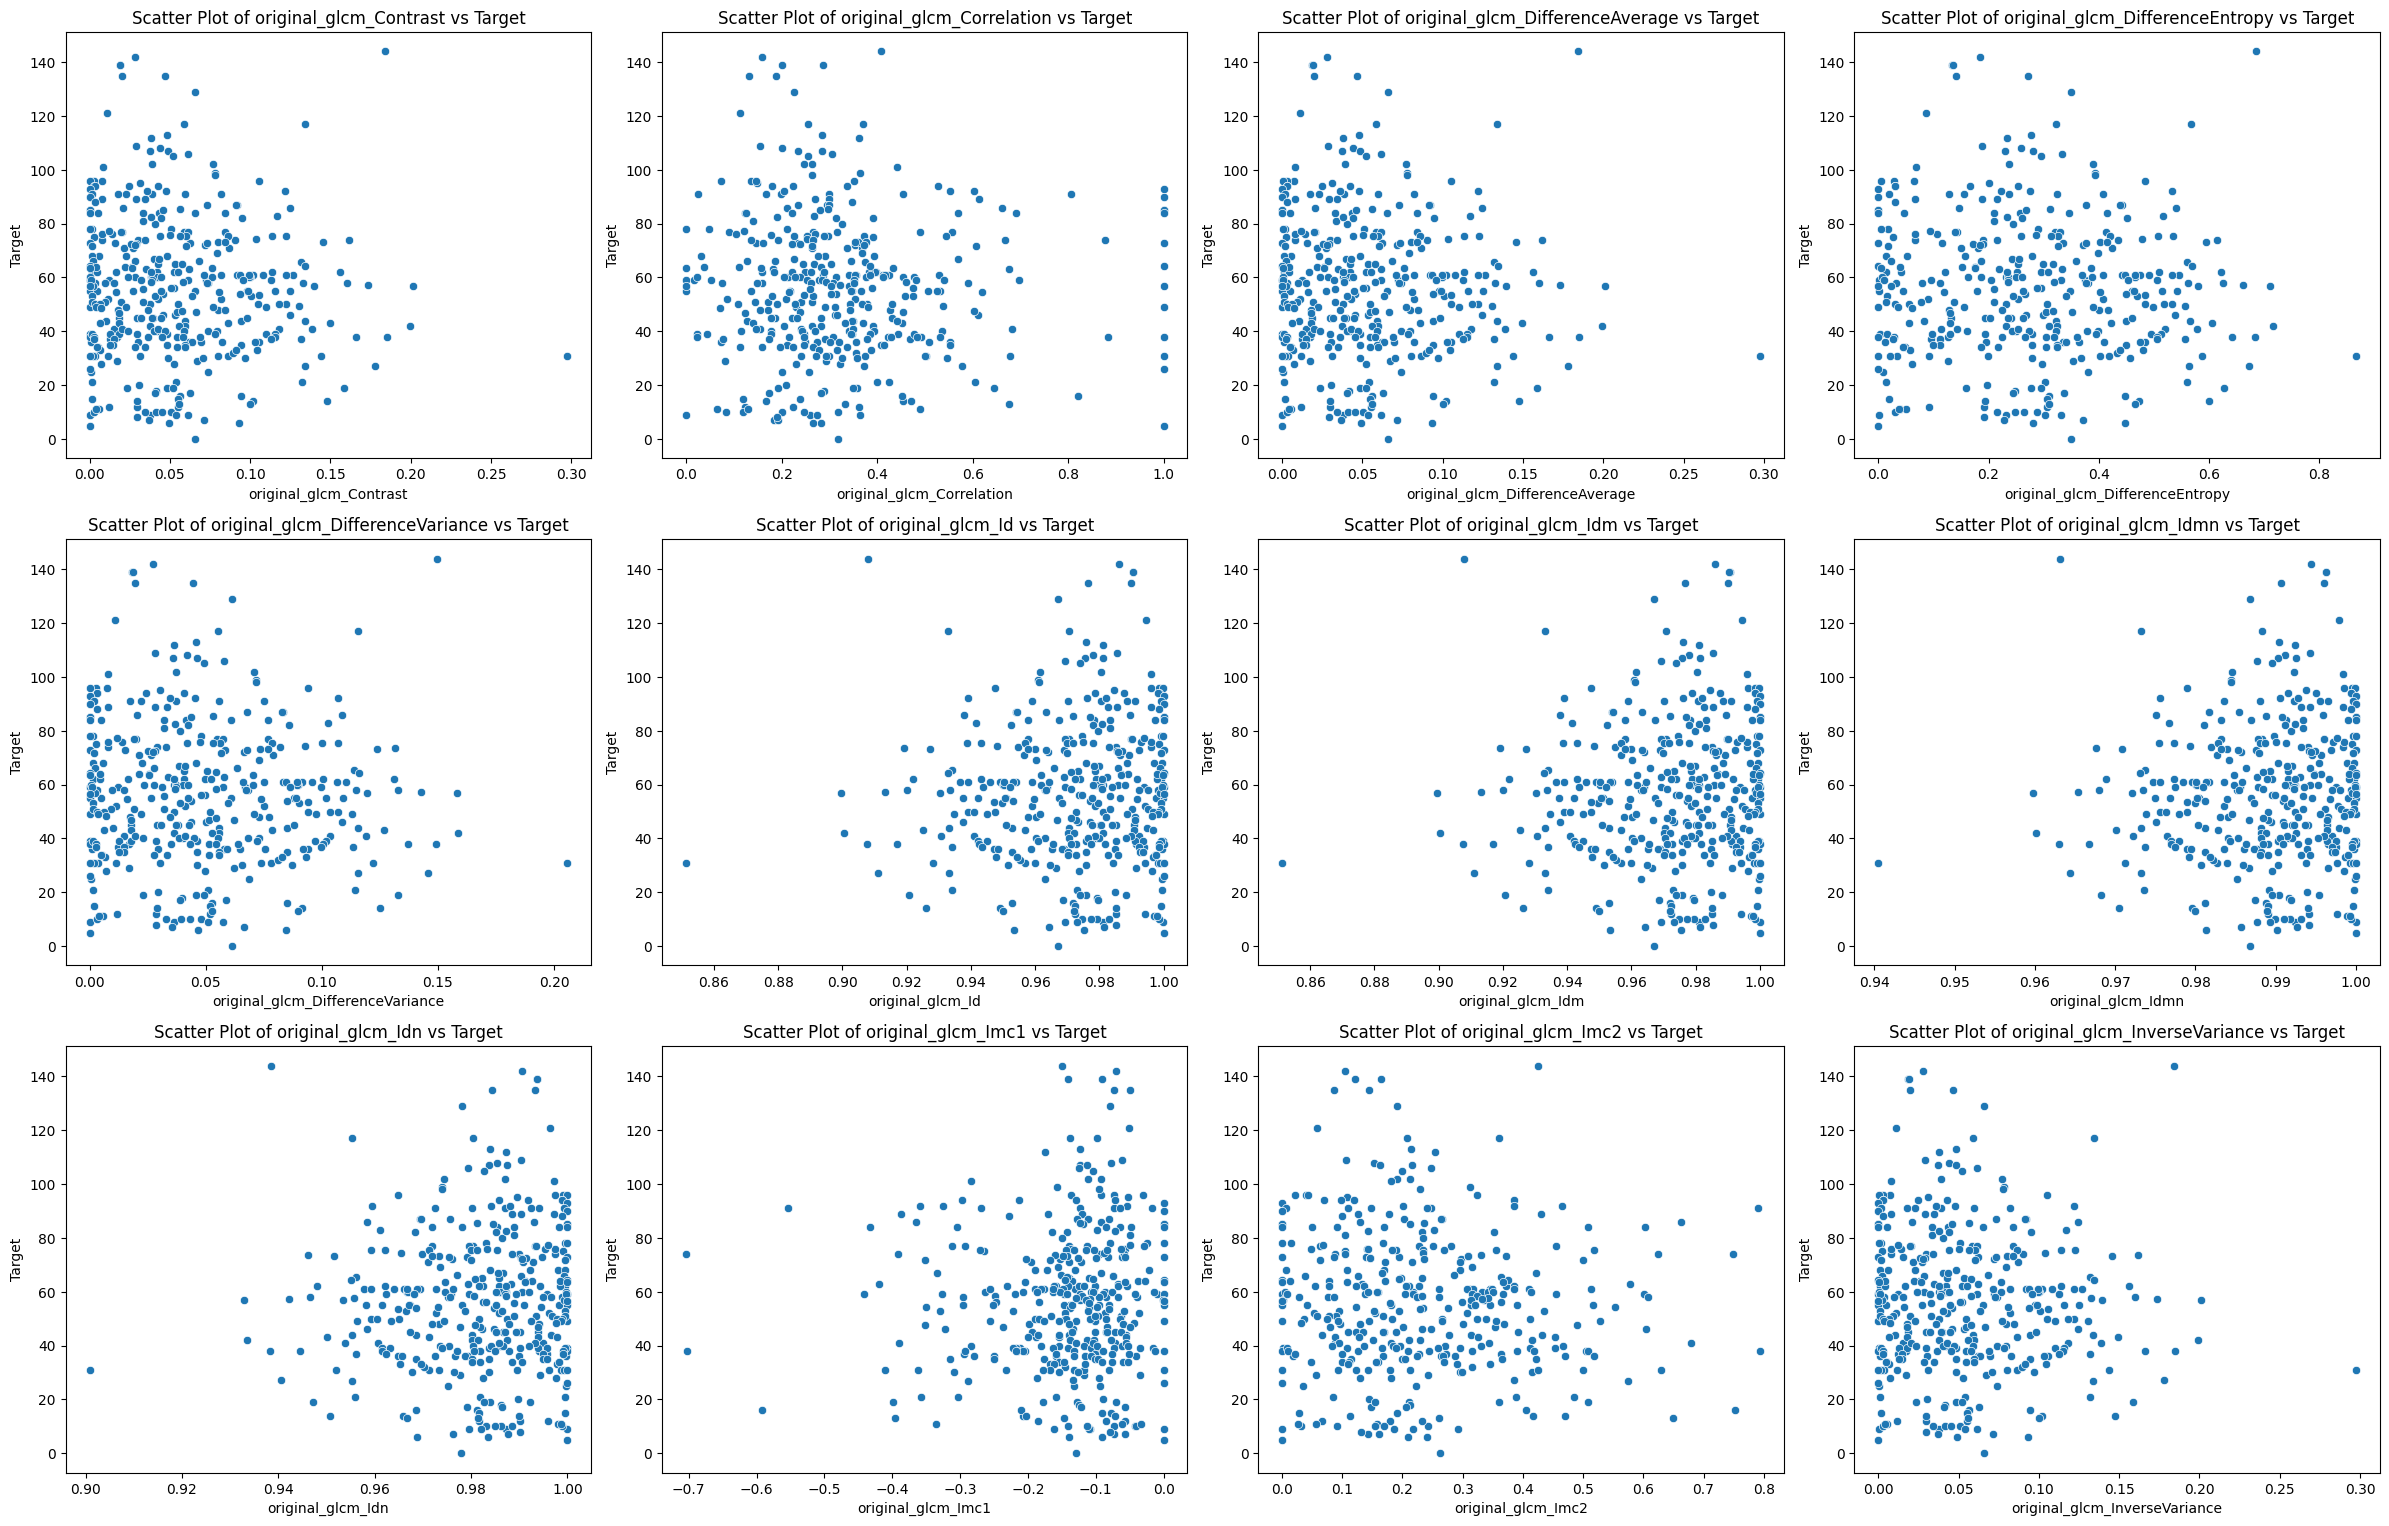

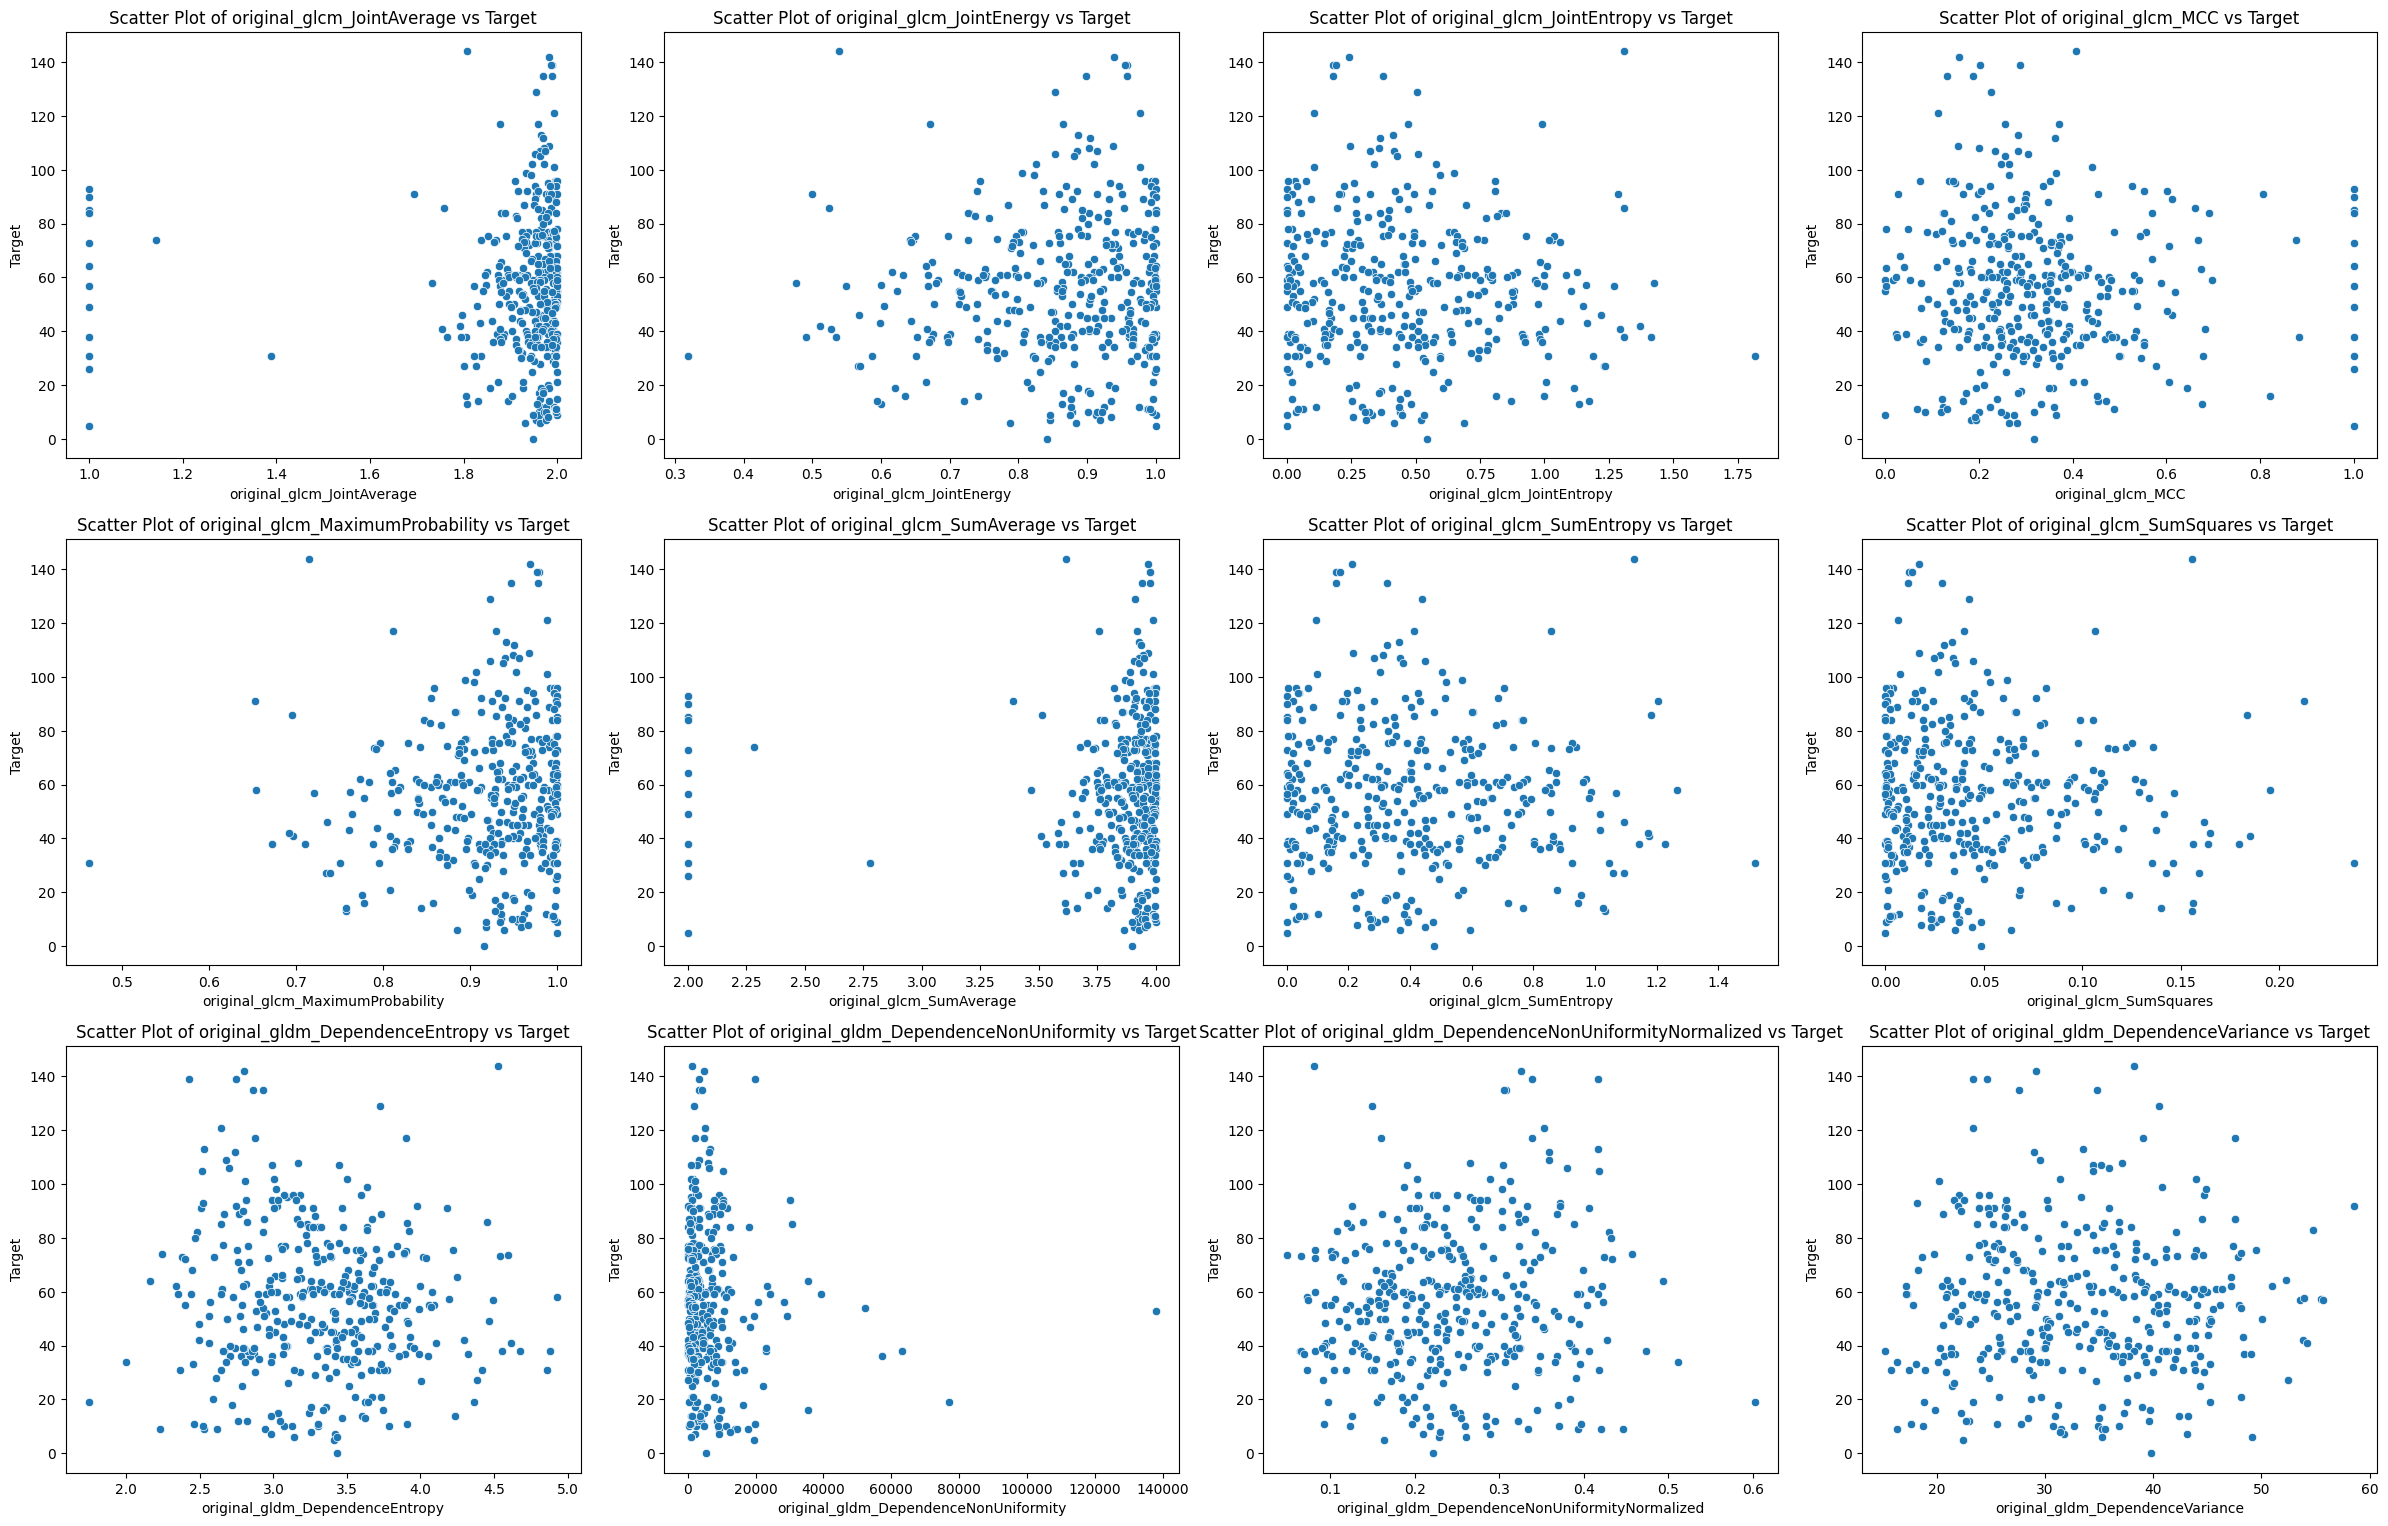

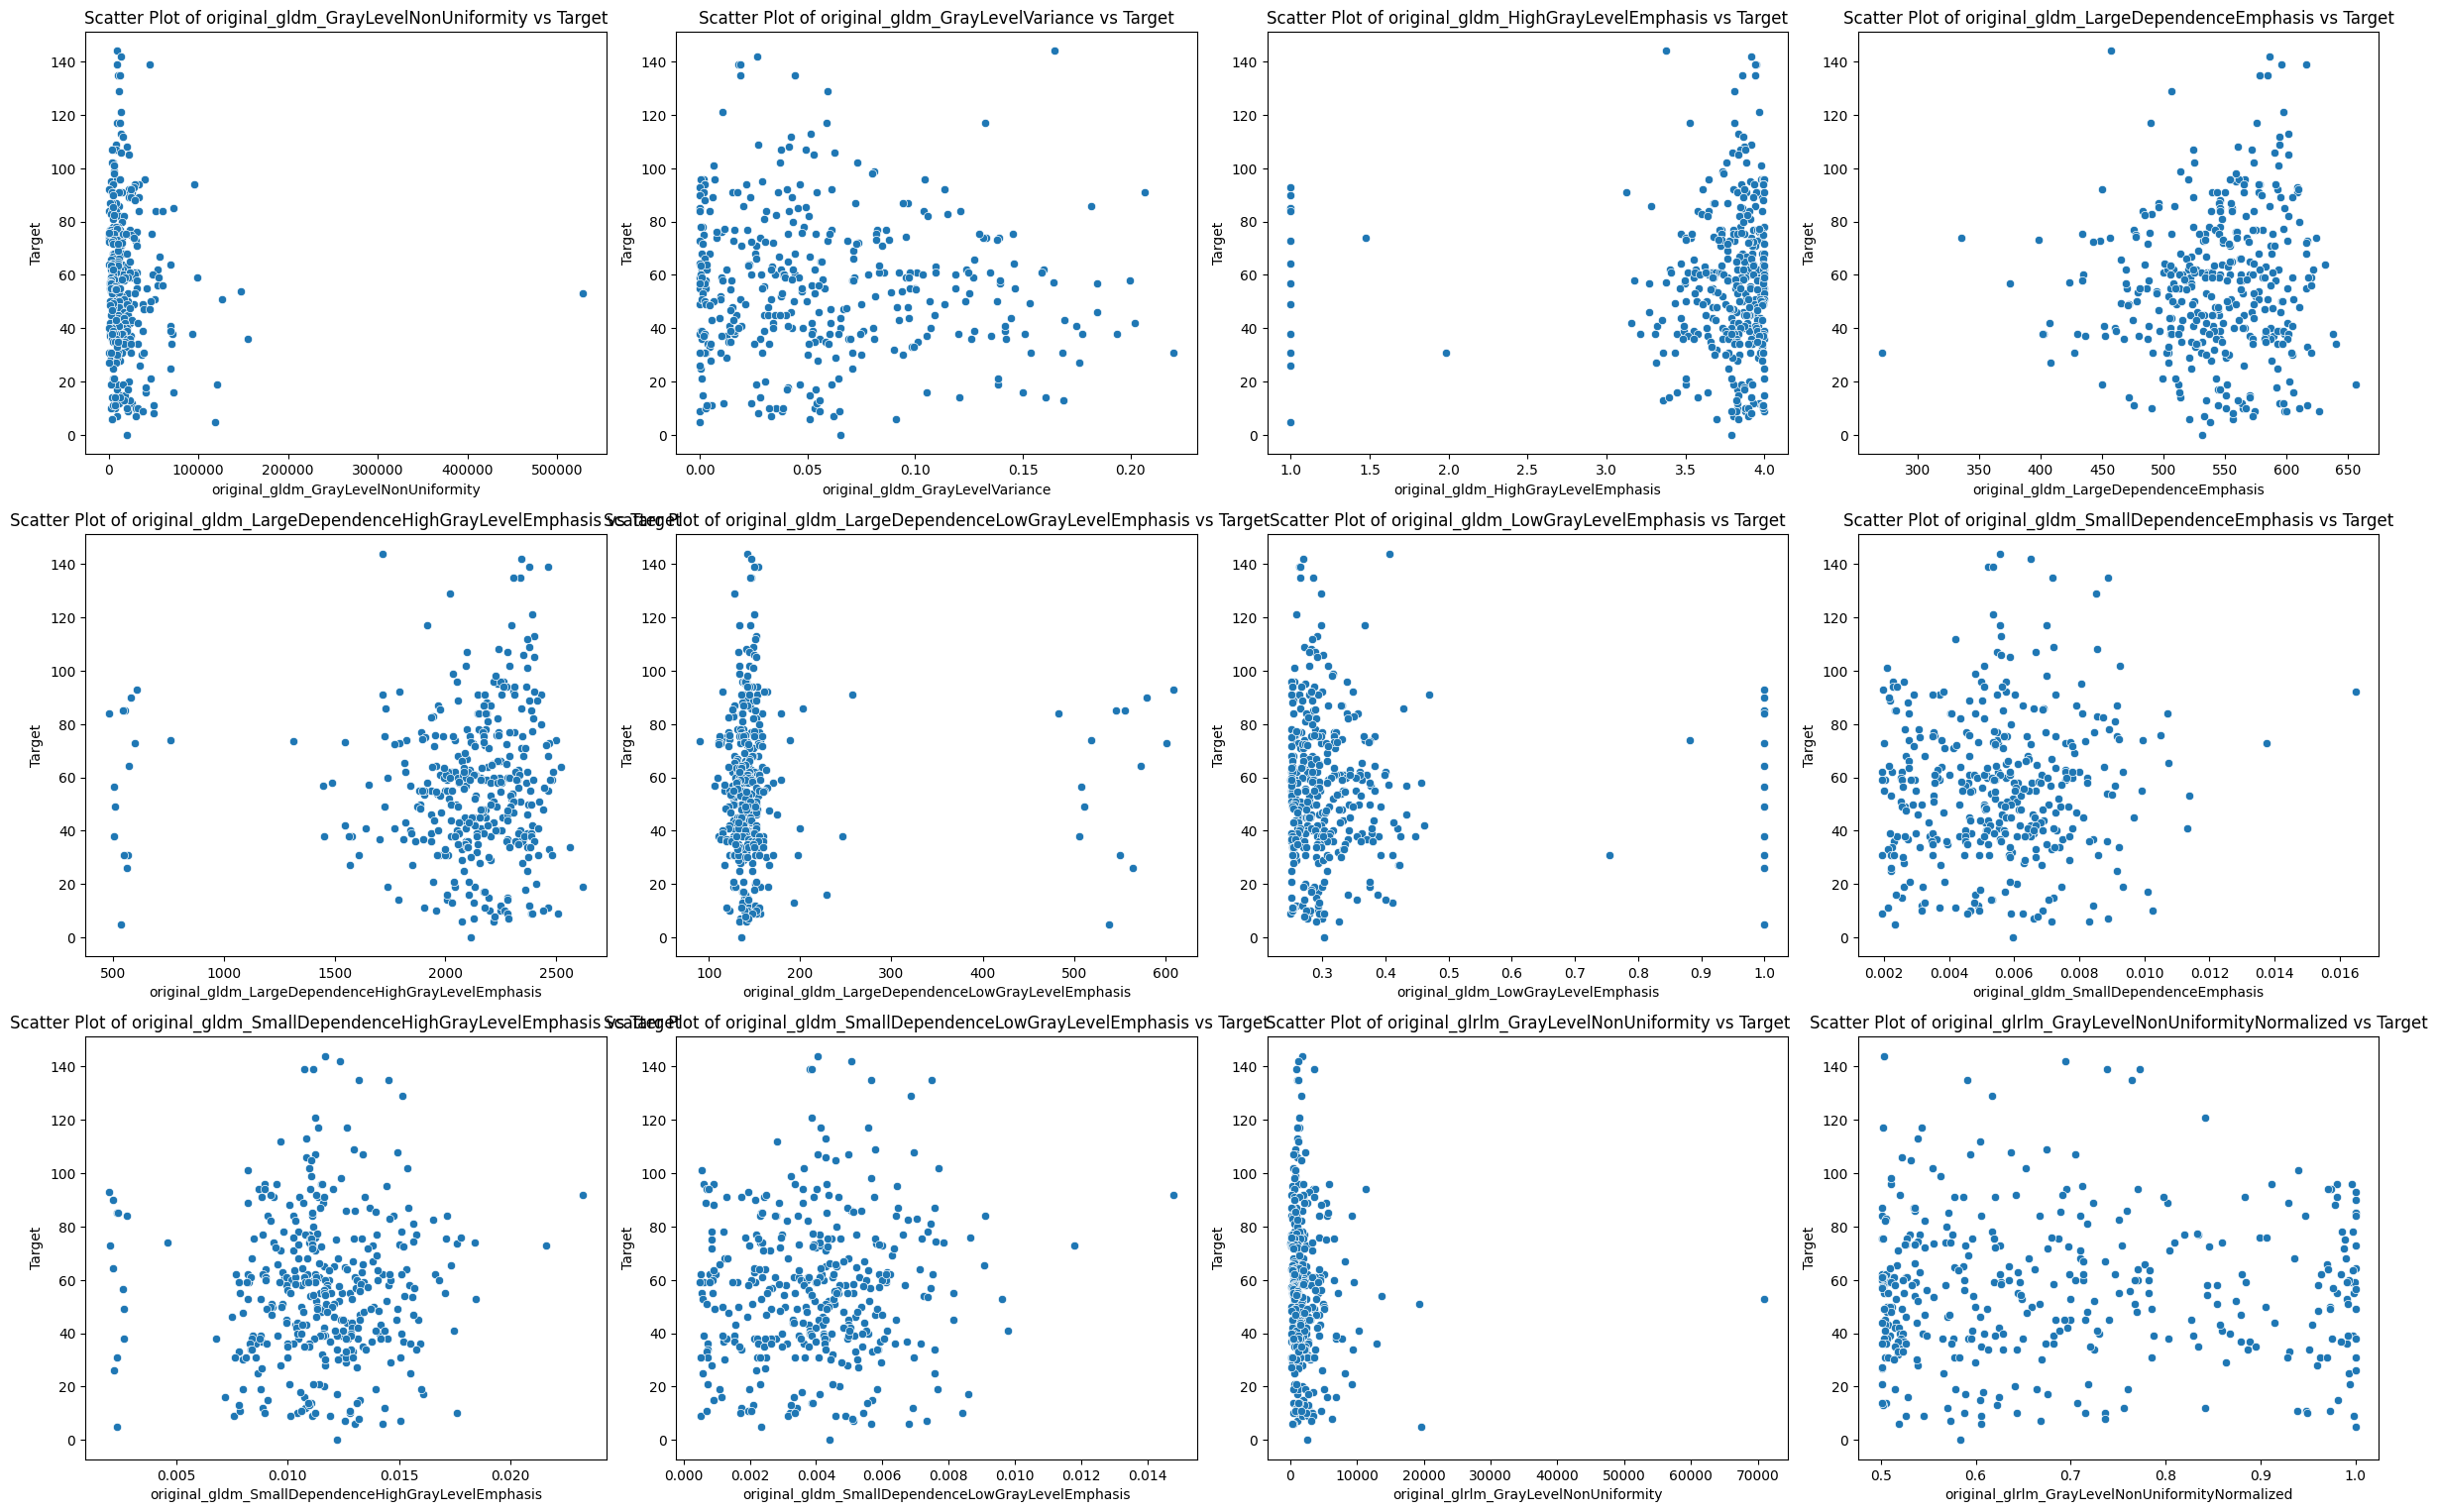

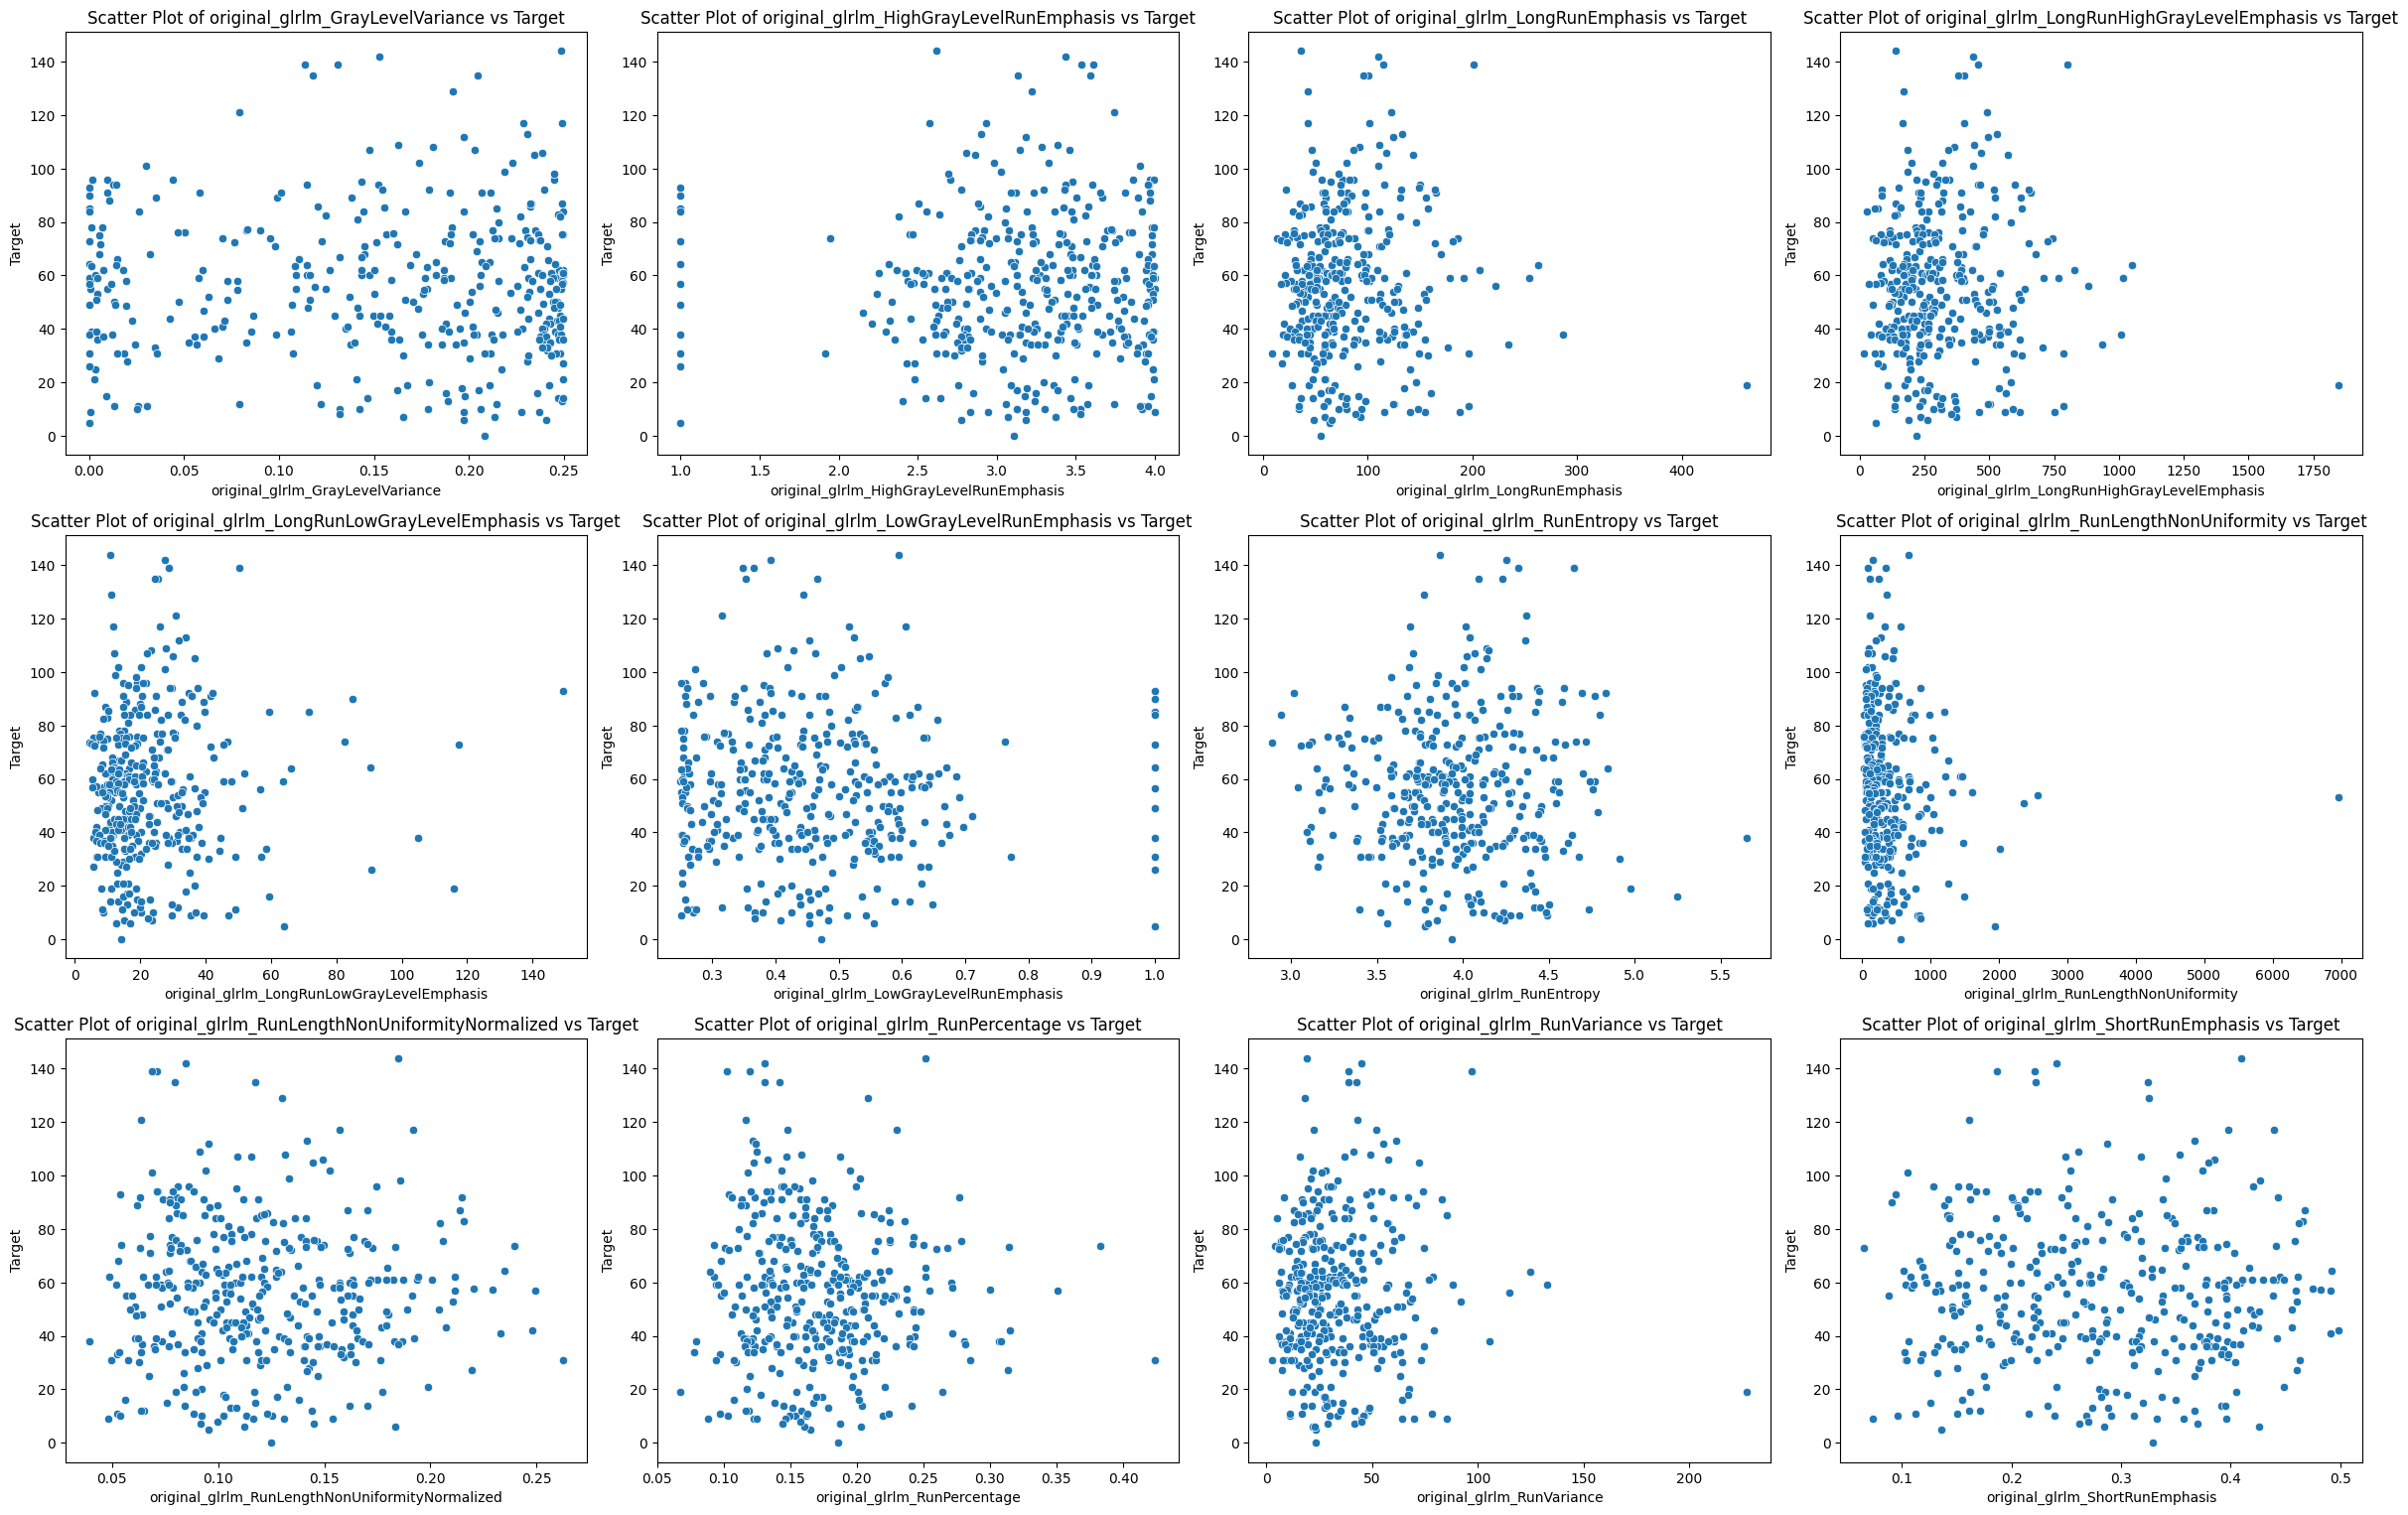

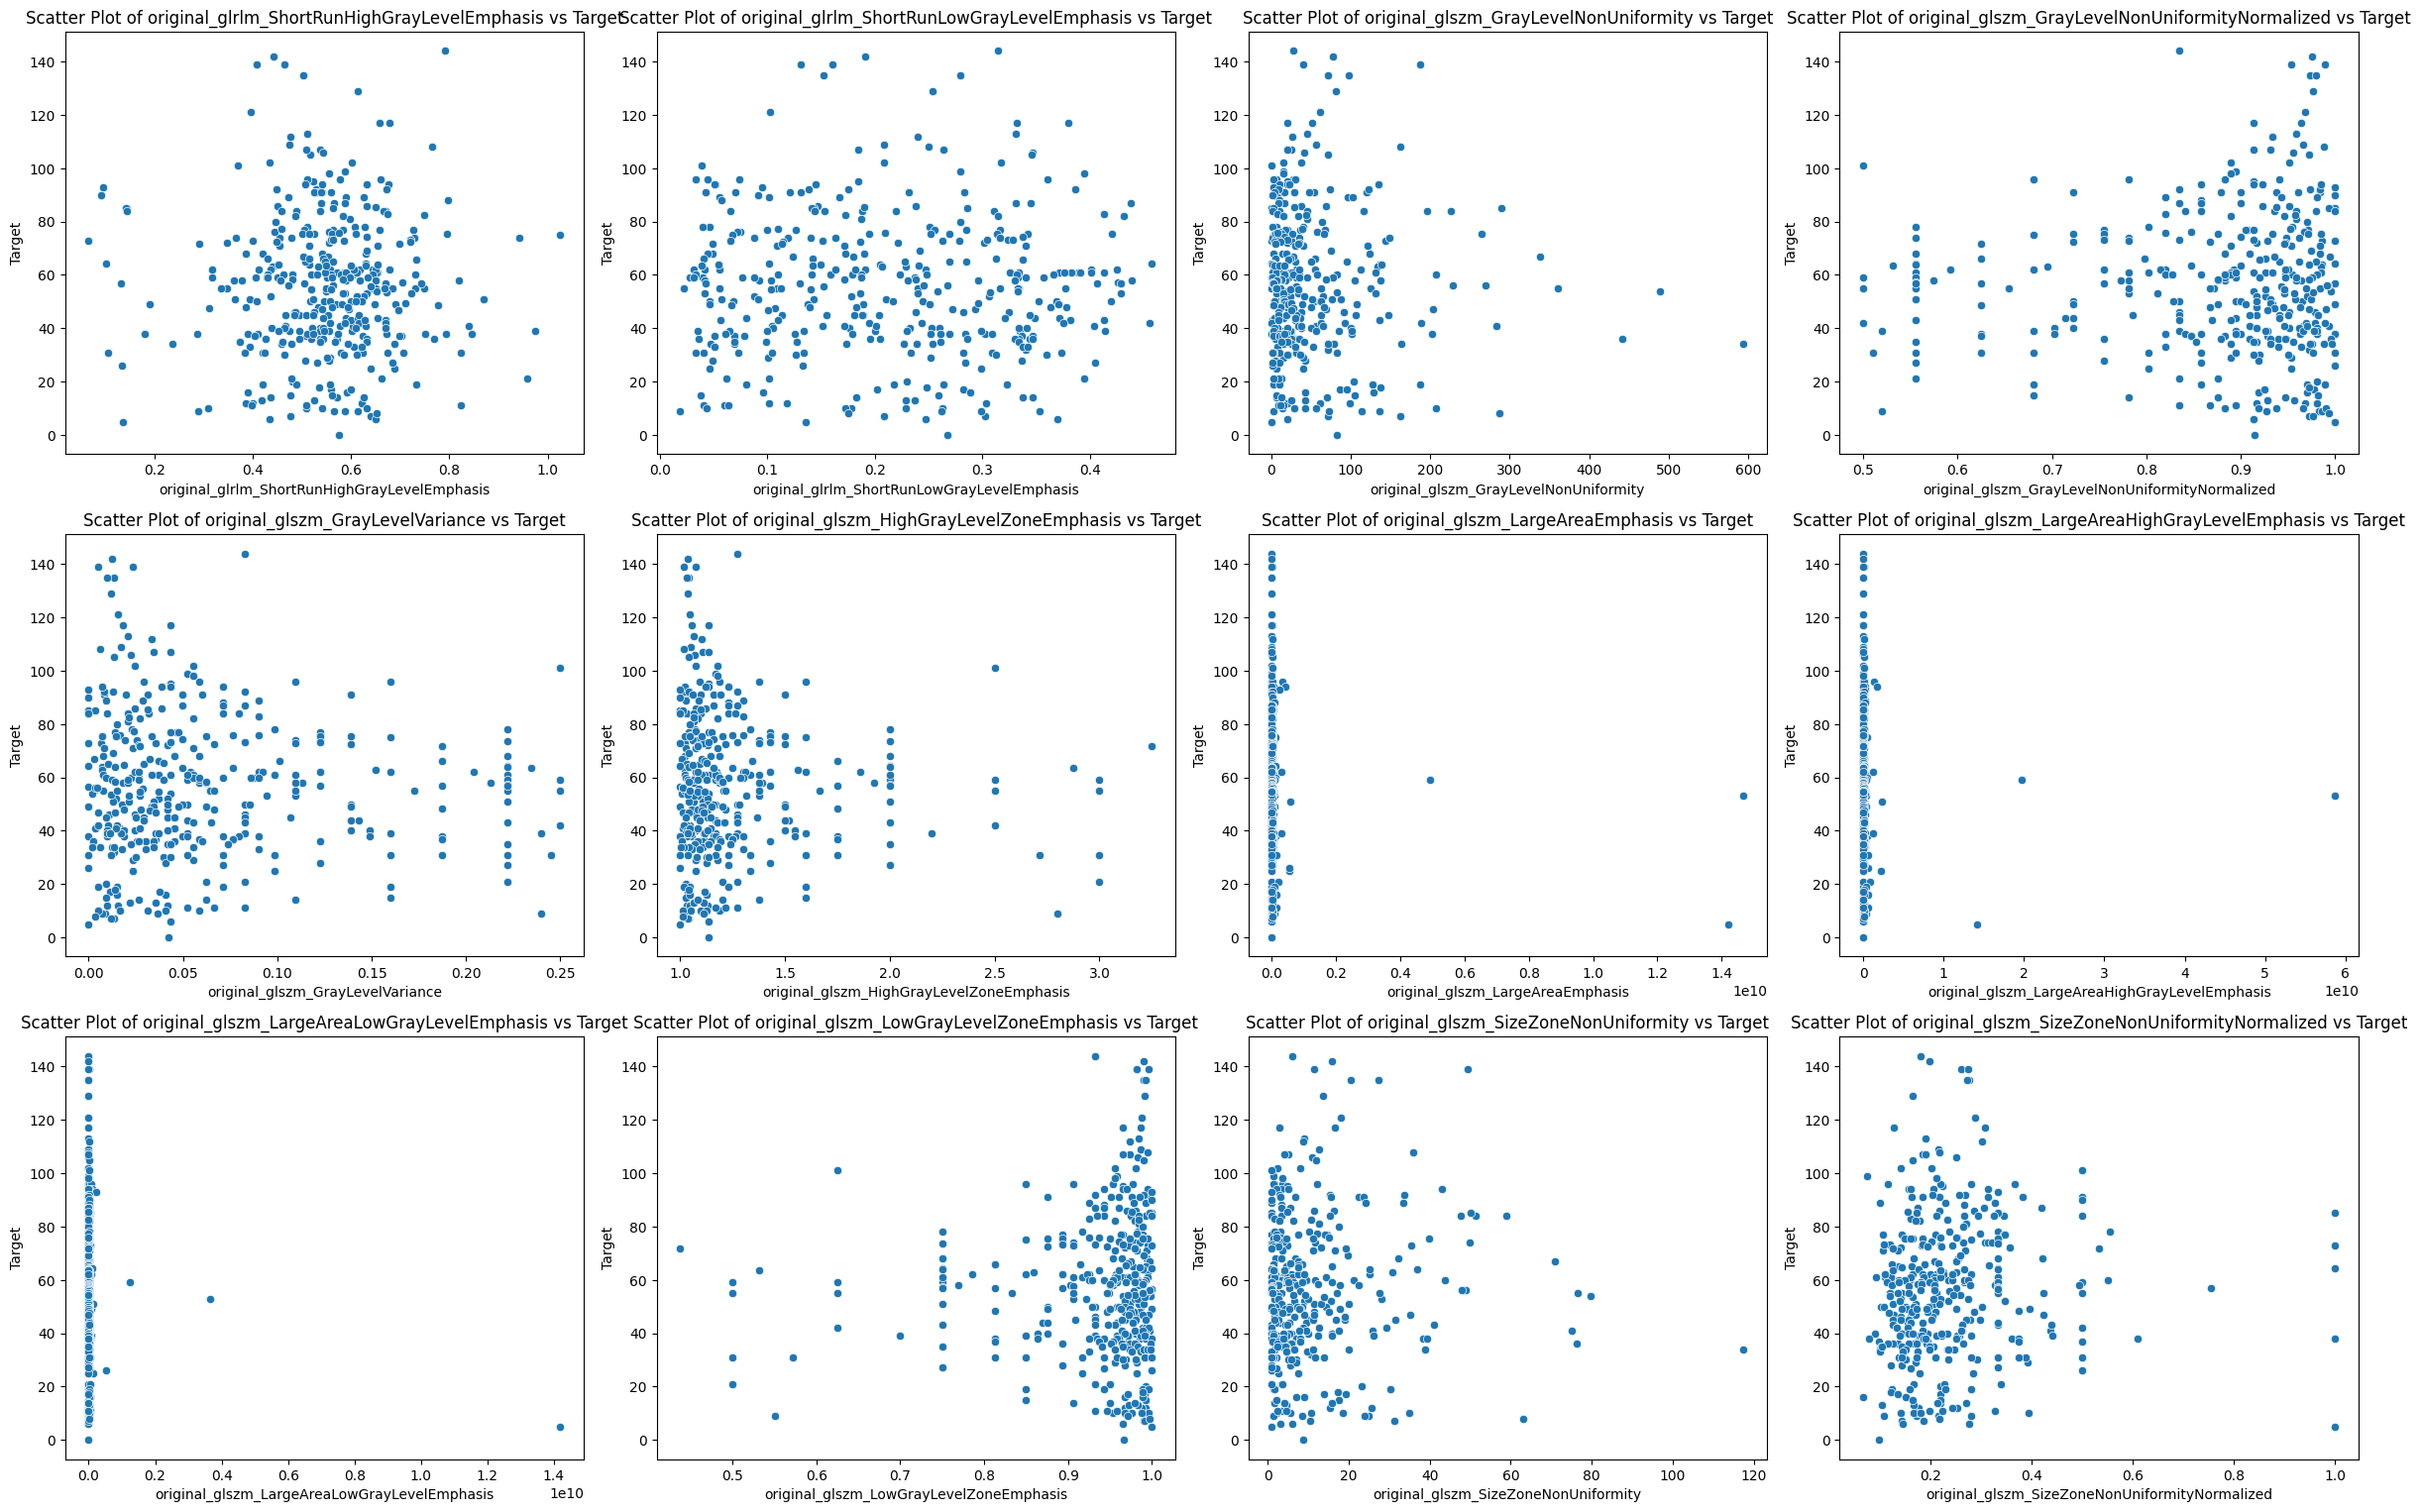

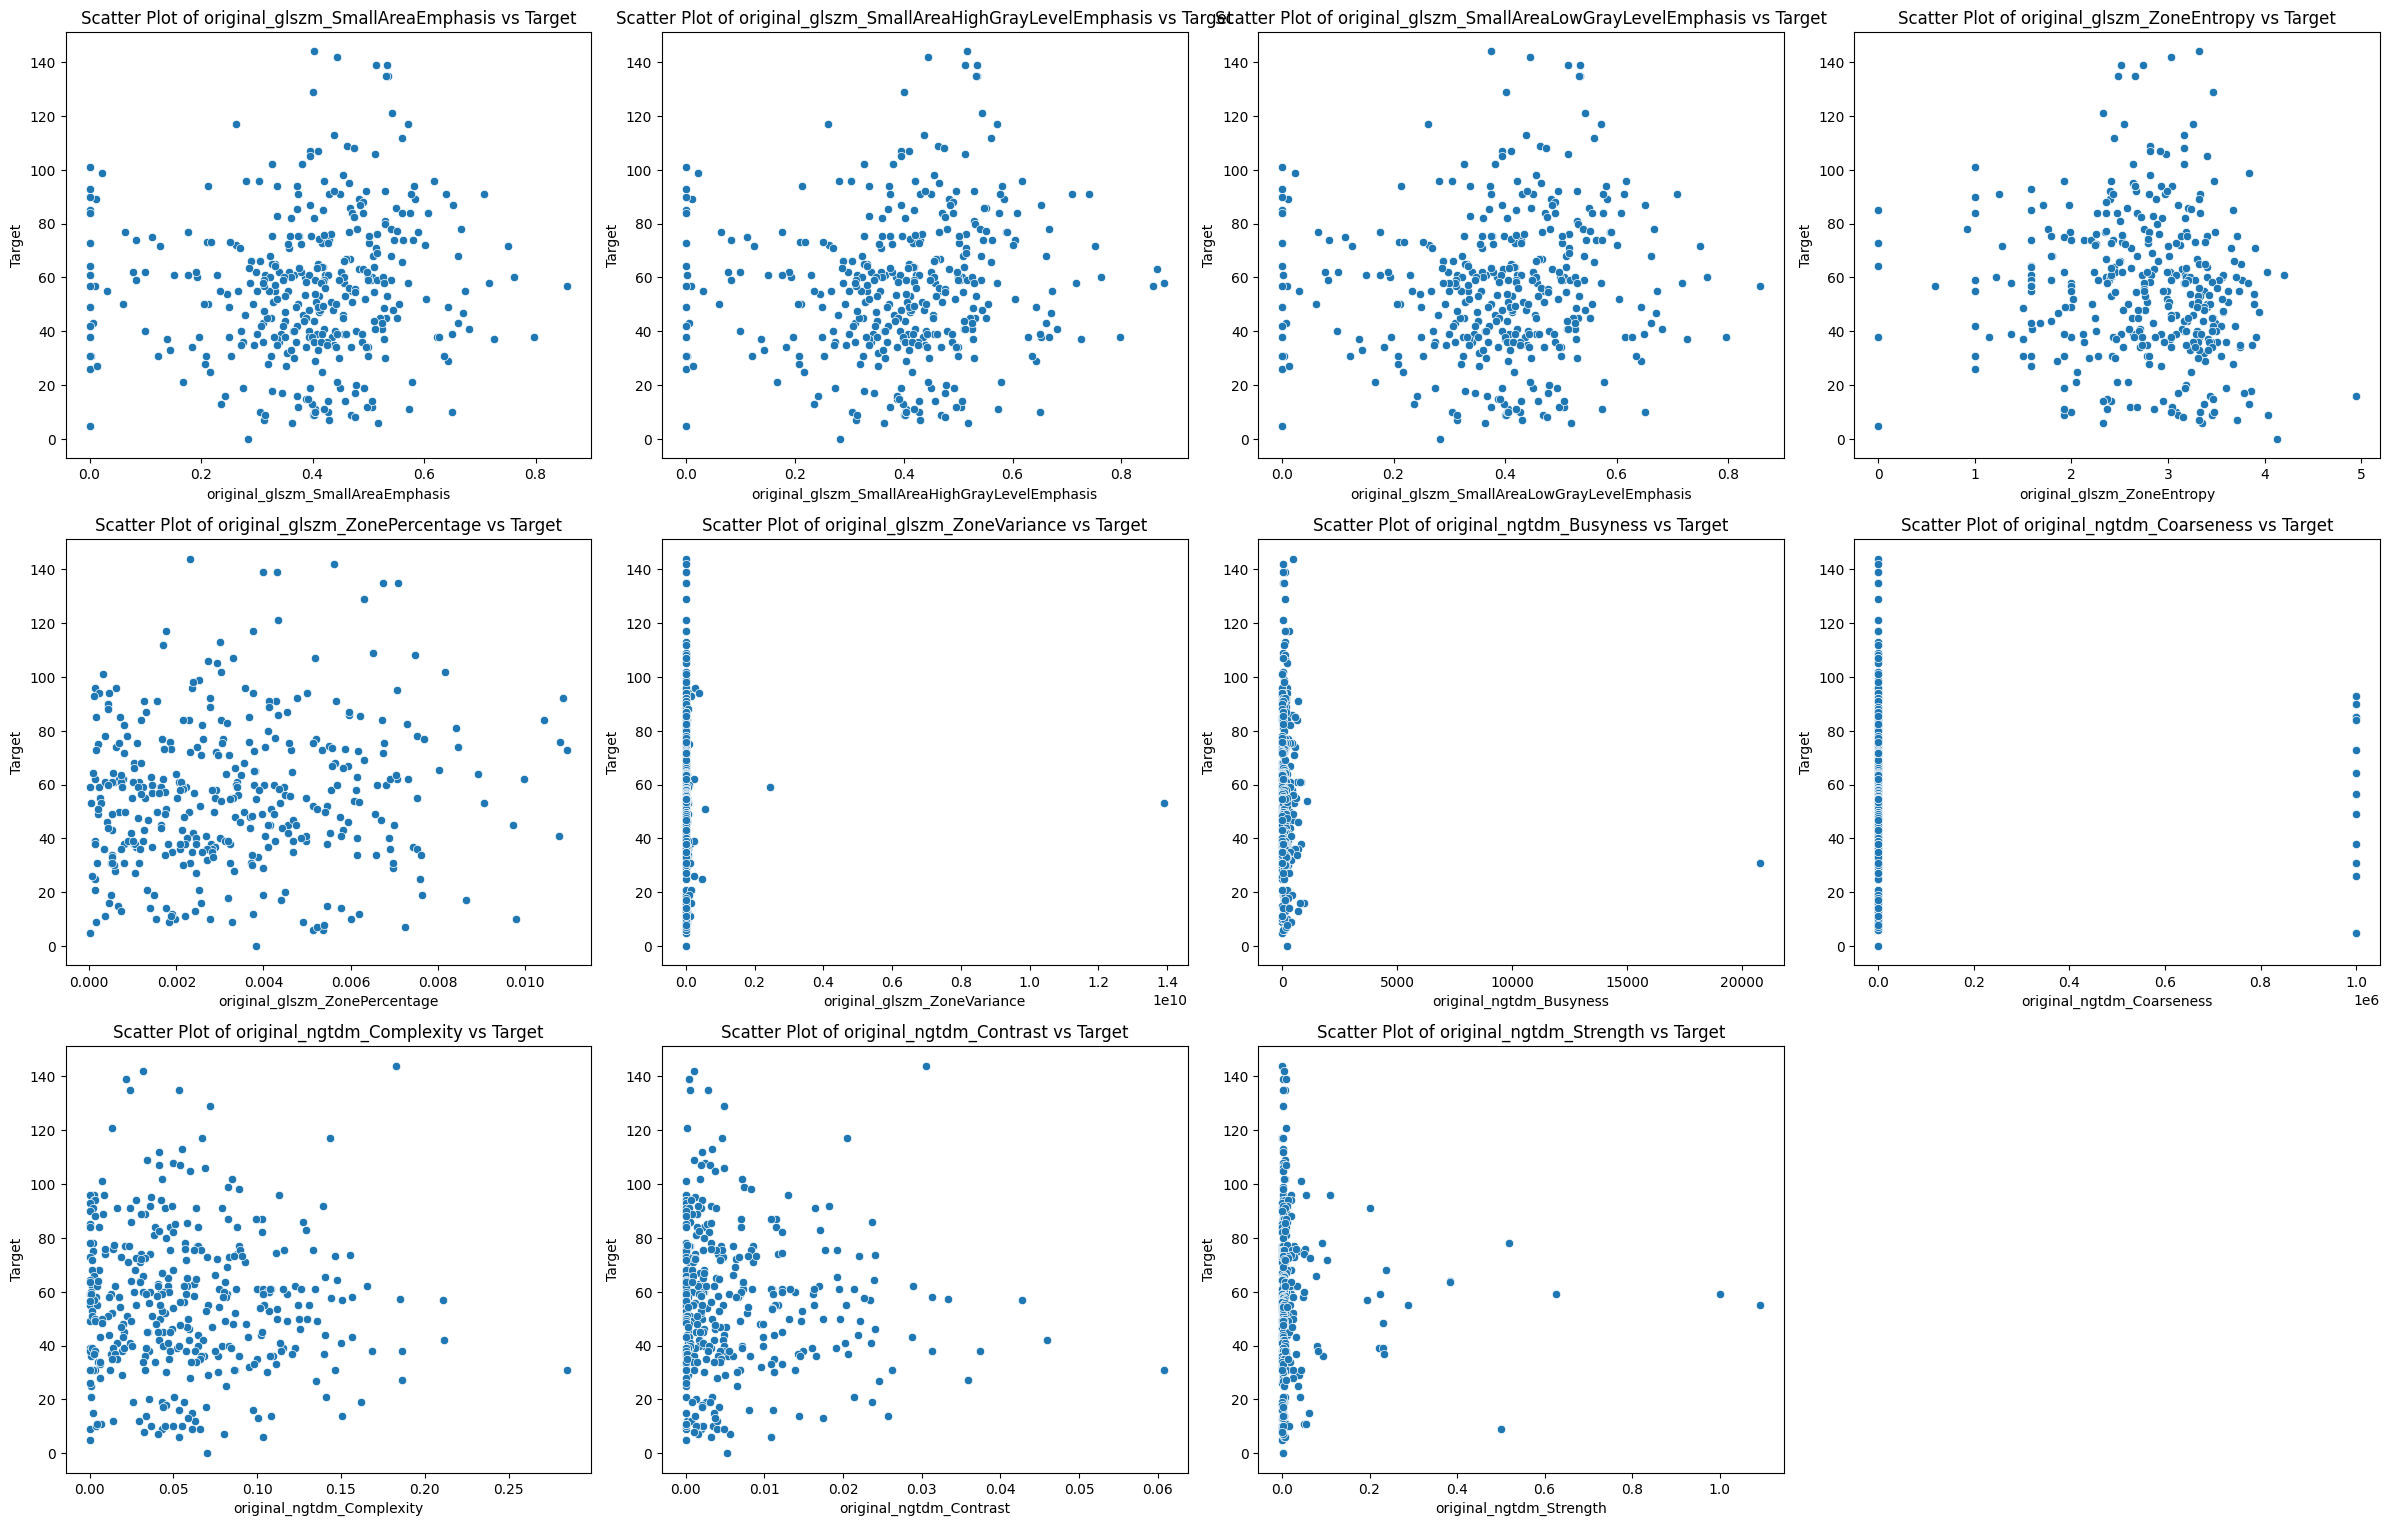

In [ ]:
# Number of plots per figure
plots_per_figure = 12

# Calculate the number of required figures
num_figures = math.ceil(len(continuous_vars) / plots_per_figure)

for fig_index in range(num_figures):
    plt.figure(figsize=(24, 20))
    start_index = fig_index * plots_per_figure
    end_index = min(start_index + plots_per_figure, len(continuous_vars))

    for i, var in enumerate(continuous_vars[start_index:end_index], 1):
        plt.subplot(4, 4, i)
        sns.scatterplot(x=X_train[var], y=y_train.values.ravel())
        plt.title(f'Scatter Plot of {var} vs Target')
        plt.xlabel(var)
        plt.ylabel('Target')

    plt.tight_layout()
    plt.show()

In [ ]:
# Correlaion values
with pd.option_context('display.max_rows', None):
    corr_matrix = train_df.corr()
    sorted_correlations = corr_matrix['RelapseFreeSurvival (outcome)'].sort_values(ascending=False)
    print(sorted_correlations)

RelapseFreeSurvival (outcome)                         1.000000
original_shape_Sphericity                             0.130494
original_firstorder_Kurtosis                          0.119586
original_glszm_ZonePercentage                         0.092040
original_shape_Flatness                               0.092000
original_glszm_SmallAreaHighGrayLevelEmphasis         0.086904
original_glszm_SmallAreaEmphasis                      0.081147
original_gldm_SmallDependenceLowGrayLevelEmphasis     0.081114
original_glszm_SizeZoneNonUniformityNormalized        0.080469
original_glszm_SmallAreaLowGrayLevelEmphasis          0.079082
original_glcm_ClusterShade                            0.074668
original_gldm_LargeDependenceEmphasis                 0.074095
original_gldm_SmallDependenceEmphasis                 0.073713
original_shape_Elongation                             0.072744
original_gldm_DependenceNonUniformityNormalized       0.066778
original_glcm_MaximumProbability                      0

In [ ]:
# The 5th and 95th percentile outlier removal

# Loop over the columns starting from the 10th column
for col in X_train.iloc[:, 10:].columns:
    lower_percentile = X_train[col].quantile(0.05)
    upper_percentile = X_train[col].quantile(0.95)

    X_train[col] = np.where(X_train[col] < lower_percentile, lower_percentile, X_train[col])
    X_train[col] = np.where(X_train[col] > upper_percentile, upper_percentile, X_train[col])

X_train.describe()

Age         ER         PgR        HER2  TrippleNegative  \
count  380.000000  380.00000  380.000000  380.000000       380.000000   
mean    51.974856    0.55000    3.031579    2.926316         2.963158   
std     10.971137    0.49815   51.229259   51.234366        51.232603   
min     23.000000    0.00000    0.000000    0.000000         0.000000   
25%     44.524983    0.00000    0.000000    0.000000         0.000000   
50%     51.242984    1.00000    0.000000    0.000000         0.000000   
75%     60.075000    1.00000    1.000000    1.000000         1.000000   
max     79.603012    1.00000  999.000000  999.000000       999.000000   

       ChemoGrade  Proliferation  HistologyType    LNStatus  TumourStage  \
count  380.000000     380.000000     380.000000  380.000000   380.000000   
mean    10.265789       6.826316       9.031579    3.163158     2.597368   
std     88.317880      72.269259      88.427446   51.222570     0.888801   
min      1.000000       1.000000       1.000000    0.000000     1.000000   
25%      2.000000       1.000000       1.000000    0.000000     2.000000   
50%      2.000000       1.000000       1.000000    1.000000     2.000000   
75%      3.000000       2.000000       1.000000    1.000000     3.000000   
max    999.000000     999.000000     999.000000  999.000000     4.000000   

       original_shape_Elongation  original_shape_Flatness  \
count                 380.000000               380.000000   
mean                    0.720188                 0.552934   
std                     0.153357                 0.160876   
min                     0.390131                 0.279089   
25%                     0.615401                 0.425951   
50%                     0.743416                 0.550761   
75%                     0.846433                 0.689610   
max                     0.929762                 0.809023   

       original_shape_LeastAxisLength  original_shape_MajorAxisLength  \
count                      380.000000                      380.000000   
mean                        22.799727                       45.205109   
std                          8.208731                       21.108751   
min                         10.735423                       18.693558   
25%                         16.345309                       28.402586   
50%                         21.683195                       39.382335   
75%                         27.936808                       58.117748   
max                         41.180067                       92.055114   

       original_shape_Maximum2DDiameterColumn  \
count                              380.000000   
mean                                47.315745   
std                                 21.171627   
min                                 20.604556   
25%                                 31.144823   
50%                                 41.430186   
75%                                 59.665736   
max                                 96.815347   

       original_shape_Maximum2DDiameterRow  \
count                           380.000000   
mean                             43.231125   
std                              18.934632   
min                              18.439089   
25%                              28.792360   
50%                              38.522581   
75%                              54.767837   
max                              86.253191   

       original_shape_Maximum2DDiameterSlice  \
count                             380.000000   
mean                               46.038297   
std                                20.598735   
min                                19.009060   
25%                                30.149627   
50%                                39.736472   
75%                                59.469219   
max                                90.724157   

       original_shape_Maximum3DDiameter  original_shape_MeshVolume  \
count                        380.000000                 380.000000   
mean                          54.

In [ ]:
# Before data imputation, check to see where missing values are present
null_counts = X_train.isnull().sum()
null_counts = null_counts[null_counts > 0]

print(null_counts)

Series([], dtype: int64)


In [ ]:
# Data Imputation

imputer = SimpleImputer(strategy='median')
X_train_transformed = imputer.fit_transform(X_train)

# Reconstruct DataFrame
X_train_imputed = pd.DataFrame(X_train_transformed, columns=X_train.columns, index=X_train.index)

X_train_imputed.describe()

Age         ER         PgR        HER2  TrippleNegative  \
count  380.000000  380.00000  380.000000  380.000000       380.000000   
mean    51.974856    0.55000    3.031579    2.926316         2.963158   
std     10.971137    0.49815   51.229259   51.234366        51.232603   
min     23.000000    0.00000    0.000000    0.000000         0.000000   
25%     44.524983    0.00000    0.000000    0.000000         0.000000   
50%     51.242984    1.00000    0.000000    0.000000         0.000000   
75%     60.075000    1.00000    1.000000    1.000000         1.000000   
max     79.603012    1.00000  999.000000  999.000000       999.000000   

       ChemoGrade  Proliferation  HistologyType    LNStatus  TumourStage  \
count  380.000000     380.000000     380.000000  380.000000   380.000000   
mean    10.265789       6.826316       9.031579    3.163158     2.597368   
std     88.317880      72.269259      88.427446   51.222570     0.888801   
min      1.000000       1.000000       1.000000    0.000000     1.000000   
25%      2.000000       1.000000       1.000000    0.000000     2.000000   
50%      2.000000       1.000000       1.000000    1.000000     2.000000   
75%      3.000000       2.000000       1.000000    1.000000     3.000000   
max    999.000000     999.000000     999.000000  999.000000     4.000000   

       original_shape_Elongation  original_shape_Flatness  \
count                 380.000000               380.000000   
mean                    0.720188                 0.552934   
std                     0.153357                 0.160876   
min                     0.390131                 0.279089   
25%                     0.615401                 0.425951   
50%                     0.743416                 0.550761   
75%                     0.846433                 0.689610   
max                     0.929762                 0.809023   

       original_shape_LeastAxisLength  original_shape_MajorAxisLength  \
count                      380.000000                      380.000000   
mean                        22.799727                       45.205109   
std                          8.208731                       21.108751   
min                         10.735423                       18.693558   
25%                         16.345309                       28.402586   
50%                         21.683195                       39.382335   
75%                         27.936808                       58.117748   
max                         41.180067                       92.055114   

       original_shape_Maximum2DDiameterColumn  \
count                              380.000000   
mean                                47.315745   
std                                 21.171627   
min                                 20.604556   
25%                                 31.144823   
50%                                 41.430186   
75%                                 59.665736   
max                                 96.815347   

       original_shape_Maximum2DDiameterRow  \
count                           380.000000   
mean                             43.231125   
std                              18.934632   
min                              18.439089   
25%                              28.792360   
50%                              38.522581   
75%                              54.767837   
max                              86.253191   

       original_shape_Maximum2DDiameterSlice  \
count                             380.000000   
mean                               46.038297   
std                                20.598735   
min                                19.009060   
25%                                30.149627   
50%                                39.736472   
75%                                59.469219   
max                                90.724157   

       original_shape_Maximum3DDiameter  original_shape_MeshVolume  \
count                        380.000000                 380.000000   
mean                          54.

In [ ]:
# Verify data imputation
null_counts = X_train_imputed.isnull().sum()
null_counts = null_counts[null_counts > 0]

print(null_counts)

Series([], dtype: int64)


In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 5]
}

In [ ]:
# Copy X_train_imputed to keep the original DataFrame unmodified
X_train_imputed_all = X_train_imputed.copy()

# Run GridSearchCV on the training dataset
cv_generator = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=cv_generator, scoring='neg_mean_absolute_error', verbose=2)
grid_search.fit(X_train_imputed_all, y_train.values.ravel())

# Print mean score for each iteration of GridSearchCV
print("Mean Score for each iteration of GridSearchCV:")
for mean_score in grid_search.cv_results_['mean_test_score']:
    print(f"Mean Score: {-mean_score:.4f}")

# Print the best estimator and its parameters
best_model = grid_search.best_estimator_
print("\nBest Estimator:", best_model)

# Best model evaluation on the test set
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nBest Model performance on Test Set ---> MAE: {mae}, R2: {r2}")

# Combine the train and test datasets for retraining
X_combined = pd.concat([X_train_imputed_all, X_test])
y_combined = pd.concat([y_train, y_test])

# Retrain the best model on the combined dataset
best_model_retrained_no_fs = RandomForestRegressor(**best_model.get_params())
best_model_retrained_no_fs.fit(X_combined, y_combined.values.ravel())

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   3.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   3.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   3.0s
[CV] END max

RandomForestRegressor(min_samples_leaf=2, n_estimators=200)

In [ ]:
# WITH FEATURE SELECTION (n= 30)

# Create a copy of X_train_imputed and apply Sequential Feature Selection
X_train_imputed_copy = X_train_imputed.copy()
rf_reg = RandomForestRegressor(n_estimators=50, random_state=0)
sfs = SequentialFeatureSelector(rf_reg, n_features_to_select=30, direction='forward', scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
sfs.fit(X_train_imputed_copy, y_train)

# Get the mask of selected features and select the features
selected_features_mask = sfs.get_support()
selected_features = X_train_imputed_copy.columns[selected_features_mask]

# Create new datasets with only the selected features
X_train_imputed_selected = X_train_imputed_copy[selected_features]
X_test_selected = X_test[selected_features].copy()

# Combine the train and test datasets for retraining
X_combined = pd.concat([X_train_imputed_selected, X_test_selected])
y_combined = pd.concat([y_train, y_test])

# Run GridSearchCV on the training dataset
cv_generator = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=cv_generator, scoring='neg_mean_absolute_error', verbose=2)
grid_search.fit(X_train_imputed_selected, y_train.values.ravel())

# Print the best estimator and its parameters
best_model = grid_search.best_estimator_
print("\nBest Estimator:", best_model)

y_pred = best_model.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nBest Model performance on Test Set ---> MAE: {mae}, R2: {r2}")

# Retrain the best model on the combined dataset
best_model_retrained_fs = RandomForestRegressor(**best_model.get_params())
best_model_retrained_fs.fit(X_combined, y_combined.values.ravel())

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max

RandomForestRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=5,
                      n_estimators=200)

In [ ]:
# WITH LINEAR PCA

# Apply StandardScaler and PCA transformation
X_train_imputed_copy = X_train_imputed.copy()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed_copy)
pca = PCA(n_components=0.99, random_state=0)
X_train_pca = pca.fit_transform(X_train_scaled)

# Apply the same transformations to the test data
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

# Run GridSearchCV on the PCA-transformed training dataset
cv_generator = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=cv_generator, scoring='neg_mean_absolute_error', verbose=2)
grid_search.fit(X_train_pca, y_train.values.ravel())

# Print the best estimator and its parameters
best_model = grid_search.best_estimator_
print("\nBest Estimator:", best_model)

y_pred = best_model.predict(X_test_pca)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nBest Model performance on Test Set ---> MAE: {mae}, R2: {r2}")

# Combine the train and test datasets for retraining
X_combined_pca = np.concatenate([X_train_pca, X_test_pca])
y_combined = pd.concat([y_train, y_test])

# Retrain the best model on the combined dataset
best_model_retrained_pca = RandomForestRegressor(**best_model.get_params())
best_model_retrained_pca.fit(X_combined_pca, y_combined.values.ravel())

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END max

RandomForestRegressor(min_samples_leaf=5, min_samples_split=5, n_estimators=200)

In [ ]:
# WITH KERNEL(RBF) PCA

# Apply StandardScaler and Kernel PCA transformation
X_train_imputed_copy = X_train_imputed.copy()
scaler = StandardScaler()
X_train_scaled_kpca = scaler.fit_transform(X_train_imputed_copy)
kernel_pca = KernelPCA(kernel='rbf', n_components=30, random_state=0)
X_train_imputed_kpca = kernel_pca.fit_transform(X_train_scaled_kpca)

# Apply the same transformations to the test data
X_test_scaled_kpca = scaler.transform(X_test)
X_test_kernel_pca = kernel_pca.transform(X_test_scaled_kpca)

# Run GridSearchCV on the Kernel PCA-transformed training dataset
cv_generator = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=cv_generator, scoring='neg_mean_absolute_error', verbose=2)
grid_search.fit(X_train_imputed_kpca, y_train.values.ravel())

# Print the best estimator and its parameters
best_model = grid_search.best_estimator_
print("\nBest Estimator:", best_model)

# Evaluate the retrained model on the combined dataset
y_pred = best_model.predict(X_test_kernel_pca)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nBest Model performance on Test Set ---> MAE: {mae}, R2: {r2}")

# Combine the train and test datasets for retraining
X_combined_kpca = np.concatenate([X_train_imputed_kpca, X_test_kernel_pca])
y_combined = pd.concat([y_train, y_test])

# Retrain the best model on the combined dataset
best_model_retrained_kpca = RandomForestRegressor(**best_model.get_params())
best_model_retrained_kpca.fit(X_combined_kpca, y_combined.values.ravel())

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END max

RandomForestRegressor(min_samples_leaf=5, min_samples_split=5, n_estimators=200)

In [ ]:
X_combined_nofs = pd.concat([X_train_imputed, X_test])
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2_scores = cross_val_score(best_model_retrained_no_fs, X_combined_nofs, y_combined.values.ravel(), cv=kfold, scoring='r2')
mean_r2 = np.mean(cv_r2_scores)
print(f"Mean CV R2: {mean_r2}")
cv_mae_scores = cross_val_score(best_model_retrained_no_fs, X_combined_nofs, y_combined.values.ravel(), cv=kfold, scoring='neg_mean_absolute_error')
mean_mae = np.mean(cv_mae_scores)
print(f"Mean CV MAE: {-mean_mae}")

Mean CV R2: 0.03658675190134699
Mean CV MAE: 20.887716329934534


In [ ]:
cv_r2_scores = cross_val_score(best_model_retrained_fs, X_combined, y_combined.values.ravel(), cv=kfold, scoring='r2')
mean_r2 = np.mean(cv_r2_scores)
print(f"Mean CV R2: {mean_r2}")
cv_mae_scores = cross_val_score(best_model_retrained_fs, X_combined, y_combined.values.ravel(), cv=kfold, scoring='neg_mean_absolute_error')
mean_mae = np.mean(cv_mae_scores)
print(f"Mean CV MAE: {-mean_mae}")

Mean CV R2: 0.007725354304271015
Mean CV MAE: 20.78185339356263


In [ ]:
cv_r2_scores = cross_val_score(best_model_retrained_pca, X_combined_pca, y_combined.values.ravel(), cv=kfold, scoring='r2')
mean_r2 = np.mean(cv_r2_scores)
print(f"Mean CV R2: {mean_r2}")
cv_mae_scores = cross_val_score(best_model_retrained_pca, X_combined_pca, y_combined.values.ravel(), cv=kfold, scoring='neg_mean_absolute_error')
mean_mae = np.mean(cv_mae_scores)
print(f"Mean CV MAE: {-mean_mae}")

Mean CV R2: -0.03772460380301625
Mean CV MAE: 21.853223999966406


In [ ]:
cv_r2_scores = cross_val_score(best_model_retrained_kpca, X_combined_kpca, y_combined.values.ravel(), cv=kfold, scoring='r2')
mean_r2 = np.mean(cv_r2_scores)
print(f"Mean CV R2: {mean_r2}")
cv_mae_scores = cross_val_score(best_model_retrained_kpca, X_combined_kpca, y_combined.values.ravel(), cv=kfold, scoring='neg_mean_absolute_error')
mean_mae = np.mean(cv_mae_scores)
print(f"Mean CV MAE: {-mean_mae}")

Mean CV R2: -0.03261194678220121
Mean CV MAE: 21.420432591635993


# XGBoost

In [ ]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from sklearn.impute import SimpleImputer

In [ ]:
# Reading the Data and dropping 'ID'

data=pd.read_excel('TrainDataset2023.xls')
data=data.drop('ID',axis=1)

In [ ]:
def data_cleaning_for_regression(df):

    # Replacing missing values

    df=df.replace(999, np.nan)
    imputer = SimpleImputer(strategy='median')

    df_imputed=imputer.fit_transform(df)

    df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

    # Dealing with Categorical variables

    #  Age,ChemoGrade,Proliferation and TumorStage are ordinal categorical variables so we do not change them

    # ER, PGR, HER2, TrippleNegative, HistologyType and LNStatus are either binary or categorical variables with 2 different
    # values. We just convert HistologyType to binary format.

    df_imputed['HistologyType'] = df_imputed['HistologyType'].map({1: 0, 2: 1})

    return df_imputed

In [ ]:
df_imputed = data.drop('pCR (outcome)',axis=1)
df_imputed = data_cleaning_for_regression(df_imputed)
df_imputed.describe()

RelapseFreeSurvival (outcome)         Age          ER         PgR  \
count                     400.000000  400.000000  400.000000  400.000000   
mean                       56.000208   51.804674    0.547500    0.405000   
std                        27.137584   10.948522    0.498362    0.491507   
min                         0.000000   23.000000    0.000000    0.000000   
25%                        38.000000   44.516769    0.000000    0.000000   
50%                        55.000000   51.019507    1.000000    0.000000   
75%                        73.000000   60.000000    1.000000    1.000000   
max                       144.000000   79.603012    1.000000    1.000000   

             HER2  TrippleNegative  ChemoGrade  Proliferation  HistologyType  \
count  400.000000       400.000000  400.000000     400.000000     400.000000   
mean     0.300000         0.332500    2.397500       1.572500       0.147500   
std      0.458831         0.471699    0.500119       0.765643       0.355048   
min      0.000000         0.000000    1.000000       1.000000       0.000000   
25%      0.000000         0.000000    2.000000       1.000000       0.000000   
50%      0.000000         0.000000    2.000000       1.000000       0.000000   
75%      1.000000         1.000000    3.000000       2.000000       0.000000   
max      1.000000         1.000000    3.000000       3.000000       1.000000   

         LNStatus  TumourStage  original_shape_Elongation  \
count  400.000000   400.000000                 400.000000   
mean     0.535000     2.607500                   0.716766   
std      0.499398     0.897473                   0.164057   
min      0.000000     1.000000                   0.139299   
25%      0.000000     2.000000                   0.614122   
50%      1.000000     2.000000                   0.744712   
75%      1.000000     3.000000                   0.840051   
max      1.000000     4.000000                   0.985424   

       original_shape_Flatness  original_shape_LeastAxisLength  \
count               400.000000                      400.000000   
mean                  0.549817                       23.072117   
std                   0.169573                        9.948258   
min                   0.099076                        5.488466   
25%                   0.419926                       16.262250   
50%                   0.550761                       21.600941   
75%                   0.688378                       27.723218   
max                   0.872753                       92.516207   

       original_shape_MajorAxisLength  original_shape_Maximum2DDiameterColumn  \
count                      400.000000                              400.000000   
mean                        47.123568                               47.975044   
std                         29.863864                               24.136364   
min                         12.466885                               12.165525   
25%                         28.392261                               31.144823   
50%                         39.244226                               41.115528   
75%                         58.117748                               59.407491   
max                        326.866827                              155.756220   

       original_shape_Maximum2DDiameterRow  \
count                           400.000000   
mean                             44.691151   
std                              25.745205   
min                              13.038405   
25%                              29.017098   
50%                              38.373141   
75%                              54.426544   
max                             241.530536   

       original_shape_Maximum2DDiameterSlice  \
count                             400.000000   
mean                               47.519888   
std                                27.378215   
min                                12.369317   
25%                                30.083218   
50%                    

In [ ]:
X = df_imputed.iloc[:, 1:]
y = df_imputed.iloc[:, 0]

In [ ]:
# Feature Selection based on AnovaThreshold 3
features = ['ChemoGrade', 'TumourStage', 'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength', 'original_shape_Maximum2DDiameterColumn', 'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum2DDiameterSlice', 'original_shape_Maximum3DDiameter', 'original_shape_MinorAxisLength', 'original_shape_Sphericity', 'original_firstorder_90Percentile', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Variance', 'original_glszm_LargeAreaLowGrayLevelEmphasis', 'original_glszm_ZoneEntropy', 'original_glszm_ZonePercentage']
X = X[features]

In [ ]:
# # Feature Selection based on AnovaThreshold 4
# features = ['ChemoGrade', 'TumourStage', 'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength', 'original_shape_Maximum2DDiameterColumn', 'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum2DDiameterSlice', 'original_shape_Maximum3DDiameter', 'original_shape_MinorAxisLength', 'original_shape_Sphericity', 'original_firstorder_90Percentile', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Variance']
# X = X[features]

In [ ]:
# # Lasso Feature Selection
# from sklearn.linear_model import Lasso
# lasso = Lasso(alpha=0.1)
# lasso.fit(X, y)
# # Retrieve feature importance or coefficients
# feature_importance = lasso.coef_

# # Get indices of non-zero coefficients (non-zero importance)
# important_feature_indices = [i for i, coef in enumerate(feature_importance) if coef != 0]

# # Retrieve feature names or indices of the most important features
# features = X.columns[important_feature_indices]
# X = X[features]

# print(features)
# print(len(features))


In [ ]:
X

ChemoGrade  TumourStage  original_shape_LeastAxisLength  \
0           3.0          2.0                       23.781937   
1           3.0          2.0                       20.715461   
2           2.0          2.0                       21.659822   
3           3.0          3.0                       26.590504   
4           2.0          2.0                       20.456571   
..          ...          ...                             ...   
395         3.0          4.0                       13.993705   
396         3.0          2.0                       18.563747   
397         2.0          2.0                        8.413409   
398         3.0          3.0                       31.501627   
399         2.0          2.0                       14.620703   

     original_shape_MajorAxisLength  original_shape_Maximum2DDiameterColumn  \
0                         32.844370                               37.696154   
1                         43.504095                               51.971146   
2                         36.435505                               32.984845   
3                         53.050724                               66.910388   
4                         27.265716                               33.241540   
..                              ...                                     ...   
395                       51.658584                               48.093659   
396                       25.548740                               31.016125   
397                       18.813092                               17.117243   
398                       37.616059                               42.059482   
399                       36.872027                               30.463092   

     original_shape_Maximum2DDiameterRow  \
0                              38.626416   
1                              41.761226   
2                              40.447497   
3                              44.944410   
4                              30.594117   
..                                   ...   
395                            23.323808   
396                            29.681644   
397                            16.643317   
398                            43.657760   
399                            28.792360   

     original_shape_Maximum2DDiameterSlice  original_shape_Maximum3DDiameter  \
0                                34.713110                         39.572718   
1                                36.400549                         53.310412   
2                                42.379240                         44.384682   
3                                66.760767                         69.000000   
4                                31.384710                         35.042831   
..                                     ...                               ...   
395                              56.885851                         58.120564   
396                              32.572995                         35.227830   
397                              18.384776                         24.535688   
398                              45.607017                         45.836667   
399                              30.413813                         39.874804   

     original_shape_MinorAxisLength  original_shape_Sphericity  \
0                         26.732440                   0.771675   
1                         28.978871                   0.603481   
2                         23.503921                   0.608183   
3                         40.893735                   0.474509   
4                         23.476732                   0.756228   
..                              ...                        ...   
395                       20.117848                   0.574024   
396                       23.393536                   0.601545   
397                       12.364634                   0.670158   
398                       33.488662                   0.758747   
399                       17.144430                   0.491660   

    

In [ ]:
# # Identify categorical and numerical columns
# categorical_cols = ['Age', 'ChemoGrade', 'Proliferation', 'TumorStage', 'ER', 'PgR', 'HER2', 'TrippleNegative', 'HistologyType', 'LNStatus']
# numerical_cols = [col for col in X.columns if col not in categorical_cols]

# from sklearn.preprocessing import StandardScaler


# for col in numerical_cols:

#     Q1 = X[col].quantile(0.25)
#     Q3 = X[col].quantile(0.75)

#     iqr = Q3 - Q1

#     # Calculate lower and upper bounds to detect outliers for each column
#     lower_bound = Q1 - 1.5 * iqr
#     upper_bound = Q3 + 1.5 * iqr

#     # Cap values at the 10th percentile for lower values and at the 90th percentile for higher values
#     X[col] = np.where(X[col] < lower_bound, lower_bound, X[col])
#     X[col] = np.where(X[col] > upper_bound, upper_bound, X[col])


In [ ]:
# Identify categorical and numerical columns
categorical_cols = ['Age', 'ChemoGrade', 'Proliferation', 'TumorStage', 'ER', 'PgR', 'HER2', 'TrippleNegative', 'HistologyType', 'LNStatus']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

from sklearn.preprocessing import StandardScaler
# Remove Outliers
for col in numerical_cols:
    # Calculate the 10th and 90th percentiles
    lower_percentile = X[col].quantile(0.10)
    upper_percentile = X[col].quantile(0.90)

    # Cap values at the 10th percentile for lower values and at the 90th percentile for higher values
    X[col] = np.where(X[col] < lower_percentile, lower_percentile, X[col])
    X[col] = np.where(X[col] > upper_percentile, upper_percentile, X[col])


In [ ]:
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# # Decide the number of components for PCA
# pca = PCA(n_components=18)  # Use n_components=None to get explained variance ratios
# pca.fit(X)
# explained_variance_ratio = pca.explained_variance_ratio_
# cumulative_variance_ratio = explained_variance_ratio.cumsum()

# plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.show()
# print(cumulative_variance_ratio)

In [ ]:
# # Apply PCA and reduce to one feature
# pca = PCA(n_components=3)
# X = pca.fit_transform(X)

In [ ]:
# # Identify categorical and numerical columns
# categorical_cols = ['Age', 'ChemoGrade', 'Proliferation', 'TumorStage', 'ER', 'PgR', 'HER2', 'TrippleNegative', 'HistologyType', 'LNStatus']
# numerical_cols = [col for col in X.columns if col not in categorical_cols]

# from sklearn.preprocessing import StandardScaler

# # Remove Outliers
# for col in numerical_cols:
#     # Calculate the 10th and 90th percentiles
#     lower_percentile = X[col].quantile(0.10)
#     upper_percentile = X[col].quantile(0.90)

#     # Cap values at the 10th percentile for lower values and at the 90th percentile for higher values
#     X[col] = np.where(X[col] < lower_percentile, lower_percentile, X[col])
#     X[col] = np.where(X[col] > upper_percentile, upper_percentile, X[col])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# X.describe()

In [ ]:
# # Identify categorical and numerical columns
# categorical_cols = ['Age', 'ChemoGrade', 'Proliferation', 'TumorStage', 'ER', 'PgR', 'HER2', 'TrippleNegative', 'HistologyType', 'LNStatus']
# numerical_cols = [col for col in X.columns if col not in categorical_cols]

# from sklearn.preprocessing import StandardScaler

# for col in numerical_cols:
#     # Calculate the 10th and 90th percentiles
#     lower_percentile = X_train[col].quantile(0.10)
#     upper_percentile = X_train[col].quantile(0.90)

#     # Cap values at the 10th percentile for lower values and at the 90th percentile for higher values
#     X_train[col] = np.where(X_train[col] < lower_percentile, lower_percentile, X_train[col])
#     X_train[col] = np.where(X_train[col] > upper_percentile, upper_percentile, X_train[col])


In [ ]:
# import numpy as np

# # Assuming X_train is your NumPy array
# for col in range(X_train.shape[1]):  # Looping through columns
#     # Calculate the 10th and 90th percentiles for the column
#     lower_percentile = np.percentile(X_train[:, col], 10)
#     upper_percentile = np.percentile(X_train[:, col], 90)

#     # Clip values at the 10th and 90th percentiles for the column
#     X_train[:, col] = np.where(X_train[:, col] < lower_percentile, lower_percentile, X_train[:, col])
#     X_train[:, col] = np.where(X_train[:, col] > upper_percentile, upper_percentile, X_train[:, col])


In [ ]:
# X_train.describe()

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the parameter grid for XGBoost
param_grid = {
    'colsample_bytree': [0.3, 0.5, 0.7],
    'learning_rate': [0.01, 0.001],
    'max_depth': [3, 5, 7],
    'alpha': [1, 5, 10],
    'n_estimators': [100, 200, 300]
}

# Create an XGBoost regressor instance
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)

# Use GridSearchCV to perform cross-validation and find the best parameters
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose = 3)  # Use the appropriate scoring metric
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_xgb = grid_search.best_params_
print("Best Parameters:", best_params_xgb)
print("Best MAE:", -grid_search.best_score_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV 1/5] END alpha=1, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100;, score=-21.067 total time=   0.3s
[CV 2/5] END alpha=1, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100;, score=-19.951 total time=   0.2s
[CV 3/5] END alpha=1, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100;, score=-18.163 total time=   0.2s
[CV 4/5] END alpha=1, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100;, score=-21.060 total time=   0.3s
[CV 5/5] END alpha=1, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100;, score=-22.617 total time=   0.1s
[CV 1/5] END alpha=1, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=200;, score=-21.245 total time=   0.5s
[CV 2/5] END alpha=1, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=200;, score=-19.738 total time=   0.3s
[CV 3/5] END alpha=1, colsample_by

In [ ]:
import xgboost as xgb
print(best_params_xgb)
# {'alpha': 10, 'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = best_params_xgb['colsample_bytree'], learning_rate = best_params_xgb['learning_rate'],
            max_depth = best_params_xgb['max_depth'], alpha = best_params_xgb['alpha'], n_estimators = best_params_xgb['n_estimators'], random_state = 42)


{'alpha': 10, 'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300}


In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Train the model
model.fit(X_train, y_train)

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
print('Training Set: ')
print('\tR2 Score:', r2_score(y_train, train_predictions))
print('\tMAE:', mean_absolute_error(y_train, train_predictions))
print('Test Set: ')
print('\tR2 Score:', r2_score(y_test, test_predictions))
print('\tMAE:', mean_absolute_error(y_test, test_predictions))

Training Set: 
	R2 Score: 0.9166474782428645
	MAE: 5.926799098650615
Test Set: 
	R2 Score: 0.057941269586160415
	MAE: 21.575680923461913


In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score

# 8- Apply K-fold cross-validation and 5. Evaluate using the mean squared error (MSE) loss function
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')
print(f"Cross-validated R-squared scores: {cv_scores}")
print(f"Mean CV R-squared: {np.mean(cv_scores)}")
cv_results = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')
print(f"Cross-validated MAEs: {cv_results}")
print(f"Average MAE of {k}-fold CV = {-cv_results.mean()}")

Cross-validated R-squared scores: [0.05794127 0.00369121 0.1577666  0.11471985 0.16041855]
Mean CV R-squared: 0.09890749603107193
Cross-validated MAEs: [-21.57568092 -21.44353646 -16.40753585 -22.14874638 -19.72816898]
Average MAE of 5-fold CV = 20.260733718872068


In [ ]:
import joblib
# Train the model
model.fit(X, y)

# Save the model
filename = 'final_model.sav'
joblib.dump(model, filename)

# Save the imputer
imputer = SimpleImputer(strategy='median')
imputer.fit(X)

# Save the imputer
imputer_filename = "imputer_model.joblib"
joblib.dump(imputer, imputer_filename)

['imputer_model.joblib']